<h1>SUMMARY</h1>
In this project, the market-neutral trading strategy is created using python. Several steps were taken to achieve this task. In summary, the steps taken are;
<ol type='1'>
<li> The data was adequately explored and cleaned.
<li> Rules were put in place to guide the pair selection process. First, DBSCAN clustering algorithm was used to cluster the returns of the stocks. The average volume of the stocks in the training period was used to improve the quality of the clustering process. Then an improved pair selection algorithm which involves multiple criteria (Hurst exponent, half life, zero crossing, cointegration etc) was used to select the best trading pairs.
<li> The allocations of the assets for each pair was done equally since information such as Beta is not available and I do not want to do very complex portfolio optimization for each of the pairs.
<li> The signals for each pair was generated using the z-score with the training data. The z-score in this solution used the 25th and 75th percentiles to compute the lower and upper thresholds for each pair. The strategy framework produced also made available the use of the traditional mean and standard deviation for threshold computation.
<li> Also for the signal generation, feature selection optimization was introduced to help improve the robustness of the signals generated.
<li> On the test data, the optimal feature from the signal generation stage is used to predict the signal using a simple trained machine learning model. Backtesting was carried out and the results of the process are presented.

</ol>



In [232]:
# import libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import linear_model
from scipy.stats import t, linregress
from scipy import stats

from sklearn.ensemble import RandomForestRegressor

from numpy.lib.stride_tricks import as_strided


import class_SeriesAnalyser, class_DataProcessor
from sklearn.manifold import TSNE
import matplotlib.cm as cm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn import preprocessing



# temporary
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [233]:
technical = pd.read_csv('data/data.csv')
print('Data shape:', technical.shape)

Data shape: (451113, 4)


In [234]:
technical.head(5)

ticker        date      last   volume
0  1332 JT  2013-01-04  169.0987  1464100
1  1332 JT  2013-01-07  166.3266  1783500
2  1332 JT  2013-01-08  166.3266  1759800
3  1332 JT  2013-01-09  165.4026   767800
4  1332 JT  2013-01-10  167.2507  1503100

In [235]:
technical.tail(5)

ticker        date     last    volume
451108  9984 JT  2021-03-15  10370.0  12041200
451109  9984 JT  2021-03-16  10620.0  11346000
451110  9984 JT  2021-03-17  10400.0   9771000
451111  9984 JT  2021-03-18  10220.0  13941600
451112  9984 JT  2021-03-19   9969.0  20715700

In [236]:
technical.describe()

last        volume
count  451113.000000  4.511130e+05
mean     2751.772257  3.469636e+06
std      3988.203423  8.373189e+06
min        63.000000  0.000000e+00
25%      1099.145800  7.861000e+05
50%      1901.445100  1.614400e+06
75%      3169.704000  3.595100e+06
max    109550.000000  7.289341e+08

In [237]:
# Check for missing values
missing_values = technical.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

ticker    0
date      0
last      0
volume    0
dtype: int64


For better handling of the data, I will use pivot tables to transform the data

In [238]:
# Pivot the DataFrame
pivot_df = technical.pivot_table(index='date', columns='ticker')

Then proceed to obtaining the beta tables, price/volume tables

In [239]:
price_df = pivot_df['last']
volume_df = pivot_df['volume']

In [240]:
display(price_df.head(3))
display(volume_df.head(3))

ticker       1332 JT  1333 JT   1334 JT   1605 JT   1721 JT    1801 JT  \
date                                                                     
2013-01-04  169.0987      NaN  147.8887  970.6780  950.5521  1232.0186   
2013-01-07  166.3266      NaN  144.9890  960.1615  924.2187  1236.1949   
2013-01-08  166.3266      NaN  144.9890  955.9548  938.6596  1215.3132   

ticker       1802 JT   1803 JT  1808 JT   1812 JT  ...   9503 JT    9531 JT  \
date                                               ...                        
2013-01-04  413.2189  278.1162      NaN  478.8201  ...  847.8471  1727.7597   
2013-01-07  411.5426  278.1162      NaN  480.4769  ...  804.2336  1744.7820   
2013-01-08  407.3517  277.2709      NaN  473.8496  ...  795.5109  1761.8042   

ticker        9532 JT    9602 JT   9613 JT   9681 JT    9735 JT    9766 JT  \
date                                                                         
2013-01-04  1332.1473  1367.1194  487.5256  567.3170  3719.2396  1721.7623   
2013-01-07  1327.9713  1364.4123  475.2036  594.1617  3732.0499  1695.8510   
2013-01-08  1340.4993  1377.0457  470.5604  585.2135  3736.3199  1627.9455   

ticker         9983 JT    9984 JT  
date                               
2013-01-04  20584.8363  1482.3931  
2013-01-07  21150.4557  1453.9312  
2013-01-08  21243.1802  1472.9058  

[3 rows x 248 columns]

ticker        1332 JT  1333 JT    1334 JT    1605 JT    1721 JT    1801 JT  \
date                                                                         
2013-01-04  1464100.0      NaN  1553000.0  5312400.0   816600.0  2254000.0   
2013-01-07  1783500.0      NaN  1419000.0  3724400.0  1464400.0  3452200.0   
2013-01-08  1759800.0      NaN   869000.0  5019600.0   929800.0  3918400.0   

ticker        1802 JT    1803 JT  1808 JT    1812 JT  ...     9503 JT  \
date                                                  ...               
2013-01-04  6232000.0  3940000.0      NaN  5406500.0  ...  11514100.0   
2013-01-07  6580000.0  5511000.0      NaN  6470000.0  ...   8334600.0   
2013-01-08  6019000.0  5139000.0      NaN  4849000.0  ...   6308100.0   

ticker        9531 JT    9532 JT   9602 JT    9613 JT    9681 JT   9735 JT  \
date                                                                         
2013-01-04  2685000.0  1988200.0  482800.0  3148000.0  1114500.0  800500.0   
2013-01-07  2401200.0  1495200.0  458000.0  4289000.0  2862000.0  688400.0   
2013-01-08  2478000.0  1598800.0  635200.0  4065500.0  1620000.0  760300.0   

ticker        9766 JT   9983 JT     9984 JT  
date                                         
2013-01-04  1513200.0  587300.0  12023000.0  
2013-01-07  1841700.0  980700.0  13892400.0  
2013-01-08  2582000.0  616800.0  10749800.0  

[3 rows x 248 columns]

In [241]:
display(price_df.tail(3))
display(volume_df.tail(3))

ticker      1332 JT  1333 JT  1334 JT  1605 JT  1721 JT  1801 JT  1802 JT  \
date                                                                        
2021-03-17    561.0   2732.0      NaN    808.0   3400.0   4220.0   1007.0   
2021-03-18    565.0   2740.0      NaN    812.0   3455.0   4300.0   1028.0   
2021-03-19    567.0   2725.0      NaN    796.0   3455.0   4345.0   1054.0   

ticker      1803 JT  1808 JT  1812 JT  ...  9503 JT  9531 JT  9532 JT  \
date                                   ...                              
2021-03-17    909.0   1553.0   1558.0  ...   1193.0   2450.0   2150.0   
2021-03-18    921.0   1605.0   1581.0  ...   1199.5   2442.5   2162.0   
2021-03-19    926.0   1664.0   1600.0  ...   1218.0   2466.0   2167.0   

ticker      9602 JT  9613 JT  9681 JT  9735 JT  9766 JT  9983 JT  9984 JT  
date                                                                       
2021-03-17   4335.0   1764.0      NaN   9680.0   7200.0  96000.0  10400.0  
2021-03-18   4340.0   1770.0      NaN   9700.0   7110.0  96930.0  10220.0  
2021-03-19   4320.0   1723.0      NaN   9594.0   6850.0  91020.0   9969.0  

[3 rows x 248 columns]

ticker        1332 JT   1333 JT  1334 JT     1605 JT   1721 JT    1801 JT  \
date                                                                        
2021-03-17  1328200.0  169400.0      NaN  10094800.0  530300.0   596900.0   
2021-03-18  1421200.0  155300.0      NaN   9579300.0  636100.0   813200.0   
2021-03-19  2197500.0  395800.0      NaN  18949400.0  649900.0  1309500.0   

ticker        1802 JT    1803 JT     1808 JT    1812 JT  ...    9503 JT  \
date                                                     ...              
2021-03-17  3222500.0  2746000.0   1794500.0  2005300.0  ...  3784600.0   
2021-03-18  3015600.0  2221500.0   3104200.0  1684000.0  ...  3194700.0   
2021-03-19  5930300.0  4223300.0  11399100.0  2885800.0  ...  7777900.0   

ticker        9531 JT    9532 JT   9602 JT    9613 JT  9681 JT   9735 JT  \
date                                                                       
2021-03-17  1406800.0   964800.0  343900.0  3424800.0      NaN  428200.0   
2021-03-18  1647800.0  1222600.0  284500.0  3729700.0      NaN  485600.0   
2021-03-19  2931300.0  2216700.0  488200.0  7315700.0      NaN  820300.0   

ticker       9766 JT    9983 JT     9984 JT  
date                                         
2021-03-17  338500.0   421900.0   9771000.0  
2021-03-18  501700.0   678300.0  13941600.0  
2021-03-19  870300.0  1542800.0  20715700.0  

[3 rows x 248 columns]

In [242]:
def check_for_NaN(data):
    # Check for NaN values
    nan_values = data.isna().sum()
    # Display the count of NaN values for each column
    print(nan_values)
    return nan_values

In [243]:
# Check for duplicate values
duplicate_dates = price_df.index.duplicated().sum()
if duplicate_dates > 0:
    print(f'There are {duplicate_dates} duplicate dates in the dataset.')
else:
    print('There are no duplicate dates in the dataset.')

There are no duplicate dates in the dataset.


In [244]:
# Set the threshold for number of NaN values
# threshold = 50
threshold_weight = 0.9

# Remove columns with more than 'threshold' NaN values
filtered_price_df = price_df.dropna(axis=1, thresh=threshold_weight*len(price_df))

In [245]:
filtered_price_df.describe()

ticker      1332 JT      1605 JT      1721 JT      1801 JT      1802 JT  \
count   2005.000000  2005.000000  2005.000000  2005.000000  2005.000000   
mean     452.057904   991.370424  2088.064198  3496.323099   873.765649   
std      161.503418   202.701677   719.025891  1141.600635   238.554496   
min      158.934300   481.696500   883.444300  1066.675500   376.339400   
25%      335.379900   883.092300  1482.182700  2880.613400   669.593600   
50%      480.791700  1001.761300  1878.748000  3523.482500   939.639400   
75%      580.191800  1128.023800  2787.294900  4317.753200  1020.506500   
max      829.056400  1405.902100  3465.000000  6034.819900  1440.203800   

ticker      1803 JT      1812 JT      1925 JT     1928 JT      1963 JT  ...  \
count   2005.000000  2005.000000  2005.000000  2005.00000  2005.000000  ...   
mean     799.472495  1197.523042  2624.096717  1522.67215  1984.930271  ...   
std      223.414212   400.610475   741.491334   357.30713   661.379057  ...   
min      238.385300   423.182200  1181.251400   707.72910   716.167100  ...   
25%      717.317700   894.167600  1895.674500  1243.80950  1537.776400  ...   
50%      849.465800  1235.738600  2734.549100  1572.16640  1837.213900  ...   
75%      933.884800  1432.444800  3218.498600  1715.61380  2301.628000  ...   
max     1269.725700  2304.818500  4131.709100  2357.22680  3816.108500  ...   

ticker      9502 JT      9503 JT      9531 JT      9532 JT      9602 JT  \
count   2005.000000  2005.000000  2005.000000  2005.000000  2005.000000   
mean    1339.960389  1130.087662  2511.699322  1951.431070  3108.727843   
std      181.894801   223.517618   299.711989   165.753055   847.150849   
min      932.623400   630.651700  1727.759700  1327.971300  1364.412300   
25%     1229.000000   973.700000  2312.774500  1845.931700  2472.586600   
50%     1325.156100  1114.761900  2521.590100  1975.697400  3077.515800   
75%     1477.507800  1271.770700  2687.926300  2064.460600  3754.577100   
max     1838.541400  1700.026500  3557.588800  2323.409800  4763.859400   

ticker      9613 JT       9735 JT      9766 JT        9983 JT       9984 JT  
count   2005.000000   2005.000000  2005.000000    2005.000000   2005.000000  
mean    1055.927798   7459.708904  3685.797985   45304.199086   4134.889807  
std      276.822370   1590.050279  1412.373827   15558.194492   1407.615313  
min      462.167200   3680.808900  1535.915600   20584.836300   1392.738000  
25%      834.275600   6289.350700  2199.163300   33676.308200   3323.551200  
50%     1079.647200   7668.732000  3765.840300   41434.340400   3921.746900  
75%     1244.142200   8824.419400  4829.847700   54277.472300   4603.677900  
max     1770.000000  10470.000000  7460.000000  109550.000000  10635.000000  

[8 rows x 208 columns]

In [246]:
# do same for volume

# Set the threshold for number of NaN values
# threshold = 50
threshold_weight = 0.9

# Remove columns with more than 'threshold' NaN values
filtered_volume_df = volume_df.dropna(axis=1, thresh=threshold_weight*len(volume_df))

filtered_volume_df.describe()

ticker       1332 JT       1605 JT       1721 JT       1801 JT       1802 JT  \
count   2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03   
mean    2.853706e+06  6.173909e+06  7.255047e+05  1.582422e+06  3.853753e+06   
std     2.798325e+06  3.045633e+06  3.661211e+05  1.961919e+06  2.382013e+06   
min     5.844000e+05  1.389800e+06  1.735000e+05  2.773000e+05  7.880000e+05   
25%     1.676800e+06  4.191400e+06  4.910000e+05  8.175000e+05  2.371700e+06   
50%     2.313200e+06  5.465200e+06  6.445000e+05  1.223400e+06  3.239100e+06   
75%     3.202500e+06  7.277400e+06  8.520000e+05  1.867200e+06  4.666000e+06   
max     6.385470e+07  2.835420e+07  4.233200e+06  5.920440e+07  3.181720e+07   

ticker       1803 JT       1812 JT       1925 JT       1928 JT       1963 JT  \
count   2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03   
mean    3.648841e+06  3.092552e+06  2.138574e+06  3.246529e+06  1.846513e+06   
std     2.232276e+06  2.145616e+06  1.066659e+06  1.574956e+06  9.262464e+05   
min     1.039900e+06  5.469000e+05  5.700000e+05  8.066000e+05  4.033000e+05   
25%     2.210200e+06  1.857500e+06  1.449000e+06  2.197700e+06  1.247300e+06   
50%     3.018000e+06  2.575500e+06  1.901700e+06  2.877900e+06  1.649900e+06   
75%     4.371000e+06  3.767000e+06  2.541000e+06  3.866000e+06  2.218000e+06   
max     2.649300e+07  4.237350e+07  1.582700e+07  2.079500e+07  1.845240e+07   

ticker  ...       9502 JT       9503 JT       9531 JT       9532 JT  \
count   ...  2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03   
mean    ...  2.067893e+06  3.308720e+06  1.659184e+06  1.281745e+06   
std     ...  9.586474e+05  2.789123e+06  7.427532e+05  5.653945e+05   
min     ...  3.843000e+05  7.763000e+05  3.277000e+05  3.158000e+05   
25%     ...  1.464300e+06  2.047400e+06  1.145800e+06  9.005000e+05   
50%     ...  1.859300e+06  2.680100e+06  1.511800e+06  1.147000e+06   
75%     ...  2.418400e+06  3.727800e+06  1.987600e+06  1.524600e+06   
max     ...  1.327520e+07  6.585160e+07  6.518000e+06  4.490000e+06   

ticker       9602 JT       9613 JT       9735 JT       9766 JT       9983 JT  \
count   2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03   
mean    4.858229e+05  3.887022e+06  7.116939e+05  9.776272e+05  7.379879e+05   
std     2.797435e+05  1.965328e+06  3.421212e+05  5.884698e+05  3.876526e+05   
min     1.342000e+05  8.717000e+05  1.637000e+05  1.616000e+05  1.391000e+05   
25%     3.250000e+05  2.709000e+06  4.908000e+05  5.698000e+05  4.914000e+05   
50%     4.127000e+05  3.424800e+06  6.351000e+05  8.347000e+05  6.441000e+05   
75%     5.530000e+05  4.480000e+06  8.297000e+05  1.207800e+06  8.627000e+05   
max     3.105700e+06  3.032350e+07  3.922800e+06  5.766900e+06  4.937300e+06   

ticker       9984 JT  
count   2.005000e+03  
mean    1.763661e+07  
std     1.101195e+07  
min     4.184400e+06  
25%     1.066580e+07  
50%     1.444260e+07  
75%     2.122020e+07  
max     1.547452e+08  

[8 rows x 208 columns]

<AxesSubplot: xlabel='date'>

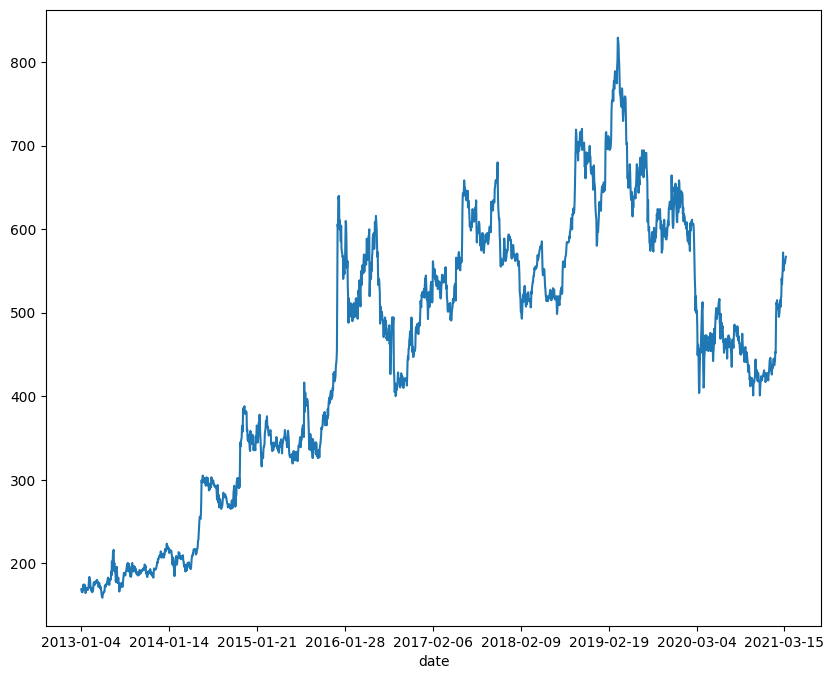

In [247]:
# before imputing/filling NaN values
fig = plt.figure(1,figsize = (10,8))
filtered_price_df['1332 JT'].plot()

In [248]:
filtered_price_df.head(10)

ticker       1332 JT    1605 JT   1721 JT    1801 JT   1802 JT   1803 JT  \
date                                                                       
2013-01-04  169.0987   970.6780  950.5521  1232.0186  413.2189  278.1162   
2013-01-07  166.3266   960.1615  924.2187  1236.1949  411.5426  278.1162   
2013-01-08  166.3266   955.9548  938.6596  1215.3132  407.3517  277.2709   
2013-01-09  165.4026   944.3866  945.4553  1240.3712  417.4098  278.9616   
2013-01-10  167.2507   942.2833  943.7564  1252.9002  435.0114  284.8789   
2013-01-11  170.9468   981.1946  935.2617  1244.5476  435.8496  285.7243   
2013-01-15  174.6430  1004.3310  950.5521  1248.7239  430.8206  280.6523   
2013-01-16  169.0987   983.2979  944.6059  1211.1369  414.0571  269.6629   
2013-01-17  169.0987   986.4528  929.3155  1165.1972  396.4555  263.7455   
2013-01-18  174.6430  1000.1244  942.9069  1148.4919  391.4265  263.7455   

ticker       1812 JT    1925 JT   1928 JT    1963 JT  ...    9502 JT  \
date                                                  ...              
2013-01-04  478.8201  1214.8674  718.0180  2381.3169  ...  1038.6998   
2013-01-07  480.4769  1196.8868  720.2228  2352.1579  ...  1009.8470   
2013-01-08  473.8496  1181.2514  709.9339  2378.6661  ...   992.8748   
2013-01-09  482.1337  1203.1409  707.7291  2395.4546  ...   987.7831   
2013-01-10  490.4178  1225.8122  727.5720  2398.1054  ...   997.9665   
2013-01-11  490.4178  1210.1768  729.7768  2439.6349  ...   984.3887   
2013-01-15  488.7610  1262.5553  752.5593  2417.5447  ...  1001.3609   
2013-01-16  480.4769  1219.5580  738.5958  2403.4070  ...   967.4165   
2013-01-17  460.5951  1208.6133  727.5720  2356.5760  ...   980.9942   
2013-01-18  460.5951  1249.2652  745.9450  2327.4170  ...   990.3290   

ticker       9503 JT    9531 JT    9532 JT    9602 JT   9613 JT    9735 JT  \
date                                                                         
2013-01-04  847.8471  1727.7597  1332.1473  1367.1194  487.5256  3719.2396   
2013-01-07  804.2336  1744.7820  1327.9713  1364.4123  475.2036  3732.0499   
2013-01-08  795.5109  1761.8042  1340.4993  1377.0457  470.5604  3736.3199   
2013-01-09  780.6823  1766.0598  1336.3233  1440.2130  479.3109  3757.6703   
2013-01-10  810.3395  1757.5487  1340.4993  1516.0136  481.9896  3791.8310   
2013-01-11  804.2336  1757.5487  1344.6753  1515.1112  485.3827  3834.5318   
2013-01-15  804.2336  1800.1043  1373.9074  1516.9160  490.2043  3885.7727   
2013-01-16  771.0873  1821.3821  1382.2594  1509.6969  485.9184  3800.3711   
2013-01-17  777.1932  1846.9155  1390.6114  1506.0874  472.1677  3791.8310   
2013-01-18  792.0218  1846.9155  1378.0834  1501.5754  487.3470  3838.8019   

ticker        9766 JT     9983 JT    9984 JT  
date                                          
2013-01-04  1721.7623  20584.8363  1482.3931  
2013-01-07  1695.8510  21150.4557  1453.9312  
2013-01-08  1627.9455  21243.1802  1472.9058  
2013-01-09  1612.7561  21159.7281  1442.0720  
2013-01-10  1568.9749  20918.6445  1442.0720  
2013-01-11  1621.6910  21920.0689  1432.5847  
2013-01-15  1617.2236  22086.9730  1439.7002  
2013-01-16  1584.1643  21067.0037  1392.7380  
2013-01-17  1579.6968  21085.5486  1421.6743  
2013-01-18  1596.6732  21725.3475  1432.5847  

[10 rows x 208 columns]

In [249]:
check_for_NaN(filtered_price_df)

ticker
1332 JT    0
1605 JT    0
1721 JT    0
1801 JT    0
1802 JT    0
          ..
9613 JT    0
9735 JT    0
9766 JT    0
9983 JT    0
9984 JT    0
Length: 208, dtype: int64


ticker
1332 JT    0
1605 JT    0
1721 JT    0
1801 JT    0
1802 JT    0
          ..
9613 JT    0
9735 JT    0
9766 JT    0
9983 JT    0
9984 JT    0
Length: 208, dtype: int64

There might still be NaN values.

Next, I will replace any NaN values using forward filling -- this is good practice towards productionalization of the code

In [250]:
# putting all cleaning steps in a single function
def clean_data(df,threshold_weight=0.9):
    # Remove columns with more than 'threshold' NaN values. A minimum of 90% is set for non-NaN values
    filtered_data = df.dropna(axis=1, thresh=threshold_weight*len(df))
    # Perform data imputation for each column
    filtered_data = filtered_data.fillna(method='ffill', axis=0)
    # Remove any duplicate rows - not expected 
    filtered_data.drop_duplicates(inplace=True)

    filtered_data.index =  pd.to_datetime(filtered_data.index) # convert date to datetime for easy handling

    # some stocks not listed in the first date will still be in the tables, it is best to filter them out
    filtered_data = filtered_data.loc[:, filtered_data.iloc[0].notna()] # removes '3289 JT' , '6988 JT' , '3863 JT' : not listed in Jan 2013
        
    return filtered_data

In [251]:
filtered_price_df = clean_data(price_df)
filtered_volume_df = clean_data(volume_df)

In [252]:
# compare the columns of the cleaned data
print(filtered_volume_df.describe())

ticker       1332 JT       1605 JT       1721 JT       1801 JT       1802 JT  \
count   2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03   
mean    2.853706e+06  6.173909e+06  7.255047e+05  1.582422e+06  3.853753e+06   
std     2.798325e+06  3.045633e+06  3.661211e+05  1.961919e+06  2.382013e+06   
min     5.844000e+05  1.389800e+06  1.735000e+05  2.773000e+05  7.880000e+05   
25%     1.676800e+06  4.191400e+06  4.910000e+05  8.175000e+05  2.371700e+06   
50%     2.313200e+06  5.465200e+06  6.445000e+05  1.223400e+06  3.239100e+06   
75%     3.202500e+06  7.277400e+06  8.520000e+05  1.867200e+06  4.666000e+06   
max     6.385470e+07  2.835420e+07  4.233200e+06  5.920440e+07  3.181720e+07   

ticker       1803 JT       1812 JT       1925 JT       1928 JT       1963 JT  \
count   2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03  2.005000e+03   
mean    3.648841e+06  3.092552e+06  2.138574e+06  3.246529e+06  1.846513e+06   
std     2.232276e+06  2.145616e+06  1.0

The price and volume tables might have different number of stocks, 

Next, I will collate the common stocks in all the tables

In [253]:
# get the column names of the different datasets and collate them
filtered_price_df_cols = (filtered_price_df.columns).tolist()
filtered_volume_df_cols = (filtered_volume_df.columns).tolist()

In [254]:
collated_cols = ([x for x in filtered_price_df_cols if all(x in lst for lst in [filtered_volume_df_cols])])
collated_cols = sorted(collated_cols)

In [255]:
print(len(collated_cols))

205


After cleaning and filtering, 43 stocks have been removed. We are left with 205 stocks

In [256]:
# obtain the collated data with the 208 stocks
collated_price_df = filtered_price_df[collated_cols]
collated_volume_df = filtered_volume_df[collated_cols]

In [257]:
collated_price_df[collated_price_df.isna().any(axis=1)]

Empty DataFrame
Columns: [1332 JT, 1605 JT, 1721 JT, 1801 JT, 1802 JT, 1803 JT, 1812 JT, 1925 JT, 1928 JT, 1963 JT, 2002 JT, 2269 JT, 2282 JT, 2501 JT, 2502 JT, 2503 JT, 2531 JT, 2768 JT, 2801 JT, 2802 JT, 2871 JT, 2914 JT, 3086 JT, 3099 JT, 3101 JT, 3103 JT, 3105 JT, 3382 JT, 3401 JT, 3402 JT, 3405 JT, 3407 JT, 3436 JT, 3861 JT, 4004 JT, 4005 JT, 4021 JT, 4042 JT, 4043 JT, 4061 JT, 4063 JT, 4151 JT, 4183 JT, 4188 JT, 4208 JT, 4272 JT, 4324 JT, 4452 JT, 4502 JT, 4503 JT, 4506 JT, 4507 JT, 4519 JT, 4523 JT, 4543 JT, 4568 JT, 4689 JT, 4704 JT, 4901 JT, 4902 JT, 4911 JT, 5020 JT, 5101 JT, 5108 JT, 5201 JT, 5202 JT, 5214 JT, 5232 JT, 5233 JT, 5301 JT, 5332 JT, 5333 JT, 5401 JT, 5406 JT, 5411 JT, 5541 JT, 5631 JT, 5703 JT, 5706 JT, 5707 JT, 5711 JT, 5713 JT, 5714 JT, 5801 JT, 5802 JT, 5803 JT, 5901 JT, 6103 JT, 6113 JT, 6301 JT, 6302 JT, 6305 JT, 6326 JT, 6361 JT, 6367 JT, 6471 JT, 6472 JT, 6473 JT, 6479 JT, 6501 JT, ...]
Index: []

[0 rows x 205 columns]

In [258]:
collated_price_df.to_csv('collated_price_df.csv')

Separate the data into training and test sets

training set: 2013, 2014, 2015 data

test set: 2016, 2017, 2018, 2019, 2020, 2021 data

In [259]:
# divide data into training and testing sets
# convert index to datetime
collated_price_df.index = pd.to_datetime(collated_price_df.index)
collated_volume_df.index = pd.to_datetime(collated_volume_df.index)

# separate the data
train_collated_price_df = collated_price_df[(collated_price_df.index).year <= 2015]
test_collated_price_df = collated_price_df[(collated_price_df.index).year > 2015]


train_collated_volume_df = collated_volume_df[(collated_volume_df.index).year <= 2015]
test_collated_volume_df = collated_volume_df[(collated_volume_df.index).year > 2015]

# manual check
display(train_collated_price_df.head(3))
display(train_collated_price_df.tail(3))


display(test_collated_price_df.head(3))
display(test_collated_price_df.tail(3))

ticker       1332 JT   1605 JT   1721 JT    1801 JT   1802 JT   1803 JT  \
date                                                                      
2013-01-04  169.0987  970.6780  950.5521  1232.0186  413.2189  278.1162   
2013-01-07  166.3266  960.1615  924.2187  1236.1949  411.5426  278.1162   
2013-01-08  166.3266  955.9548  938.6596  1215.3132  407.3517  277.2709   

ticker       1812 JT    1925 JT   1928 JT    1963 JT  ...    9502 JT  \
date                                                  ...              
2013-01-04  478.8201  1214.8674  718.0180  2381.3169  ...  1038.6998   
2013-01-07  480.4769  1196.8868  720.2228  2352.1579  ...  1009.8470   
2013-01-08  473.8496  1181.2514  709.9339  2378.6661  ...   992.8748   

ticker       9503 JT    9531 JT    9532 JT    9602 JT   9613 JT    9735 JT  \
date                                                                         
2013-01-04  847.8471  1727.7597  1332.1473  1367.1194  487.5256  3719.2396   
2013-01-07  804.2336  1744.7820  1327.9713  1364.4123  475.2036  3732.0499   
2013-01-08  795.5109  1761.8042  1340.4993  1377.0457  470.5604  3736.3199   

ticker        9766 JT     9983 JT    9984 JT  
date                                          
2013-01-04  1721.7623  20584.8363  1482.3931  
2013-01-07  1695.8510  21150.4557  1453.9312  
2013-01-08  1627.9455  21243.1802  1472.9058  

[3 rows x 205 columns]

ticker       1332 JT    1605 JT    1721 JT    1801 JT   1802 JT   1803 JT  \
date                                                                        
2015-12-28  602.2811  1029.9669  1546.8918  3446.4557  962.4982  862.6563   
2015-12-29  638.8113  1038.7438  1550.4788  3489.9715  978.2053  875.8467   
2015-12-30  636.0013  1040.4991  1532.5438  3481.2684  976.4601  870.5705   

ticker        1812 JT    1925 JT    1928 JT    1963 JT  ...    9502 JT  \
date                                                    ...              
2015-12-28  1220.1843  2915.5097  1614.3256  1722.4256  ...  1426.2970   
2015-12-29  1249.4000  2993.1316  1645.0439  1727.0261  ...  1434.2014   
2015-12-30  1244.2443  2988.0136  1654.3402  1714.1447  ...  1460.1101   

ticker        9503 JT    9531 JT    9532 JT    9602 JT    9613 JT   9735 JT  \
date                                                                          
2015-12-28  1252.1446  2484.0534  1916.7884  3101.2568  1085.0907  7411.381   
2015-12-29  1259.1227  2512.3221  1935.4888  3133.9508  1092.5612  7497.273   
2015-12-30  1273.0791  2561.2314  1951.9629  3138.6214  1098.1641  7529.254   

ticker        9766 JT     9983 JT    9984 JT  
date                                          
2015-12-28  2642.7538  40539.9639  2964.3586  
2015-12-29  2672.5418  40130.6616  2963.3912  
2015-12-30  2688.3666  40587.5572  2969.1952  

[3 rows x 205 columns]

ticker       1332 JT    1605 JT    1721 JT    1801 JT   1802 JT   1803 JT  \
date                                                                        
2016-01-04  639.7480  1063.3190  1476.9454  3398.5882  954.6446  852.1039   
2016-01-05  600.4077  1067.2686  1481.4291  3381.1819  952.0268  860.8975   
2016-01-06  610.7111  1033.0388  1470.6682  3368.1271  958.1351  858.2594   

ticker        1812 JT    1925 JT    1928 JT    1963 JT  ...    9502 JT  \
date                                                    ...              
2016-01-04  1211.5915  2896.7440  1613.9214  1678.2608  ...  1402.1448   
2016-01-05  1206.4358  2890.7731  1603.0083  1664.4593  ...  1415.7579   
2016-01-06  1201.2801  2892.4791  1598.5623  1635.9363  ...  1422.7840   

ticker        9503 JT    9531 JT    9532 JT    9602 JT    9613 JT    9735 JT  \
date                                                                           
2016-01-04  1239.4967  2450.8489  1901.6500  3059.2217  1070.1497  7334.6265   
2016-01-05  1237.7521  2458.0283  1918.1241  3031.1983  1077.6202  7308.1279   
2016-01-06  1237.7521  2445.4644  1912.7812  3026.5278  1062.6792  7220.4084   

ticker        9766 JT     9983 JT    9984 JT  
date                                          
2016-01-04  2602.7262  38693.3443  2898.5807  
2016-01-05  2649.2699  38483.9338  2886.9728  
2016-01-06  2630.6524  38236.4487  2848.2799  

[3 rows x 205 columns]

ticker      1332 JT  1605 JT  1721 JT  1801 JT  1802 JT  1803 JT  1812 JT  \
date                                                                        
2021-03-17    561.0    808.0   3400.0   4220.0   1007.0    909.0   1558.0   
2021-03-18    565.0    812.0   3455.0   4300.0   1028.0    921.0   1581.0   
2021-03-19    567.0    796.0   3455.0   4345.0   1054.0    926.0   1600.0   

ticker      1925 JT  1928 JT  1963 JT  ...  9502 JT  9503 JT  9531 JT  \
date                                   ...                              
2021-03-17   3387.0   2263.0   1443.0  ...   1417.5   1193.0   2450.0   
2021-03-18   3465.0   2332.5   1441.0  ...   1431.0   1199.5   2442.5   
2021-03-19   3466.0   2345.0   1435.0  ...   1440.0   1218.0   2466.0   

ticker      9532 JT  9602 JT  9613 JT  9735 JT  9766 JT  9983 JT  9984 JT  
date                                                                       
2021-03-17   2150.0   4335.0   1764.0   9680.0   7200.0  96000.0  10400.0  
2021-03-18   2162.0   4340.0   1770.0   9700.0   7110.0  96930.0  10220.0  
2021-03-19   2167.0   4320.0   1723.0   9594.0   6850.0  91020.0   9969.0  

[3 rows x 205 columns]

Now, I will proceed with pair selection

In [260]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
data_processor = class_DataProcessor.DataProcessor()
training_returns = data_processor.get_return_series(train_collated_price_df)
training_returns.head()


ticker       1332 JT   1605 JT   1721 JT   1801 JT   1802 JT   1803 JT  \
date                                                                     
2013-01-07 -0.016393 -0.010834 -0.027703  0.003390 -0.004057  0.000000   
2013-01-08  0.000000 -0.004381  0.015625 -0.016892 -0.010183 -0.003039   
2013-01-09 -0.005555 -0.012101  0.007240  0.020619  0.024691  0.006098   
2013-01-10  0.011173 -0.002227 -0.001797  0.010101  0.042169  0.021212   
2013-01-11  0.022099  0.041295 -0.009001 -0.006667  0.001927  0.002968   

ticker       1812 JT   1925 JT   1928 JT   1963 JT  ...   9502 JT   9503 JT  \
date                                                ...                       
2013-01-07  0.003460 -0.014800  0.003071 -0.012245  ... -0.027778 -0.051440   
2013-01-08 -0.013793 -0.013063 -0.014286  0.011270  ... -0.016807 -0.010846   
2013-01-09  0.017483  0.018531 -0.003106  0.007058  ... -0.005128 -0.018640   
2013-01-10  0.017182  0.018843  0.028037  0.001107  ...  0.010309  0.037989   
2013-01-11  0.000000 -0.012755  0.003030  0.017318  ... -0.013605 -0.007535   

ticker       9531 JT   9532 JT   9602 JT   9613 JT   9735 JT   9766 JT  \
date                                                                     
2013-01-07  0.009852 -0.003135 -0.001980 -0.025275  0.003444 -0.015049   
2013-01-08  0.009756  0.009434  0.009259 -0.009771  0.001144 -0.040042   
2013-01-09  0.002415 -0.003115  0.045872  0.018596  0.005714 -0.009330   
2013-01-10 -0.004819  0.003125  0.052632  0.005589  0.009091 -0.027147   
2013-01-11  0.000000  0.003115 -0.000595  0.007040  0.011261  0.033599   

ticker       9983 JT   9984 JT  
date                            
2013-01-07  0.027477 -0.019200  
2013-01-08  0.004384  0.013051  
2013-01-09 -0.003928 -0.020934  
2013-01-10 -0.011394  0.000000  
2013-01-11  0.047872 -0.006579  

[5 rows x 205 columns]

In [261]:
training_returns[training_returns.isna().any(axis=1)]

Empty DataFrame
Columns: [1332 JT, 1605 JT, 1721 JT, 1801 JT, 1802 JT, 1803 JT, 1812 JT, 1925 JT, 1928 JT, 1963 JT, 2002 JT, 2269 JT, 2282 JT, 2501 JT, 2502 JT, 2503 JT, 2531 JT, 2768 JT, 2801 JT, 2802 JT, 2871 JT, 2914 JT, 3086 JT, 3099 JT, 3101 JT, 3103 JT, 3105 JT, 3382 JT, 3401 JT, 3402 JT, 3405 JT, 3407 JT, 3436 JT, 3861 JT, 4004 JT, 4005 JT, 4021 JT, 4042 JT, 4043 JT, 4061 JT, 4063 JT, 4151 JT, 4183 JT, 4188 JT, 4208 JT, 4272 JT, 4324 JT, 4452 JT, 4502 JT, 4503 JT, 4506 JT, 4507 JT, 4519 JT, 4523 JT, 4543 JT, 4568 JT, 4689 JT, 4704 JT, 4901 JT, 4902 JT, 4911 JT, 5020 JT, 5101 JT, 5108 JT, 5201 JT, 5202 JT, 5214 JT, 5232 JT, 5233 JT, 5301 JT, 5332 JT, 5333 JT, 5401 JT, 5406 JT, 5411 JT, 5541 JT, 5631 JT, 5703 JT, 5706 JT, 5707 JT, 5711 JT, 5713 JT, 5714 JT, 5801 JT, 5802 JT, 5803 JT, 5901 JT, 6103 JT, 6113 JT, 6301 JT, 6302 JT, 6305 JT, 6326 JT, 6361 JT, 6367 JT, 6471 JT, 6472 JT, 6473 JT, 6479 JT, 6501 JT, ...]
Index: []

[0 rows x 205 columns]

In [262]:
print('Total number of possible pairs: ', len(training_returns.columns)*(len(training_returns.columns)-1)/2)

Total number of possible pairs:  20910.0


In [263]:
average_volume_info = pd.DataFrame(train_collated_volume_df.mean(axis=0), columns=['volume']) # compute average volume of each stock using training data

In [264]:
average_volume_info.head(5)

volume
ticker               
1332 JT  2.686977e+06
1605 JT  5.453648e+06
1721 JT  8.709952e+05
1801 JT  2.456847e+06
1802 JT  5.345052e+06

In [371]:
np.random.seed(42)
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(training_returns)

PCA(n_components=50)

In [372]:
pca.components_.T.shape

(205, 50)

In [373]:
# adding volume information to improve clustering performance
X = np.hstack(
    (pca.components_.T,
    average_volume_info['volume'][training_returns.columns].values[:,np.newaxis])
)

print(X.shape)

(205, 51)


In [374]:
X = preprocessing.StandardScaler().fit_transform(X)

In [375]:
X.shape

(205, 51)

In [376]:
def cluster_size(counts):
    plt.figure()
    plt.barh(counts.index+1, counts.values)
    #plt.title('Cluster Member Counts')
    plt.yticks(np.arange(1, len(counts)+1, 1))
    plt.xlabel('Stocks within cluster', size=12)
    plt.ylabel('Cluster Id', size=12)

In [377]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(3.5,
                                                                                   3,
                                                                                   X,
                                                                                   training_returns)

Clusters discovered: 7
Pairs to evaluate: 70


2    10
3     5
0     3
1     3
4     3
5     3
6     3
dtype: int64
Average cluster size:  4.285714285714286


<Figure size 1600x1200 with 0 Axes>

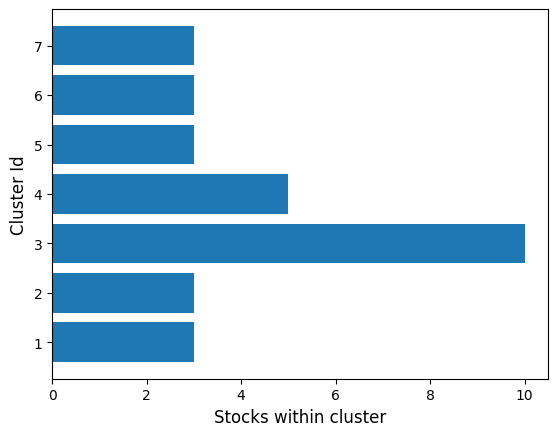

In [378]:
plt.figure(1,figsize=(16,12))
cluster_size(counts)


print(counts)
print('Average cluster size: ', np.mean(counts))


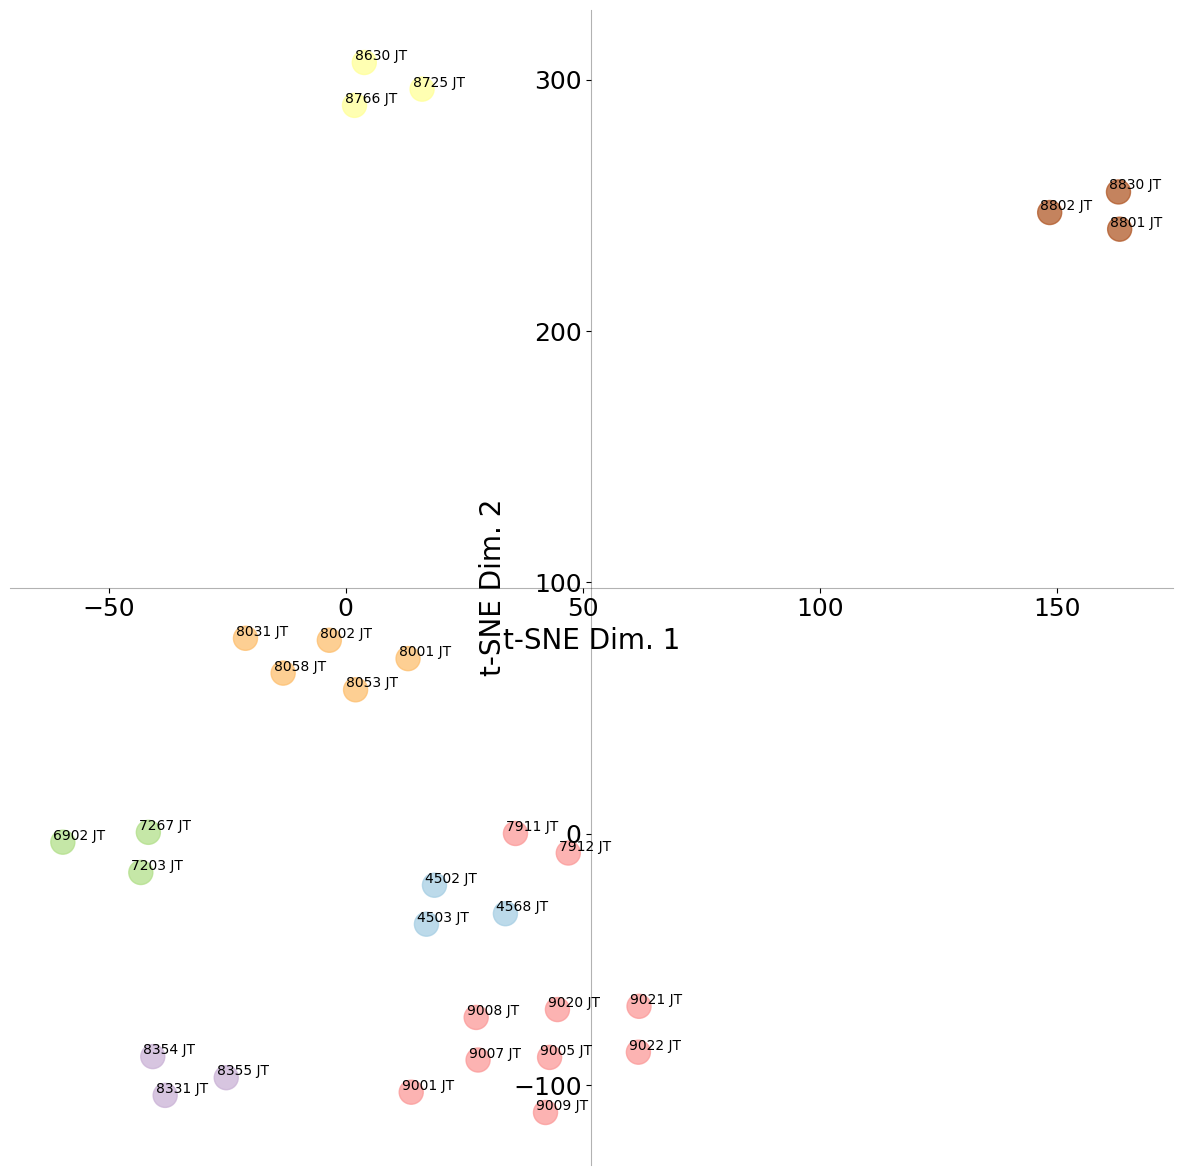

In [379]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)
    
    # visualization
    fig = plt.figure(1, facecolor='white', figsize=(15,15), frameon=True, edgecolor='black')
    plt.clf()
    
    # axis in the middle
    ax = fig.add_subplot(1, 1, 1, alpha=0.9)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_alpha(0.3)
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(which='major', labelsize=18)
    #plt.axis('off')

    # stocks in cluster
    labels = clf.labels_
    x = X_tsne[(labels!=-1), 0]
    y = X_tsne[(labels!=-1), 1]
    tickers = list(clustered_series_all[clustered_series_all != -1].index)
    plt.scatter(
        x,
        y,
        s=300,
        alpha=0.75,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )
    for i, ticker in enumerate(tickers):
        # plt.annotate(ticker, (x[i]-20, y[i]+12), size=15)
        plt.annotate(ticker, (x[i]-2, y[i]+1), size=10)


    # x = np.array(x)
    # y = np.array(y)

    #for i, ticker in enumerate(tickers):
    #    plt.annotate(ticker, (x[i]+20, y[i]+20))#, arrowprops={'arrowstyle':'simple'})
        
    #plt.title('OPTICS clusters visualized with t-SNE', size=16);
    plt.xlabel('t-SNE Dim. 1', position=(0.92,0), size=20)
    plt.ylabel('t-SNE Dim. 2', position=(0,0.92), size=20)
    # ax.set_xticks(range(-300, 0, 60))
    # ax.set_yticks(range(-300, 0, 60))
    #plt.savefig('DBSCAN_2014_2018_eps0_15.png', bbox_inches='tight', pad_inches=0.01)
    plt.savefig('DBSCAN_2013_2015.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    # include connections - see quontopian



plot_TSNE(X,clf, clustered_series_all)

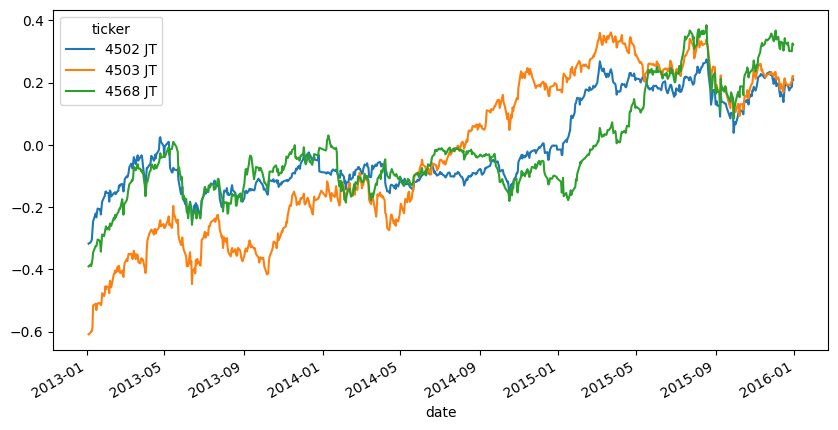

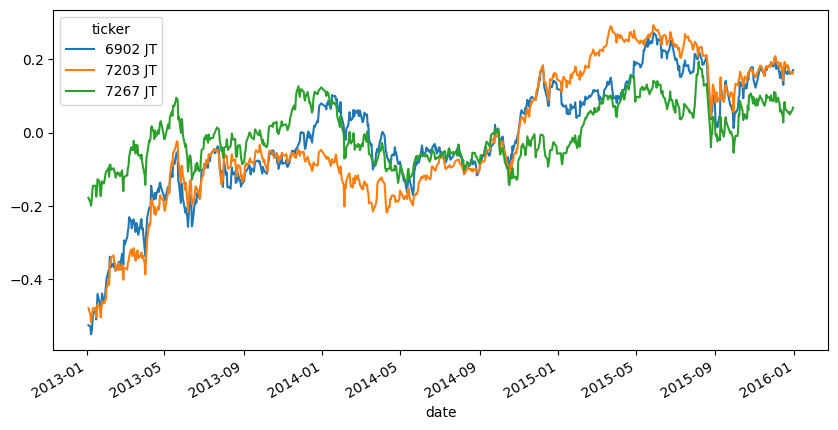

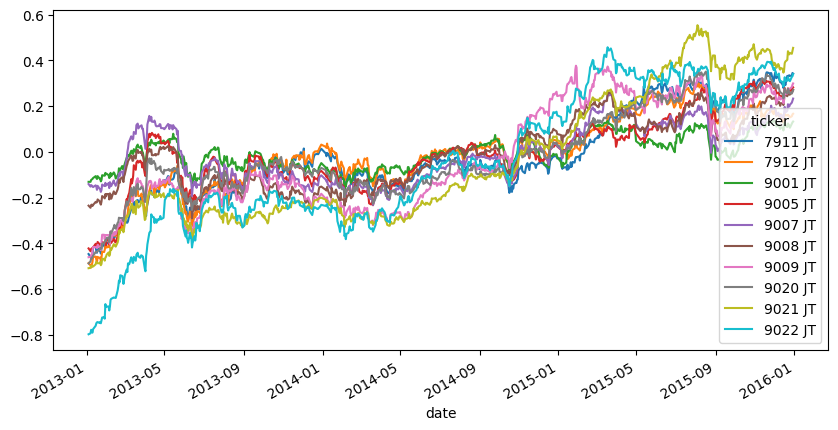

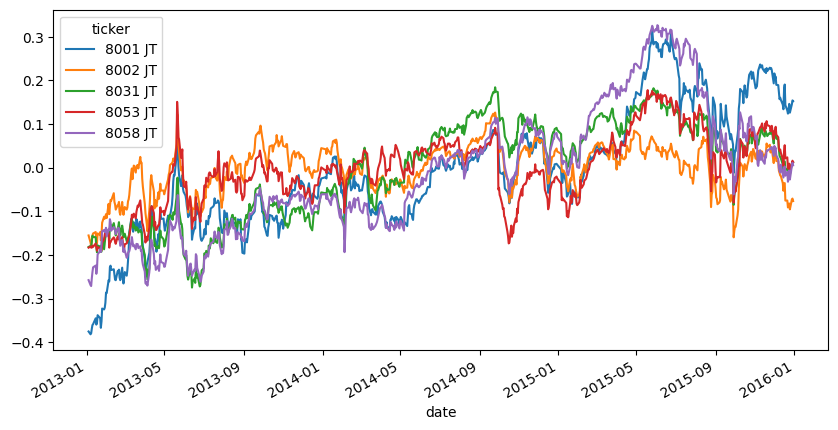

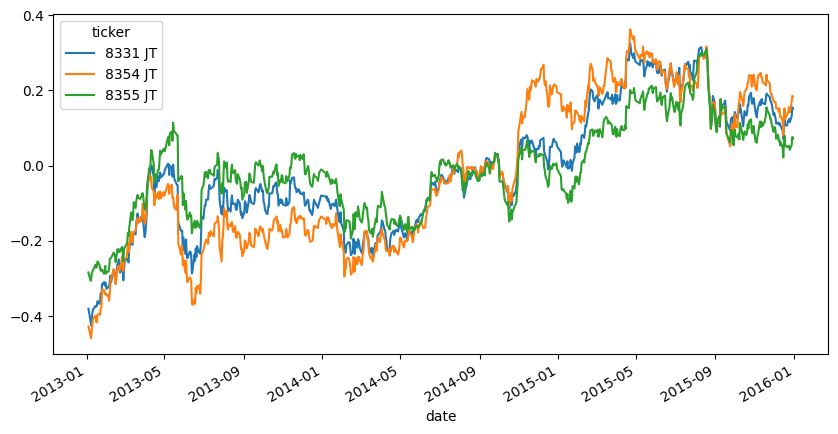

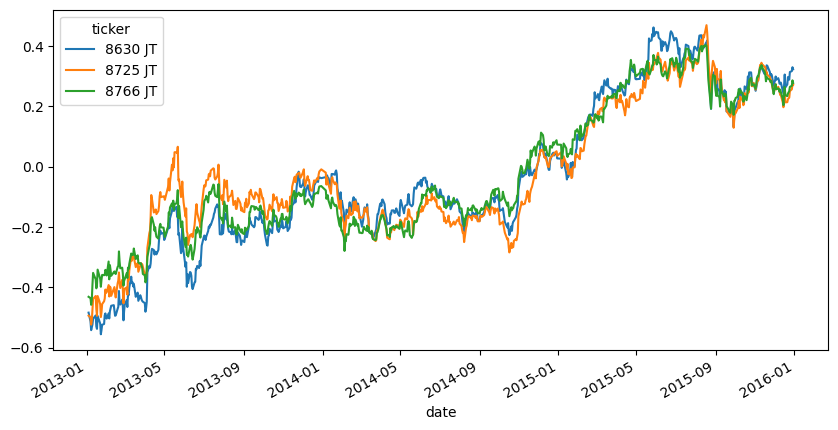

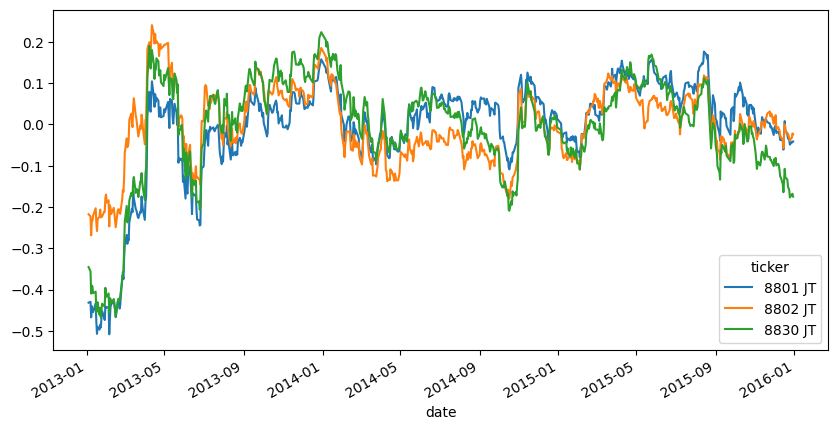

In [380]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(train_collated_price_df[symbols].mean())
    series = np.log(train_collated_price_df[symbols]).sub(means)
    series.plot(figsize=(10,5))#title='ETFs Time Series for Cluster %d' % (clust+1))
    #plt.ylabel('Normalized log prices', size=12)
    #plt.xlabel('Date', size=12)
    plt.savefig('results/clustering_outcome/cluster_{}.png'.format(str(clust+1)), bbox_inches='tight', pad_inches=0.1)


In [381]:
subsample = 1000 # 2500
min_half_life = 1 #78 # number of points in a day
max_half_life = 252 #20000 #~number of points in a year: 78*252

pairs_unsupervised, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=train_collated_price_df,
                                                            pricing_df_test=test_collated_price_df,
                                                            min_half_life=min_half_life,
                                                            max_half_life=max_half_life,
                                                            min_zero_crosings=12,
                                                            p_value_threshold=0.05,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample
                                                            )


all_pairs = []
t_statistic = []
p_value = []
coint_coef = []
zero_cross = []
half_life = []
hurst_exponent = []
spread = []

pairing_metric = [t_statistic, p_value, coint_coef, zero_cross, half_life,hurst_exponent, spread]
pairing_metric_string = ['t_statistic', 'p_value', 'coint_coef', 'zero_cross', 'half_life', 'hurst_exponent', 'spread']

for pair in pairs_unsupervised:
    all_pairs.append((pair[0],pair[1]))
    for idx, metric in enumerate(pairing_metric):
        metric.append(pair[2][pairing_metric_string[idx]])
    # print(pair[2])

print(all_pairs)
print(hurst_exponent)


Cluster 7/7Found 17 pairs
The pairs contain 17 unique tickers
Pairs Selection failed stage:  {'cointegration': 53, 'None': 17}
[('6902 JT', '7203 JT'), ('7911 JT', '9001 JT'), ('7911 JT', '9005 JT'), ('7912 JT', '9021 JT'), ('9001 JT', '9005 JT'), ('9001 JT', '9007 JT'), ('9001 JT', '9008 JT'), ('9001 JT', '9009 JT'), ('9001 JT', '9020 JT'), ('9001 JT', '9021 JT'), ('9001 JT', '9022 JT'), ('9005 JT', '9021 JT'), ('9009 JT', '9022 JT'), ('9020 JT', '9021 JT'), ('8331 JT', '8355 JT'), ('8630 JT', '8766 JT'), ('8725 JT', '8766 JT')]
[0.4309718005136872, 0.3239934705295372, 0.4474111428635595, 0.40243893314841783, 0.357287295667681, 0.2548191929637193, 0.28238815453438304, 0.30862569613252905, 0.31869876919144036, 0.3107271947369549, 0.2598008505974249, 0.3909022075041255, 0.4017056198932035, 0.36736187454357433, 0.2941032783282862, 0.25457063501917987, 0.3096305374345446]


In [382]:
pairing_metric_df = pd.DataFrame({
    'pairs': all_pairs,
    't_statistic': t_statistic, 
    'p_value': p_value, 
    'coint_coef': coint_coef, 
    'zero_cross': zero_cross, 
    'half_life': half_life, 
    'hurst_exponent': hurst_exponent,
})



pairing_metric_df

pairs  t_statistic   p_value  coint_coef  zero_cross  \
0   (6902 JT, 7203 JT)    -2.954651  0.039352    0.594890          39   
1   (7911 JT, 9001 JT)    -3.081635  0.027942    0.473723          39   
2   (7911 JT, 9005 JT)    -3.051582  0.030350    0.713315          47   
3   (7912 JT, 9021 JT)    -3.176201  0.021404    0.174814          36   
4   (9001 JT, 9005 JT)    -2.978553  0.036946    1.013671          43   
5   (9001 JT, 9007 JT)    -3.793134  0.002978    0.663768          69   
6   (9001 JT, 9008 JT)    -4.156469  0.000780    0.289039          51   
7   (9001 JT, 9009 JT)    -3.555290  0.006676    0.287469          39   
8   (9001 JT, 9020 JT)    -3.268528  0.016345    0.094821          51   
9   (9001 JT, 9021 JT)    -3.669899  0.004557    0.094769          39   
10  (9001 JT, 9022 JT)    -3.569096  0.006380    0.033434          53   
11  (9005 JT, 9021 JT)    -3.109852  0.025833    0.135167          41   
12  (9009 JT, 9022 JT)    -3.102209  0.026390    8.263229          30   
13  (9020 JT, 9021 JT)    -3.958953  0.001641    1.001917          60   
14  (8331 JT, 8355 JT)    -3.414943  0.010460    1.029639          56   
15  (8630 JT, 8766 JT)    -3.718341  0.003862    0.942843          62   
16  (8725 JT, 8766 JT)    -3.019312  0.033130    0.719093          45   

    half_life  hurst_exponent  
0          33        0.430972  
1          27        0.323993  
2          38        0.447411  
3          31        0.402439  
4          38        0.357287  
5          15        0.254819  
6          15        0.282388  
7          20        0.308626  
8          23        0.318699  
9          20        0.310727  
10         19        0.259801  
11         31        0.390902  
12         29        0.401706  
13         21        0.367362  
14         22        0.294103  
15         16        0.254571  
16         23        0.309631

In [383]:
# I will proceed with using the 7 pairs identified above

# write intermediate function to investigate pairs

# signal evaluation metrics

def compute_hit_rate(signals, actual_returns):
    # Compute the hit rate of the signals
    predicted_directions = np.sign(signals)
    actual_directions = np.sign(actual_returns)
    num_correct = np.sum(predicted_directions == actual_directions)
    hit_rate = num_correct / len(signals)
    return hit_rate

def compute_profitability(signals, actual_returns):
    # Compute the profitability of the signals
    pnl = signals * actual_returns
    total_profit = np.sum(pnl)
    return total_profit

def compute_risk_reward_ratio(signals, actual_returns):
    # Compute the risk-to-reward ratio of the signals
    positive_pnl = signals * actual_returns
    positive_pnl = positive_pnl[positive_pnl > 0]
    negative_pnl = signals * actual_returns
    negative_pnl = negative_pnl[negative_pnl < 0]
    
    if len(negative_pnl) > 0:
        risk_reward_ratio = np.abs(np.mean(positive_pnl) / np.mean(negative_pnl))
    else:
        risk_reward_ratio = np.inf
    
    return risk_reward_ratio


def compute_win_rate(signal, returns):
    """
    Calculates the win rate of the trading signal.

    Args:
    signal (np.ndarray): The trading signal
    returns (np.ndarray): The actual returns

    Returns:
    float: The win rate of the trading signal
    """
    profits = signal * returns
    return np.mean(profits > 0)

def compute_maximum_drawdown(signal, returns):
    """
    Calculates the maximum drawdown of the trading signal.

    Args:
    signal (np.ndarray): The trading signal
    returns (np.ndarray): The actual returns

    Returns:
    float: The maximum drawdown of the trading signal
    """
    profits = signal * returns
    cum_profits = np.cumsum(profits)
    # remove nan from cum_profits
    cum_profits = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in cum_profits]
    max_drawdown = np.max(np.maximum.accumulate(cum_profits) - cum_profits)
    return max_drawdown

In [384]:
def calculate_rsi(values, period=14):
    """
    Calculates the Relative Strength Index (RSI) for a given list of values.

    Args:
        values (list, np.ndarray): List or numpy array of values.
        period (int): Period for calculating the RSI. Default is 14.

    Returns:
        np.ndarray: Numpy array of RSI values.
    """
    if len(values) < period:
        raise ValueError("Number of values is less than the specified period.")

    deltas = np.diff(values)
    gains = np.where(deltas > 0, deltas, 0)
    losses = -np.where(deltas < 0, deltas, 0)
    avg_gain = np.convolve(gains, np.ones(period) / period, mode='valid')
    avg_loss = np.convolve(losses, np.ones(period) / period, mode='valid')
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # Pad the resulting array to match the original length
    rsi = np.pad(rsi, (values.size - rsi.size, 0), mode='constant', constant_values=np.nan)
    rsi = (pd.Series(rsi)).tolist()
    rsi = [item if item is not None else 0 for item in rsi]
    return np.array(rsi)


def calculate_sma(values, period):
    """
    Calculates the Simple Moving Average (SMA) for a given list of values and period.

    Args:
        values (list, np.ndarray): List or numpy array of values.
        period (int): Period for which to calculate the SMA.

    Returns:
        np.ndarray: Numpy array of SMA values.
    """
    if len(values) < period:
        raise ValueError("Number of values is less than the specified period.")

    sma_values = np.convolve(values, np.ones((period,))/period, mode='valid')
    sma_values = np.concatenate(([None]*(period-1), sma_values))
    sma_values = [item if item is not None else 0 for item in sma_values]
    return np.array(sma_values)

def calculate_ema(values, period):
    """
    Calculates the Exponential Moving Average (EMA) for a given list of values and period.

    Args:
        values (list, np.ndarray): List or numpy array of values.
        period (int): Period for which to calculate the EMA.

    Returns:
        np.ndarray: Numpy array of EMA values.
    """
    if len(values) < period:
        raise ValueError("Number of values is less than the specified period.")

    alpha = 2 / (period + 1)
    ema_values = [None]
    for i in range(1, len(values)):
        if ema_values[-1] is None:
            ema = values[i]
        else:
            ema = alpha * values[i] + (1 - alpha) * ema_values[-1]
        ema_values.append(ema)
    ema_values = [item if item is not None else 0 for item in ema_values]
    return np.array(ema_values)

In [385]:

def zscore_with_zero_exempt(series):
    # we make the healthy assumption that the ratio of the price or moving averages
    # of two stocks can never be zero
    non_zero_elements = [x for x in series if x != 0]
    mean = np.mean(non_zero_elements)
    std = np.std(non_zero_elements)

    def zscore_element(x):
        return (x - mean) / std if x != 0 else 0

    return [zscore_element(x) for x in series]

# a = [0, 0, 0, 0, 0, 1, 2, 3, 4]
# result = zscore_with_zero_exempt(a)
# print(result)
# [0, 0, 0, 0, 0, -1.3416407864998738, -0.4472135954999579, 0.4472135954999579, 1.3416407864998738]

In [386]:
# it is important to know the annualization for metrics computation
# this is the number of trading days in a year, and this value is not always 252

# I will be using the first year in the test data i.e, 2016
first_year_df = collated_price_df[(collated_price_df.index).year < 2017] 
first_year_df = first_year_df[(first_year_df.index).year > 2015]

display(first_year_df.head(3))
display(first_year_df.tail(3))

print('Number of trading days in 2016: ', len(first_year_df['1332 JT']))

ticker       1332 JT    1605 JT    1721 JT    1801 JT   1802 JT   1803 JT  \
date                                                                        
2016-01-04  639.7480  1063.3190  1476.9454  3398.5882  954.6446  852.1039   
2016-01-05  600.4077  1067.2686  1481.4291  3381.1819  952.0268  860.8975   
2016-01-06  610.7111  1033.0388  1470.6682  3368.1271  958.1351  858.2594   

ticker        1812 JT    1925 JT    1928 JT    1963 JT  ...    9502 JT  \
date                                                    ...              
2016-01-04  1211.5915  2896.7440  1613.9214  1678.2608  ...  1402.1448   
2016-01-05  1206.4358  2890.7731  1603.0083  1664.4593  ...  1415.7579   
2016-01-06  1201.2801  2892.4791  1598.5623  1635.9363  ...  1422.7840   

ticker        9503 JT    9531 JT    9532 JT    9602 JT    9613 JT    9735 JT  \
date                                                                           
2016-01-04  1239.4967  2450.8489  1901.6500  3059.2217  1070.1497  7334.6265   
2016-01-05  1237.7521  2458.0283  1918.1241  3031.1983  1077.6202  7308.1279   
2016-01-06  1237.7521  2445.4644  1912.7812  3026.5278  1062.6792  7220.4084   

ticker        9766 JT     9983 JT    9984 JT  
date                                          
2016-01-04  2602.7262  38693.3443  2898.5807  
2016-01-05  2649.2699  38483.9338  2886.9728  
2016-01-06  2630.6524  38236.4487  2848.2799  

[3 rows x 205 columns]

ticker       1332 JT    1605 JT    1721 JT    1801 JT    1802 JT   1803 JT  \
date                                                                         
2016-12-28  528.3796  1068.9215  1973.1897  3667.0835  1001.0945  968.5973   
2016-12-29  517.9635  1057.7216  1958.5191  3644.7777   993.0786  959.6537   
2016-12-30  532.1673  1049.2097  1963.1037  3649.2389   994.8599  956.0762   

ticker        1812 JT    1925 JT    1928 JT    1963 JT  ...    9502 JT  \
date                                                    ...              
2016-12-28  1428.9196  2809.0271  1639.4673  2016.3163  ...  1495.2775   
2016-12-29  1420.1317  2807.2725  1626.9268  2015.3737  ...  1474.6838   
2016-12-30  1421.8893  2803.7634  1626.5088  2002.1766  ...  1462.1486   

ticker        9503 JT    9531 JT    9532 JT    9602 JT    9613 JT    9735 JT  \
date                                                                           
2016-12-28  1143.1107  2480.2394  2101.6229  3148.3175  1090.9101  8008.9860   
2016-12-29  1116.9426  2458.2010  2070.1874  3119.9968  1077.6525  7952.2770   
2016-12-30  1114.7619  2428.3573  2048.3192  3119.9968  1070.0767  7946.6991   

ticker        9766 JT     9983 JT    9984 JT  
date                                          
2016-12-28  4496.9397  41626.1573  3827.8028  
2016-12-29  4388.9756  41039.3315  3765.4512  
2016-12-30  4431.2224  40240.8635  3782.5005  

[3 rows x 205 columns]

Number of trading days in 2016:  245


In [387]:
# strategy performance metrics

APPROX_BDAYS_PER_MONTH = 21
APPROX_BDAYS_PER_YEAR = 245

MONTHS_PER_YEAR = 12
WEEKS_PER_YEAR = 52
QTRS_PER_YEAR = 4

DAILY = 'daily'
WEEKLY = 'weekly'
MONTHLY = 'monthly'
QUARTERLY = 'quarterly'
YEARLY = 'yearly'

ANNUALIZATION_FACTORS = {
    DAILY: APPROX_BDAYS_PER_YEAR,
    WEEKLY: WEEKS_PER_YEAR,
    MONTHLY: MONTHS_PER_YEAR,
    QUARTERLY: QTRS_PER_YEAR,
    YEARLY: 1
}


# slower numpy
nanmean = np.nanmean
nanstd = np.nanstd
nansum = np.nansum
nanmax = np.nanmax
nanmin = np.nanmin
nanargmax = np.nanargmax
nanargmin = np.nanargmin


def roll(*args, **kwargs): # Calculates a given statistic across a rolling time period.

    func = kwargs.pop('function')
    window = kwargs.pop('window')
    if len(args) > 2:
        raise ValueError("Cannot pass more than 2 return sets")

    if len(args) == 2:
        if not isinstance(args[0], type(args[1])):
            raise ValueError("The two returns arguments are not the same.")

    if isinstance(args[0], np.ndarray):
        return _roll_ndarray(func, window, *args, **kwargs)
    return _roll_pandas(func, window, *args, **kwargs)


def up(returns, factor_returns, **kwargs): # Calculates a given statistic filtering only positive factor return periods.

    func = kwargs.pop('function')
    returns = returns[factor_returns > 0]
    factor_returns = factor_returns[factor_returns > 0]
    return func(returns, factor_returns, **kwargs)


def down(returns, factor_returns, **kwargs): # Calculates a given statistic filtering only negative factor return periods.


    func = kwargs.pop('function')
    returns = returns[factor_returns < 0]
    factor_returns = factor_returns[factor_returns < 0]
    return func(returns, factor_returns, **kwargs)


def _roll_ndarray(func, window, *args, **kwargs):
    data = []
    for i in range(window, len(args[0]) + 1):
        rets = [s[i-window:i] for s in args]
        data.append(func(*rets, **kwargs))
    return np.array(data)


def _roll_pandas(func, window, *args, **kwargs):
    data = {}
    index_values = []
    for i in range(window, len(args[0]) + 1):
        rets = [s.iloc[i-window:i] for s in args]
        index_value = args[0].index[i - 1]
        index_values.append(index_value)
        data[index_value] = func(*rets, **kwargs)
    return pd.Series(data, index=type(args[0].index)(index_values))


def get_utc_timestamp(dt):

    dt = pd.to_datetime(dt)
    try:
        dt = dt.tz_localize('UTC')
    except TypeError:
        dt = dt.tz_convert('UTC')
    return dt


def rolling_window(array, length, mutable=False):
    if not length:
        raise ValueError("Can't have 0-length window")

    orig_shape = array.shape
    if not orig_shape:
        raise IndexError("Can't restride a scalar.")
    elif orig_shape[0] < length:
        raise IndexError(
            "Can't restride array of shape {shape} with"
            " a window length of {len}".format(
                shape=orig_shape,
                len=length,
            )
        )

    num_windows = (orig_shape[0] - length + 1)
    new_shape = (num_windows, length) + orig_shape[1:]

    new_strides = (array.strides[0],) + array.strides

    out = as_strided(array, new_shape, new_strides)
    out.setflags(write=mutable)
    return out



def _adjust_returns(returns, adjustment_factor):
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns
    return returns - adjustment_factor


def annualization_factor(period, annualization):
    if annualization is None:
        try:
            factor = ANNUALIZATION_FACTORS[period]
        except KeyError:
            raise ValueError(
                "Period cannot be '{}'. "
                "Can be '{}'.".format(
                    period, "', '".join(ANNUALIZATION_FACTORS.keys())
                )
            )
    else:
        factor = annualization
    return factor


def simple_returns(prices): # Compute simple returns from a timeseries of prices.
    if isinstance(prices, (pd.DataFrame, pd.Series)):
        out = prices.pct_change().iloc[1:]
    else:
        # Assume np.ndarray
        out = np.diff(prices, axis=0)
        np.divide(out, prices[:-1], out=out)

    return out


def cum_returns(returns, starting_value=0, out=None): # Compute cumulative returns from simple returns.
    if len(returns) < 1:
        return returns.copy()

    nanmask = np.isnan(returns)
    if np.any(nanmask):
        returns = returns.copy()
        returns[nanmask] = 0

    allocated_output = out is None
    if allocated_output:
        out = np.empty_like(returns)

    np.add(returns, 1, out=out)
    out.cumprod(axis=0, out=out)

    if starting_value == 0:
        np.subtract(out, 1, out=out)
    else:
        np.multiply(out, starting_value, out=out)

    if allocated_output:
        if returns.ndim == 1 and isinstance(returns, pd.Series):
            out = pd.Series(out, index=returns.index)
        elif isinstance(returns, pd.DataFrame):
            out = pd.DataFrame(
                out, index=returns.index, columns=returns.columns,
            )

    return out


def cum_returns_final(returns, starting_value=0): # Compute total returns from simple returns.
    if len(returns) == 0:
        return np.nan

    if isinstance(returns, pd.DataFrame):
        result = (returns + 1).prod()
    else:
        result = np.nanprod(returns + 1, axis=0)

    if starting_value == 0:
        result -= 1
    else:
        result *= starting_value

    return result


def aggregate_returns(returns, convert_to): # Aggregates returns by week, month, or year.


    def cumulate_returns(x):
        return cum_returns(x).iloc[-1]

    if convert_to == WEEKLY:
        grouping = [lambda x: x.year, lambda x: x.isocalendar()[1]]
    elif convert_to == MONTHLY:
        grouping = [lambda x: x.year, lambda x: x.month]
    elif convert_to == QUARTERLY:
        grouping = [lambda x: x.year, lambda x: int(np.ceil(x.month/3.))]
    elif convert_to == YEARLY:
        grouping = [lambda x: x.year]
    else:
        raise ValueError(
            'convert_to must be {}, {} or {}'.format(WEEKLY, MONTHLY, YEARLY)
        )

    return returns.groupby(grouping).apply(cumulate_returns)


def max_drawdown(returns, out=None): # Determines the maximum drawdown of a strategy.
    allocated_output = out is None
    if allocated_output:
        out = np.empty(returns.shape[1:])

    returns_1d = returns.ndim == 1

    if len(returns) < 1:
        out[()] = np.nan
        if returns_1d:
            out = out.item()
        return out

    returns_array = np.asanyarray(returns)

    cumulative = np.empty(
        (returns.shape[0] + 1,) + returns.shape[1:],
        dtype='float64',
    )
    cumulative[0] = start = 100
    cum_returns(returns_array, starting_value=start, out=cumulative[1:])

    max_return = np.fmax.accumulate(cumulative, axis=0)

    nanmin((cumulative - max_return) / max_return, axis=0, out=out)
    if returns_1d:
        out = out.item()
    elif allocated_output and isinstance(returns, pd.DataFrame):
        out = pd.Series(out)

    return out


def annual_return(returns, period=DAILY, annualization=None): #Determines the mean annual growth rate of returns. This is equivilent
    # to the compound annual growth rate.

    if len(returns) < 1:
        return np.nan

    ann_factor = annualization_factor(period, annualization)
    num_years = len(returns) / ann_factor
    # Pass array to ensure index -1 looks up successfully.
    ending_value = cum_returns_final(returns, starting_value=1)

    return ending_value ** (1 / num_years) - 1


def cagr(returns, period=DAILY, annualization=None):
    return annual_return(returns, period, annualization)


def annual_volatility(returns,
                      period=DAILY,
                      alpha=2.0,
                      annualization=None,
                      out=None):
    # Determines the annual volatility of a strategy.
    allocated_output = out is None
    if allocated_output:
        out = np.empty(returns.shape[1:])

    returns_1d = returns.ndim == 1

    if len(returns) < 2:
        out[()] = np.nan
        if returns_1d:
            out = out.item()
        return out

    ann_factor = annualization_factor(period, annualization)
    nanstd(returns, ddof=1, axis=0, out=out)
    out = np.multiply(out, ann_factor ** (1.0 / alpha), out=out)
    if returns_1d:
        out = out.item()
    return out


def calmar_ratio(returns, period=DAILY, annualization=None):
    max_dd = max_drawdown(returns=returns)
    if max_dd < 0:
        temp = annual_return(
            returns=returns,
            period=period,
            annualization=annualization
        ) / abs(max_dd)
    else:
        return np.nan

    if np.isinf(temp):
        return np.nan

    return temp



def sharpe_ratio(returns,
                 risk_free=0,
                 period=DAILY,
                 annualization=None,
                 out=None):
    allocated_output = out is None
    if allocated_output:
        out = np.empty(returns.shape[1:])

    return_1d = returns.ndim == 1

    if len(returns) < 2:
        out[()] = np.nan
        if return_1d:
            out = out.item()
        return out

    returns_risk_adj = np.asanyarray(_adjust_returns(returns, risk_free))
    ann_factor = annualization_factor(period, annualization)

    np.multiply(
        np.divide(
            nanmean(returns_risk_adj, axis=0),
            nanstd(returns_risk_adj, ddof=1, axis=0),
            out=out,
        ),
        np.sqrt(ann_factor),
        out=out,
    )
    if return_1d:
        out = out.item()

    return out


def sortino_ratio(returns,
                  required_return=0,
                  period=DAILY,
                  annualization=None,
                  out=None,
                  _downside_risk=None):
   
    allocated_output = out is None
    if allocated_output:
        out = np.empty(returns.shape[1:])

    return_1d = returns.ndim == 1

    if len(returns) < 2:
        out[()] = np.nan
        if return_1d:
            out = out.item()
        return out

    adj_returns = np.asanyarray(_adjust_returns(returns, required_return))

    ann_factor = annualization_factor(period, annualization)

    average_annual_return = nanmean(adj_returns, axis=0) * ann_factor
    annualized_downside_risk = (
        _downside_risk
        if _downside_risk is not None else
        downside_risk(returns, required_return, period, annualization)
    )
    np.divide(average_annual_return, annualized_downside_risk, out=out)
    if return_1d:
        out = out.item()
    elif isinstance(returns, pd.DataFrame):
        out = pd.Series(out)

    return out


def downside_risk(returns,
                  required_return=0,
                  period=DAILY,
                  annualization=None,
                  out=None):
    # Determines the downside deviation below a threshold

    allocated_output = out is None
    if allocated_output:
        out = np.empty(returns.shape[1:])

    returns_1d = returns.ndim == 1

    if len(returns) < 1:
        out[()] = np.nan
        if returns_1d:
            out = out.item()
        return out

    ann_factor = annualization_factor(period, annualization)

    downside_diff = np.clip(
        _adjust_returns(
            np.asanyarray(returns),
            np.asanyarray(required_return),
        ),
        np.NINF,
        0,
    )

    np.square(downside_diff, out=downside_diff)
    nanmean(downside_diff, axis=0, out=out)
    np.sqrt(out, out=out)
    np.multiply(out, np.sqrt(ann_factor), out=out)

    if returns_1d:
        out = out.item()
    elif isinstance(returns, pd.DataFrame):
        out = pd.Series(out, index=returns.columns)
    return out


SIMPLE_STAT_FUNCS = [
    cum_returns_final,
    annual_return,
    annual_volatility,
    sharpe_ratio,
    calmar_ratio,
    max_drawdown,
    sortino_ratio,
    stats.skew,
    stats.kurtosis,
    cagr
]

In [388]:
class Backtesting:
    def __init__(self, data, asset1, asset2,allocation,signal_effectiveness_metric='hit_rate',use_percentile=False):
        self.data = data # data = (train_data, test_data)
        self.train_data = data['train_data']
        self.test_data = data['test_data']
        # self.whole_data = data['whole_data']
        
        self.asset1 = asset1
        self.asset2 = asset2
        self.allocation = allocation
        self.signal_effectiveness_metric = signal_effectiveness_metric
        
        self.portfolio = pd.DataFrame()
        self.portfolio['asset1'] = self.test_data[self.asset1] 
        self.portfolio['asset2'] = self.test_data[self.asset2]

        self.use_percentile = use_percentile

    def extract_features(self,data):   
        # metric is a dataframe containing all the metrics at each time step
        sma_5_ratio = calculate_sma(data['asset1'], period=5) / calculate_sma(data['asset2'], period=5)
        sma_10_ratio = calculate_sma(data['asset1'], period=10) / calculate_sma(data['asset2'], period=10)
        sma_30_ratio = calculate_sma(data['asset1'], period=30) / calculate_sma(data['asset2'], period=30)
        sma_50_ratio = calculate_sma(data['asset1'], period=50) / calculate_sma(data['asset2'], period=50)
        ema_5_ratio = calculate_ema(data['asset1'], period=5) / calculate_ema(data['asset2'], period=5)
        ema_10_ratio = calculate_ema(data['asset1'], period=10) / calculate_ema(data['asset2'], period=10)
        ema_30_ratio = calculate_ema(data['asset1'], period=30) / calculate_ema(data['asset2'], period=30)
        ema_50_ratio = calculate_ema(data['asset1'], period=50) / calculate_ema(data['asset2'], period=50)
        ema_95_ratio = calculate_ema(data['asset1'], period=95) / calculate_ema(data['asset2'], period=95)
        rsi_14_ratio = calculate_rsi(data['asset1'], period=14) / calculate_rsi(data['asset1'], period=14)

        # clean the extracts
        sma_5_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in sma_5_ratio]
        sma_10_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in sma_10_ratio]
        sma_30_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in sma_30_ratio]
        sma_50_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in sma_50_ratio]
        ema_5_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in ema_5_ratio]
        ema_10_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in ema_10_ratio]
        ema_30_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in ema_30_ratio]
        ema_50_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in ema_50_ratio]
        ema_95_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in ema_95_ratio]
        rsi_14_ratio = [item if isinstance(item, (int, float)) and not np.isnan(item) else 0 for item in rsi_14_ratio]

        data['price_ratio'] = data['asset1']/data['asset2']
        data['sma_5_ratio'] =  sma_5_ratio
        data['sma_10_ratio'] =  sma_10_ratio
        data['sma_30_ratio'] = sma_30_ratio
        data['sma_50_ratio'] =  sma_50_ratio
        data['ema_5_ratio'] =  ema_5_ratio
        data['ema_10_ratio'] =  ema_10_ratio
        data['ema_30_ratio'] = ema_30_ratio
        data['ema_50_ratio'] =  ema_50_ratio
        data['ema_95_ratio'] = ema_95_ratio
        data['rsi_14_ratio'] = rsi_14_ratio
        
        return data

    def estimate_signal_feature_importance(self,feature_name):
        # access the feature from self.feature
        feature_data = self.features[feature_name]
        # get z score of feature to create signal
        feature_zscore = zscore_with_zero_exempt(feature_data)
        feature_zscore_without_zeroes = [y for y in feature_zscore if y != 0]
        # create signal based on the z score
        if self.use_percentile == True:
            z_upper_limit = np.percentile(feature_zscore_without_zeroes, 75) # single value that can be shared for test data
            z_lower_limit = np.percentile(feature_zscore_without_zeroes, 25)
        else:
            z_upper_limit = np.mean(feature_zscore_without_zeroes) + np.std(feature_zscore_without_zeroes) # single value that can be shared for test data
            z_lower_limit = np.mean(feature_zscore_without_zeroes) - np.std(feature_zscore_without_zeroes)

        signals1 = np.select([feature_zscore> \
                                        z_upper_limit, feature_zscore < z_lower_limit], [-1, 1], default=0)
        
        actual_return1 = self.features['asset1'].pct_change()

        # also evaluate for signal2 and compute average of the two as the total signal metric
        signals2 = -signals1
        actual_return2 = self.features['asset2'].pct_change()


        # evaluate the performance
        computed_signal_metric = 0
        if self.signal_effectiveness_metric == 'hit_rate':
            hit_rate_1 = compute_hit_rate(signals1, actual_return1)
            hit_rate_2 = compute_hit_rate(signals2, actual_return2)
            computed_signal_metric = (hit_rate_1 + hit_rate_2) / 2

        elif self.signal_effectiveness_metric == 'profitability':
            profitability_1 = compute_profitability(signals1, actual_return1)
            profitability_2 = compute_profitability(signals2, actual_return2)
            computed_signal_metric = (profitability_1 + profitability_2) / 2

        elif self.signal_effectiveness_metric == 'risk_reward':
            risk_reward_ratio_1 = compute_risk_reward_ratio(signals1, actual_return1)
            risk_reward_ratio_2 = compute_risk_reward_ratio(signals2, actual_return2)
            computed_signal_metric = (risk_reward_ratio_1 + risk_reward_ratio_2) / 2
    
        elif self.signal_effectiveness_metric == 'maximum_drawdown':
            maximum_drawdown_1 = compute_maximum_drawdown(signals1, actual_return1)
            maximum_drawdown_2 = compute_maximum_drawdown(signals2, actual_return2)
            computed_signal_metric = (maximum_drawdown_1 + maximum_drawdown_2) / 2

        elif self.signal_effectiveness_metric == 'win_rate':
            win_rate_1 = compute_win_rate(signals1, actual_return1)
            win_rate_2 = compute_win_rate(signals2, actual_return2)
            computed_signal_metric = (win_rate_1 + win_rate_2) / 2

        return computed_signal_metric,signals1



    def generate_trading_signal(self):      
        # create a dataframe for trading signals

        # signals should be made on training data

        self.signals = pd.DataFrame()
        self.signals['asset1'] = self.train_data[self.asset1] 
        self.signals['asset2'] = self.train_data[self.asset2]

        # try to optimize signal generation here
        features = pd.DataFrame()
        features['asset1'] = self.signals['asset1']
        features['asset2'] = self.signals['asset2']
        features = self.extract_features(features)
        # self.features = features.drop(columns=['asset1', 'asset2'])
        self.features = features
        # print(features.head(10))

        # next, be able to select the feature that optimizes the chosen objective
        metric_dict = {}
        signal1_dict = {}
        ratio_features = [x for x in self.features.columns if x not in ['asset1', 'asset2']]


        for ratio in ratio_features:
            importance,signal1 = self.estimate_signal_feature_importance(ratio)
            metric_dict[ratio] = importance
            signal1_dict[ratio] = signal1


        metric_dict = {key: value for key, value in metric_dict.items() if not np.isinf(value)}
        metric_dict = {key: value for key, value in metric_dict.items() if value != 0.0}



        print(metric_dict)

        # select the feature with the highest importance
        self.optimal_feature = max(metric_dict, key=metric_dict.get)

        print(self.optimal_feature)

        # fetch the ratio from the features dataframe
        ratios = self.features[self.optimal_feature]



        # ratios = self.signals.asset1 / self.signals.asset2
        self.train_input = ratios



        # build model based on the ratio and the z scores

        # Create the Random Forest Regressor model
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)

        # print(list(signal1_dict[self.optimal_feature])) # debug

        # calculate z-scores
        self.signals['z'] = zscore_with_zero_exempt(ratios)
    


        train_x = self.train_input
        train_y = self.signals['z']

        

        # clean train_x and train_y just before training
        train_x = [x for x in train_x if x != 0]
        train_y = [y for y in train_y if y != 0]

        # print(train_y)

        # define upper and lower threshold
        if self.use_percentile == True:
            self.signals['z upper limit'] = np.percentile(train_y, 75) # single value that can be shared for test data
            self.signals['z lower limit'] = np.percentile(train_y, 25) # train_y is signals['z'] without the zeroes
        else:
            self.signals['z upper limit'] = np.mean(train_y) + np.std(train_y) # single value that can be shared for test data
            self.signals['z lower limit'] = np.mean(train_y) - np.std(train_y) # train_y is signals['z'] without the zeroes


        # Train the model on the training data
        train_x = np.array(train_x)
        train_y = np.array(train_y)

        train_x = train_x.reshape(-1,1)
        train_y = train_y.reshape(-1,1)
        self.model.fit(train_x, train_y)


        # print(self.signals['z'])# ignore the zeroes in the limits computation

        # create signal - short if z-score is greater than upper limit else long
        self.signals['signals1'] = 0
        self.signals['signals1'] = np.select([self.signals['z'] > \
                                        self.signals['z upper limit'], self.signals['z'] < self.signals['z lower limit']], [-1, 1], default=0)

        # we take the first order difference to obtain portfolio position in that stock
        self.signals['positions1'] = self.signals['signals1'].diff()
        self.signals['signals2'] = -self.signals['signals1']
        self.signals['positions2'] = self.signals['signals2'].diff()

        # print(list(self.signals['signals1']))
        # print(self.signals.head(10))
        # print(self.signals.tail(10))

    def plot_signals(self,chart_name = ""):
        # visualize trading signals and position
        # use signals for training data
        # use positions for testing data

        fig=plt.figure(figsize=(14,6))
        bx = fig.add_subplot(111)   
        bx2 = bx.twinx()

        #plot two different assets
        l1, = bx.plot(self.signals['asset1'], c='#4abdac')
        l2, = bx2.plot(self.signals['asset2'], c='#907163')
        u1, = bx.plot(self.signals['asset1'][self.signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
        d1, = bx.plot(self.signals['asset1'][self.signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
        u2, = bx2.plot(self.signals['asset2'][self.signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
        d2, = bx2.plot(self.signals['asset2'][self.signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
        bx.set_ylabel(self.asset1,)
        bx2.set_ylabel(self.asset2, rotation=270)
        bx.yaxis.labelpad=15
        bx2.yaxis.labelpad=15
        bx.set_xlabel('Date')
        bx.xaxis.labelpad=15
        plt.legend([l1,l2,u1,d1,u2,d2], [self.asset1, self.asset2,'LONG {}'.format(self.asset1),
                'SHORT {}'.format(self.asset1),
                'LONG {}'.format(self.asset2),
                'SHORT {}'.format(self.asset2)], loc ='best')
        plt.title('Pair Trading')
        plt.xlabel('Date')
        plt.grid(True)

        plt.tight_layout()
        if chart_name == '':
            plt.savefig('results/signal/'+str(self.asset1)+'_'+str(self.asset2)+'_signal_chart', dpi=300)
        else:
            plt.savefig(chart_name, dpi=300)

    def evaluate_signals(self):
        # calculate actual return for both stocks
        self.signals['actual_return1'] = self.signals['asset1'].pct_change()
        self.signals['actual_return2'] = self.signals['asset2'].pct_change()

        print("=================== Evaluation of signal for "+str(self.asset1) + "    =================")
        hit_rate = compute_hit_rate(self.signals['signals1'], self.signals['actual_return1'])
        profitability = compute_profitability(self.signals['signals1'], self.signals['actual_return1'])
        risk_reward_ratio = compute_risk_reward_ratio(self.signals['signals1'], self.signals['actual_return1'])

        maximum_drawdown = compute_maximum_drawdown(self.signals['signals1'], self.signals['actual_return1'])
        win_rate = compute_win_rate(self.signals['signals1'], self.signals['actual_return1'])

        print("Hit Rate:", hit_rate)
        print("Profitability:", profitability)
        print("Risk-to-Reward Ratio:", risk_reward_ratio)

        print("Maximum Drawdown:", maximum_drawdown)
        print("Win Rate:", win_rate)

        print('\n')

        print("=================== Evaluation of signal for "+str(self.asset2) + "    =================")
        hit_rate = compute_hit_rate(self.signals['signals2'], self.signals['actual_return2'])
        profitability = compute_profitability(self.signals['signals2'], self.signals['actual_return2'])
        risk_reward_ratio = compute_risk_reward_ratio(self.signals['signals2'], self.signals['actual_return2'])

        maximum_drawdown = compute_maximum_drawdown(self.signals['signals2'], self.signals['actual_return2'])
        win_rate = compute_win_rate(self.signals['signals2'], self.signals['actual_return2'])

        print("Hit Rate:", hit_rate)
        print("Profitability:", profitability)
        print("Risk-to-Reward Ratio:", risk_reward_ratio)
    
        print("Maximum Drawdown:", maximum_drawdown)
        print("Win Rate:", win_rate)
        print('\n')



    def backtest(self):

        # use the signal model to create the signal on the test set
        # show another set of plots

        # need to adjust self.signals['positions1'] , self.signals['positions2'] 
        # also need to set self.signals['asset1'] and self.signals['asset2'] to the test set

        # combine both training and testing sets, then extract features on the whole data
        # then extract the test set again

        # create a data frame with the prices of the two stocks
        new_features = pd.DataFrame()
        new_features['asset1'] = list(self.train_data[self.asset1]) + list(self.test_data[self.asset1])
        new_features['asset2'] = list(self.train_data[self.asset2]) + list(self.test_data[self.asset2])

        # extract features 
        new_features = self.extract_features(new_features)

        # obtain the data of the optimal feature
        whole_optimal_feature_data = new_features[self.optimal_feature]
        self.test_input = whole_optimal_feature_data[-len(self.test_data[self.asset1]):]


        # Make predictions on the test data
        test_x = np.array(self.test_input)
        test_x = test_x.reshape(-1, 1)
        test_y = self.model.predict(test_x)

        self.z_score_pred = test_y.tolist()

        # print(self.z_score_pred)

        self.portfolio['z'] = self.z_score_pred # this is where I will make predictions using the model trained with the training data
 
        self.portfolio['z upper limit'] = (self.signals['z upper limit'])[0] # setting the limit to any value in the upper limit column
        self.portfolio['z lower limit'] = (self.signals['z lower limit'])[0]

        # create signal - short if z-score is greater than upper limit else long
        self.portfolio['signals1'] = 0
        self.portfolio['signals1'] = np.select([self.portfolio['z'] > \
                                        self.portfolio['z upper limit'], self.portfolio['z'] < self.portfolio['z lower limit']], [-1, 1], default=0)

        # we take the first order difference to obtain portfolio position in that stock
        self.portfolio['positions1'] = self.portfolio['signals1'].diff()
        self.portfolio['signals2'] = -self.portfolio['signals1']
        self.portfolio['positions2'] = self.portfolio['signals2'].diff()

        # print(self.portfolio.head(10))

        # self.portfolio.to_csv('test_portfolio.csv')

        # initial capital to calculate the actual pnl
        initial_capital = self.allocation / 2

        # shares to buy for each position
        positions1 = initial_capital// max(self.portfolio['asset1'])
        positions2 = initial_capital// max(self.portfolio['asset2'])

        # since there are two assets, we calculate each asset Pnl 
        # separately and in the end we aggregate them into one portfolio


        self.portfolio['holdings1'] = self.portfolio['positions1'].cumsum() * self.portfolio['asset1'] * positions1
        self.portfolio['cash1'] = initial_capital - (self.portfolio['positions1'] * self.portfolio['asset1'] * positions1).cumsum()
        self.portfolio['total asset1'] = self.portfolio['holdings1'] + self.portfolio['cash1']
        self.portfolio['return1'] = self.portfolio['total asset1'].pct_change()

        # pnl for the 2nd asset
        self.portfolio['holdings2'] = self.portfolio['positions2'].cumsum() * self.portfolio['asset2'] * positions2
        self.portfolio['cash2'] = initial_capital - (self.portfolio['positions2'] * self.portfolio['asset2'] * positions2).cumsum()
        self.portfolio['total asset2'] = self.portfolio['holdings2'] + self.portfolio['cash2']
        self.portfolio['return2'] = self.portfolio['total asset2'].pct_change()


        # total pnl and z-score
        self.portfolio['total asset'] = self.portfolio['total asset1'] + self.portfolio['total asset2']
        self.portfolio = self.portfolio.dropna()

        

    def plot_portfolio_performance(self, chart_name = ""):
        # plot the asset value change of the portfolio and pnl along with z-score
        # first plot the signal with the test set
        # then provide the backtesting results
        # if possible, have both plots in one figure
        

        fig=plt.figure(figsize=(14,6))
        ax = fig.add_subplot(111)   
        ax2 = ax.twinx()

        #plot two different assets
        l1, = ax.plot(self.portfolio['asset1'], c='#4abdac')
        l2, = ax2.plot(self.portfolio['asset2'], c='#907163')
        u1, = ax.plot(self.portfolio['asset1'][self.portfolio['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
        d1, = ax.plot(self.portfolio['asset1'][self.portfolio['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
        u2, = ax2.plot(self.portfolio['asset2'][self.portfolio['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
        d2, = ax2.plot(self.portfolio['asset2'][self.portfolio['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
        ax.set_ylabel(self.asset1,)
        ax2.set_ylabel(self.asset2, rotation=270)
        ax.yaxis.labelpad=15
        ax2.yaxis.labelpad=15
        ax.set_xlabel('Date')
        ax.xaxis.labelpad=15
        ax.legend([l1,l2,u1,d1,u2,d2], [self.asset1, self.asset2,'LONG {}'.format(self.asset1),
                'SHORT {}'.format(self.asset1),
                'LONG {}'.format(self.asset2),
                'SHORT {}'.format(self.asset2)], loc ='best')
        plt.title('Pair Trading')
        plt.grid(True)


        if chart_name == '':
            plt.savefig('results/backtesting/'+str(self.asset1)+'_'+str(self.asset2)+'_portfolio_signal_chart', dpi=300)
        else:
            plt.savefig(chart_name, dpi=300)      


        # Plot the second plot    
        fig2 = plt.figure(figsize=(14,6),)
        ax3 = fig2.add_subplot(111)
        ax4 = ax3.twinx()
        l3, = ax3.plot(self.portfolio['total asset'], c='g')
        l4, = ax4.plot(self.portfolio['z'], c='black', alpha=0.3)
        b2 = ax4.fill_between(self.portfolio.index,self.portfolio['z upper limit'],\
                        self.portfolio['z lower limit'], \
                        alpha=0.2,color='#ffb48f')
        ax3.set_ylabel('Asset Value')
        ax4.set_ylabel('Z Statistics',rotation=270)
        ax3.yaxis.labelpad=15
        ax4.yaxis.labelpad=15
        ax3.set_xlabel('Date')
        ax3.xaxis.labelpad=15
        plt.title('Portfolio Performance with Profit and Loss')

        # ax3.legend([l2,b,l1],['Z Statistics',
        #                     'Z Statistics +-1 Sigma',
        #                     'Total Portfolio Value'],loc='upper left')
    
        # Show both plots
        # plt.show()

        # end here ----------------------------------------------------------------

        # fig = plt.figure(figsize=(14,6),)
        # ax = fig.add_subplot(111)
        # ax2 = ax.twinx()
        # l1, = ax.plot(self.portfolio['total asset'], c='g')
        # l2, = ax2.plot(self.portfolio['z'], c='black', alpha=0.3)
        # b = ax2.fill_between(self.portfolio.index,self.portfolio['z upper limit'],\
        #                 self.portfolio['z lower limit'], \
        #                 alpha=0.2,color='#ffb48f')
        # ax.set_ylabel('Asset Value')
        # ax2.set_ylabel('Z Statistics',rotation=270)
        # ax.yaxis.labelpad=15
        # ax2.yaxis.labelpad=15
        # ax.set_xlabel('Date')
        # ax.xaxis.labelpad=15
        # plt.title('Portfolio Performance with Profit and Loss')
        # plt.legend([l2,b,l1],['Z Statistics',
        #                     'Z Statistics +-1 Sigma',
        #                     'Total Portfolio Value'],loc='upper left')
        
        if chart_name == '':
            plt.savefig('results/backtesting/'+str(self.asset1)+'_'+str(self.asset2)+'_portfolio_perf_chart', dpi=300)
        else:
            plt.savefig(chart_name, dpi=300)

    def obtain_performance(self):
        # calculate CAGR
        final_portfolio = self.portfolio['total asset'].iloc[-1]
        # delta = (self.portfolio.index[-1] - self.portfolio.index[0]).days
        # print('Number of days = ', delta)


        total_returns = self.portfolio['total asset'].pct_change()
        self.total_returns = total_returns
        self.total_assets_value = final_portfolio

        mdd = max_drawdown(total_returns) # I will need to convert to percentage myself
        shp_rat = sharpe_ratio(total_returns, annualization = 252)
        ann_vol = annual_volatility(total_returns)
        sortino = sortino_ratio(total_returns)
        cagr_estimate = cagr(total_returns)


        print("=======Performance Metrics ("+str(self.asset1)+'_'+str(self.asset2)+'_pair)'+"=======")
        print('Compound Annual Growth Rate: {0: .4%}'.format(cagr_estimate))
        print('Maximum Drawdown: {0: .4%}'.format(mdd))
        print('Annual Volatility: {0: .4%}'.format(ann_vol))
        print('Sharpe Ratio: ', shp_rat)
        print('Sortino Ratio: ', sortino)
        print('\n')
        print('\n')

    

{'price_ratio': 1.0061916314083328, 'sma_5_ratio': 1.0604521683219073, 'sma_10_ratio': 1.0465787252806342, 'sma_30_ratio': 1.0281756292198412, 'sma_50_ratio': 1.0392128015793913, 'ema_5_ratio': 1.0332023116806845, 'ema_10_ratio': 1.046093447533166, 'ema_30_ratio': 1.0394700590626618, 'ema_50_ratio': 1.0348809174131988, 'ema_95_ratio': 1.0259382354154378}
sma_5_ratio
=================== Evaluation of signal for 6902 JT    =================
Hit Rate: 0.24965893587994542
Profitability: 0.14755635091729613
Risk-to-Reward Ratio: 1.0482285907263607
Maximum Drawdown: 0.4173720447679574
Win Rate: 0.24556616643929058


=================== Evaluation of signal for 7203 JT    =================
Hit Rate: 0.25102319236016374
Profitability: 0.16364209978427813
Risk-to-Reward Ratio: 1.0726757459174538
Maximum Drawdown: 0.2694225858625581
Win Rate: 0.24556616643929058


=======Performance Metrics (6902 JT_7203 JT_pair)=======
Compound Annual Growth Rate:  2.7025%
Maximum Drawdown: -8.4167%
Annual Vola

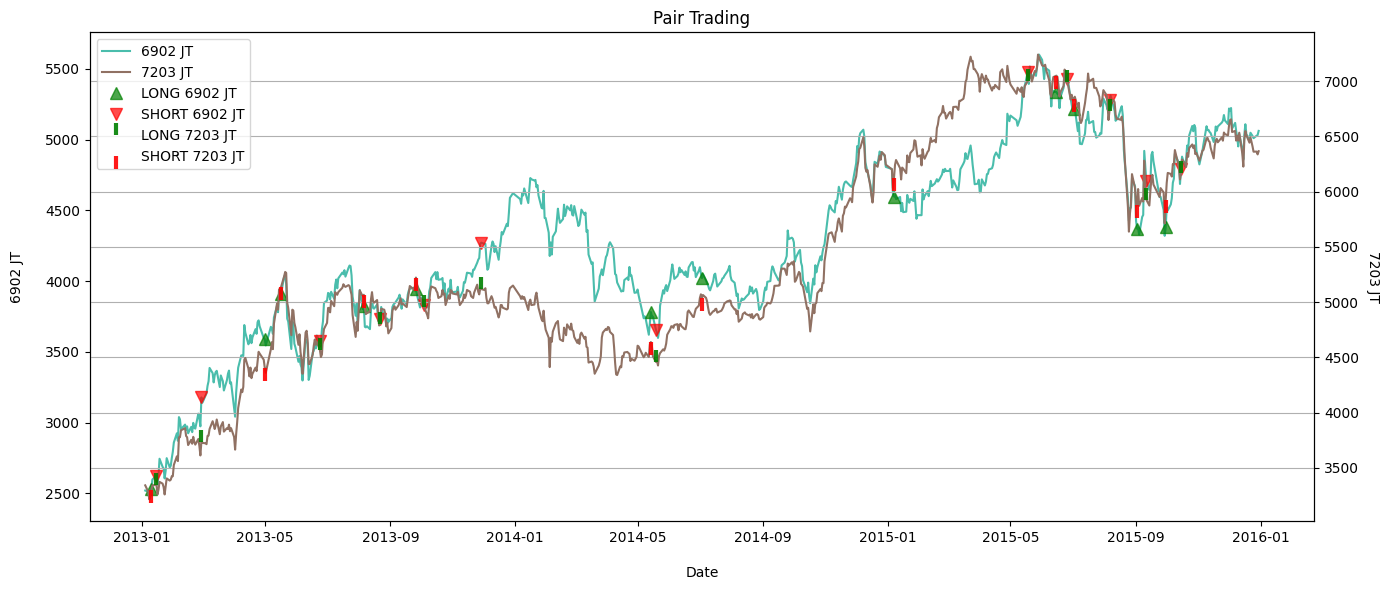

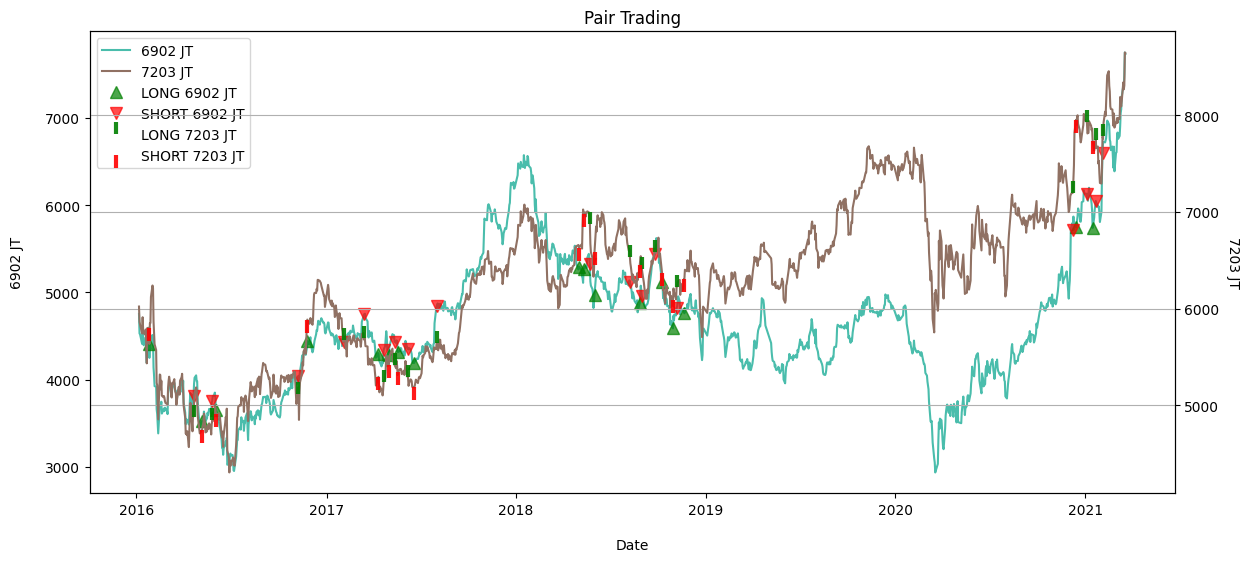

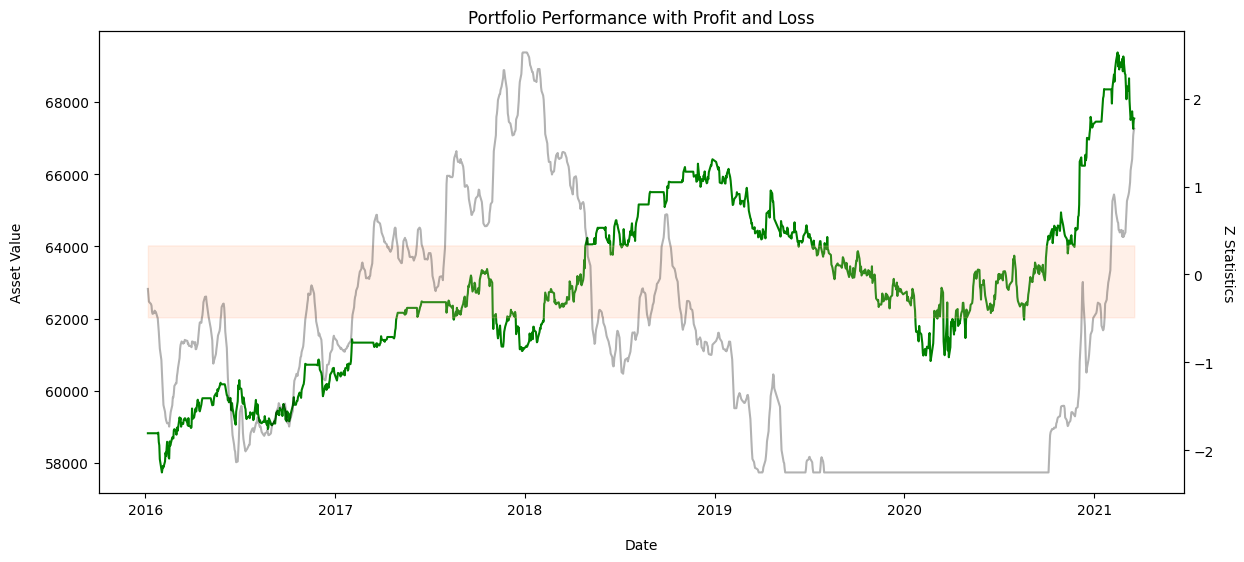

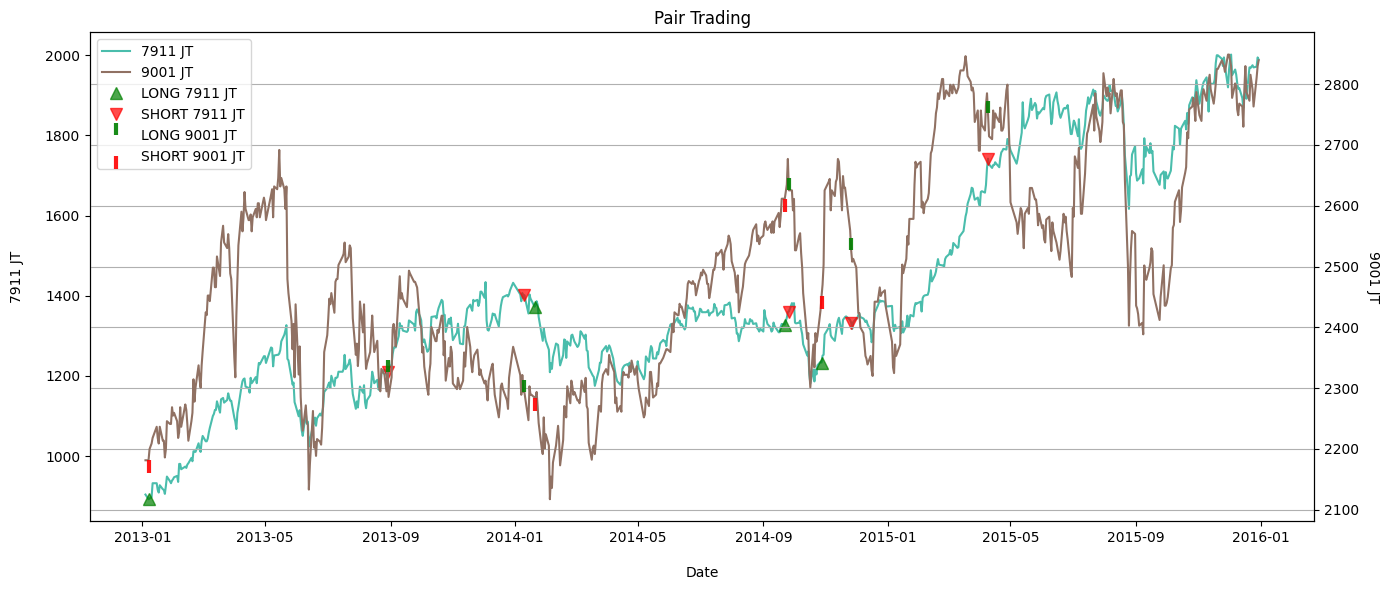

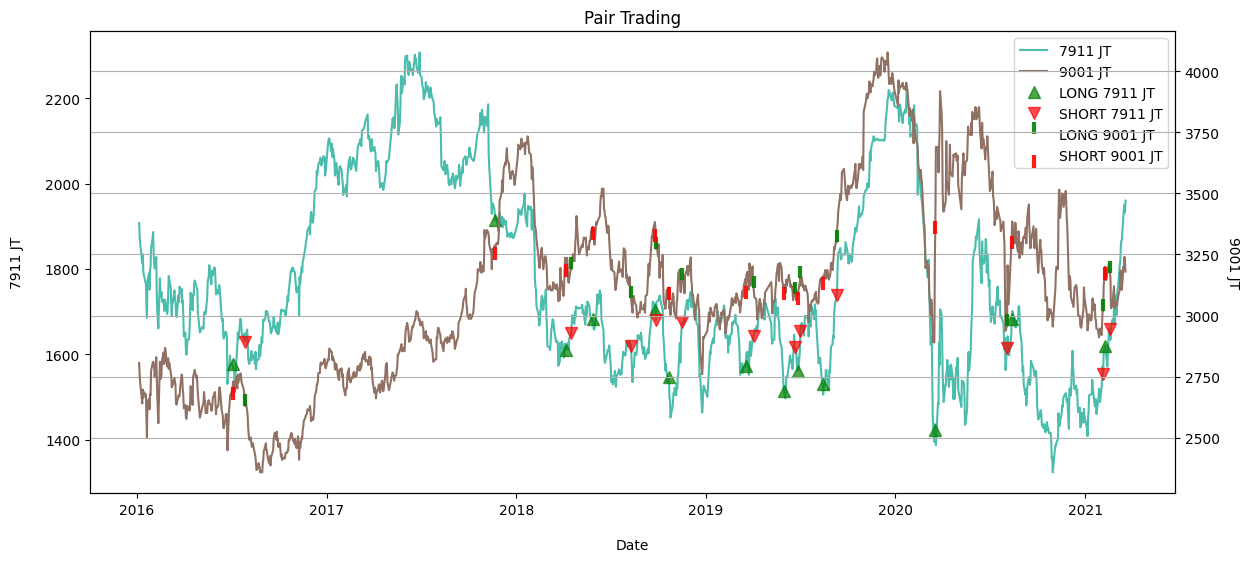

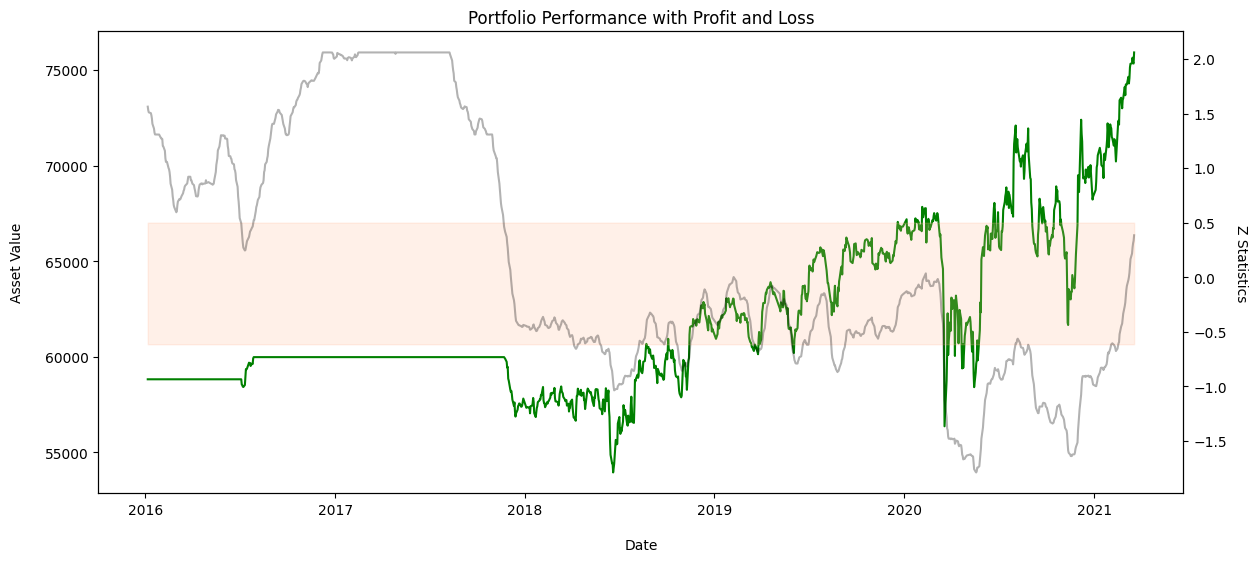

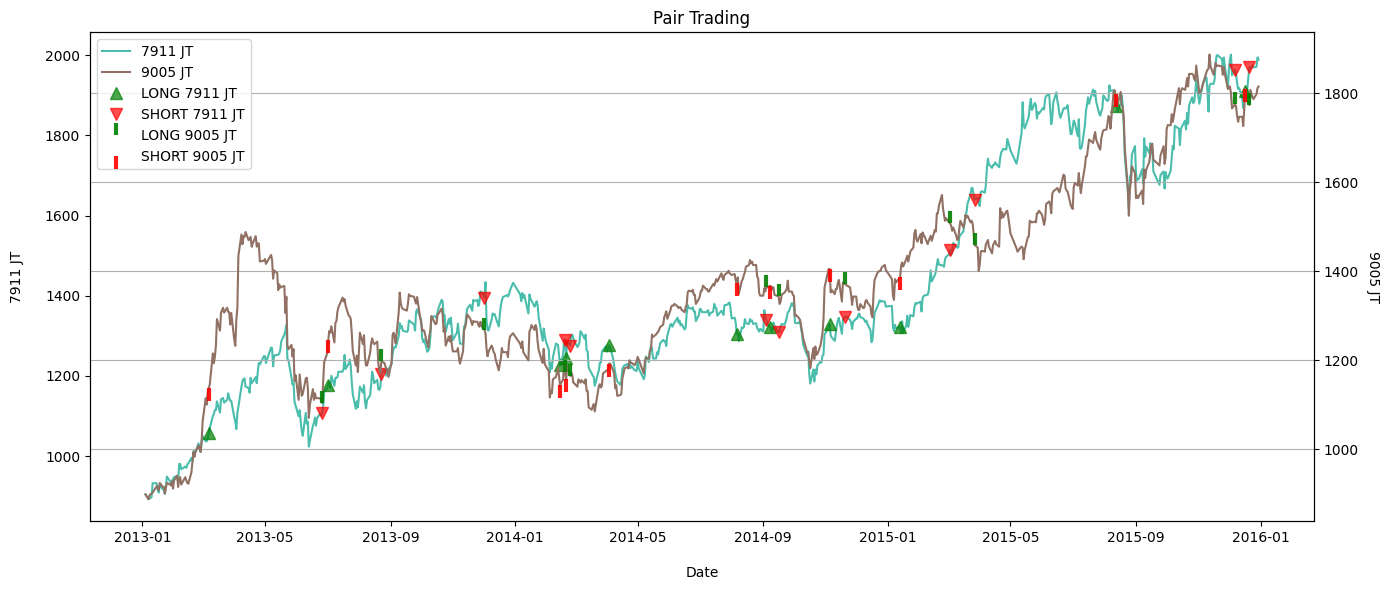

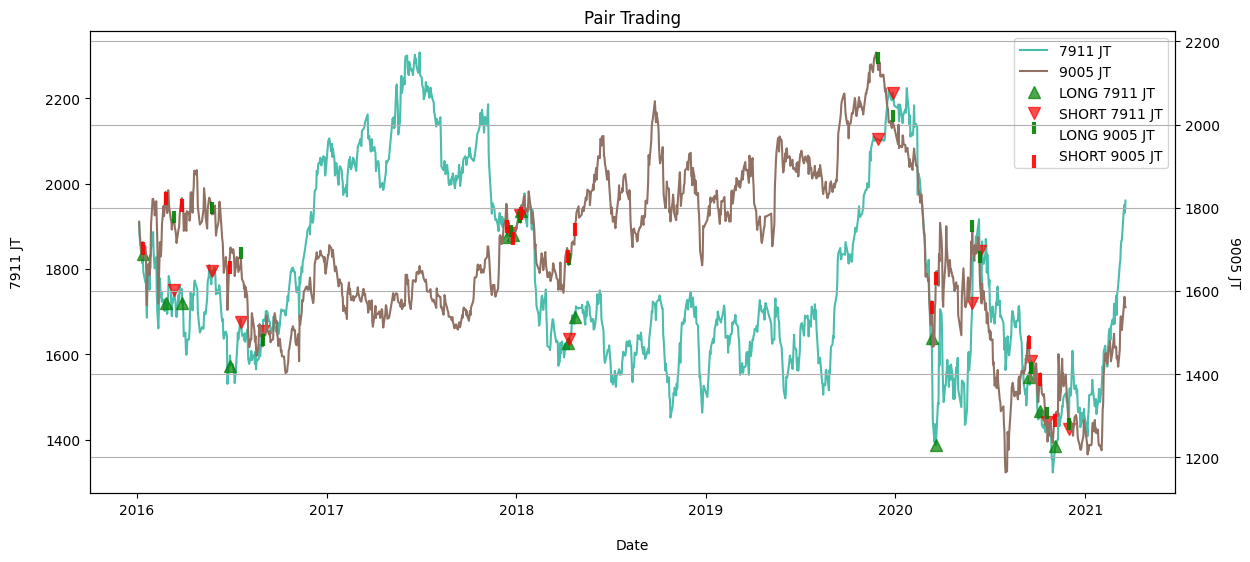

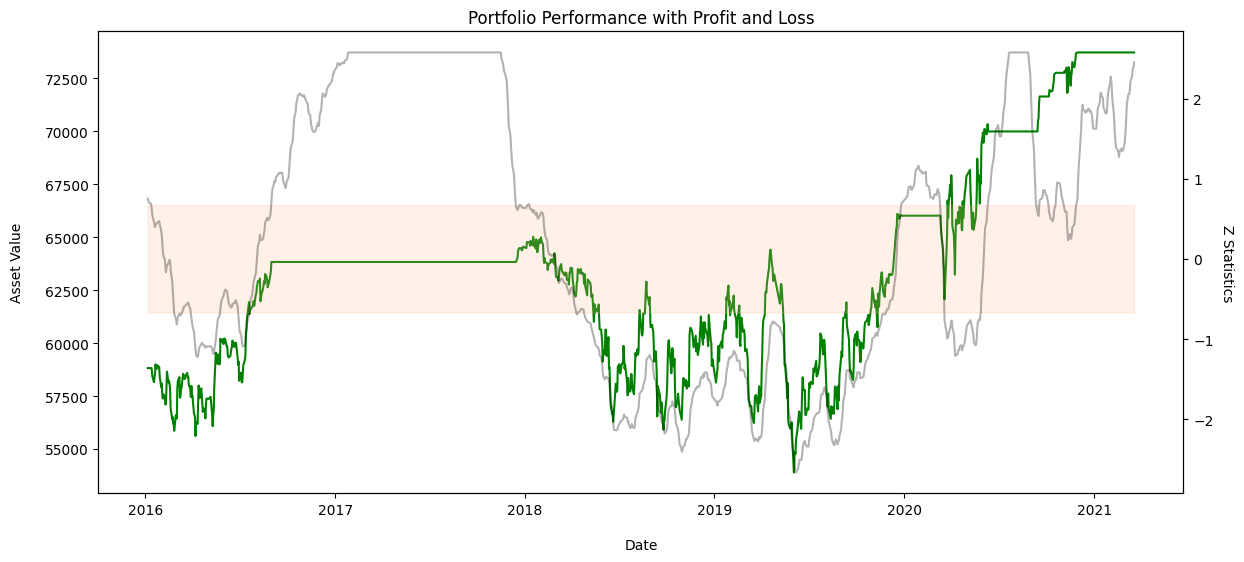

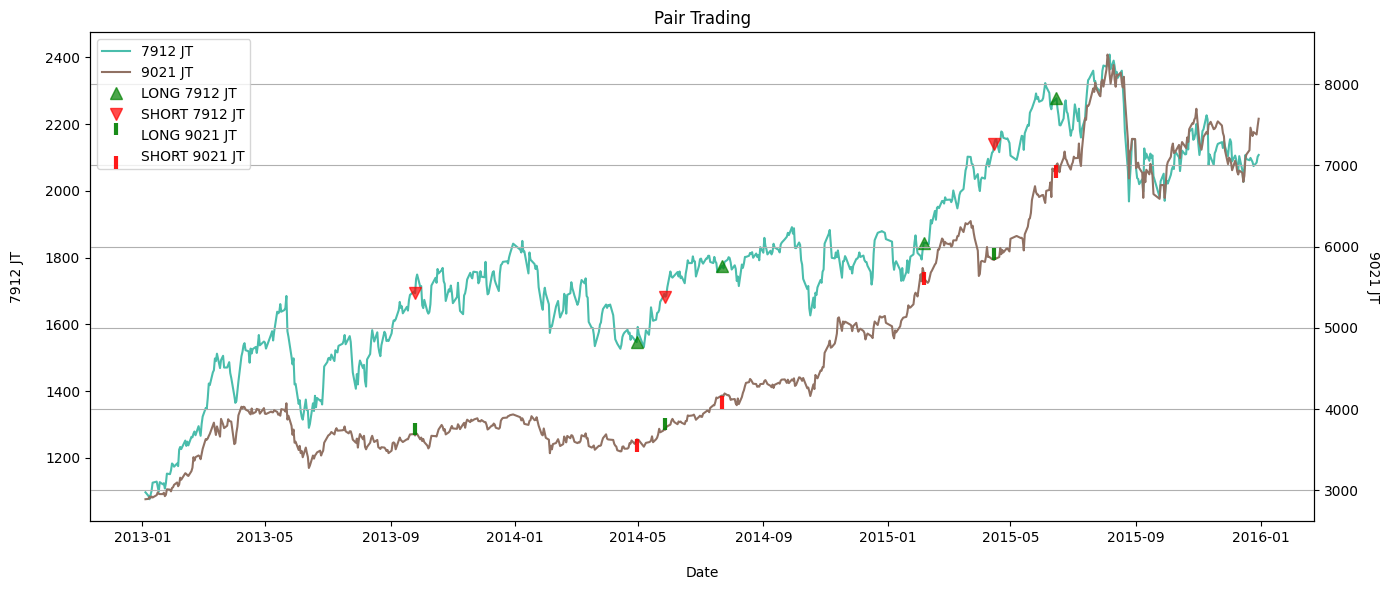

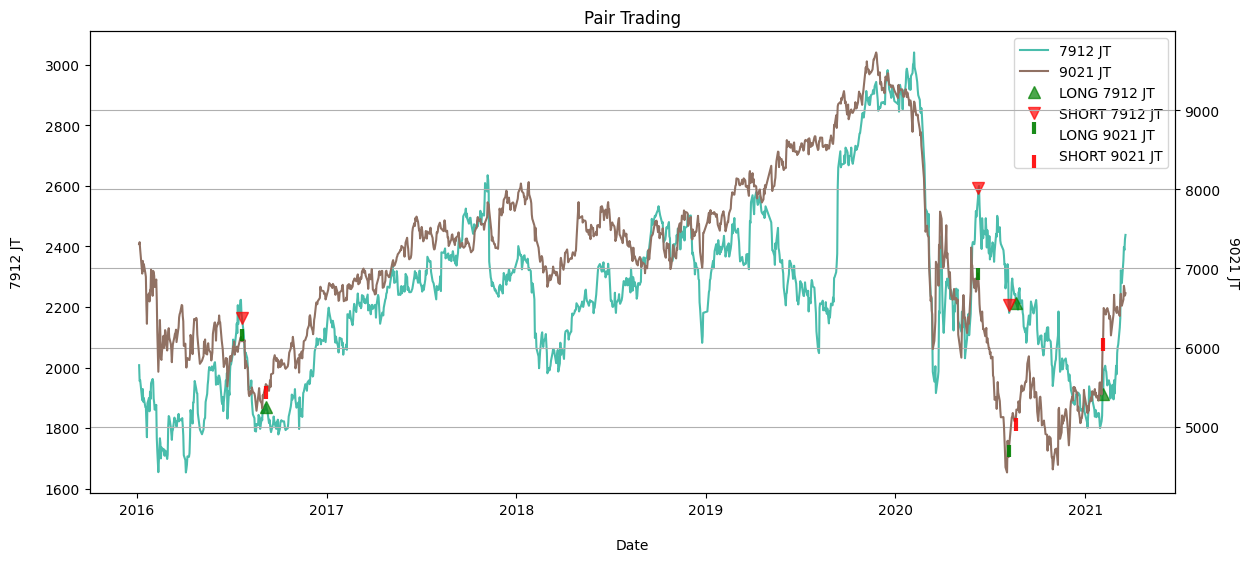

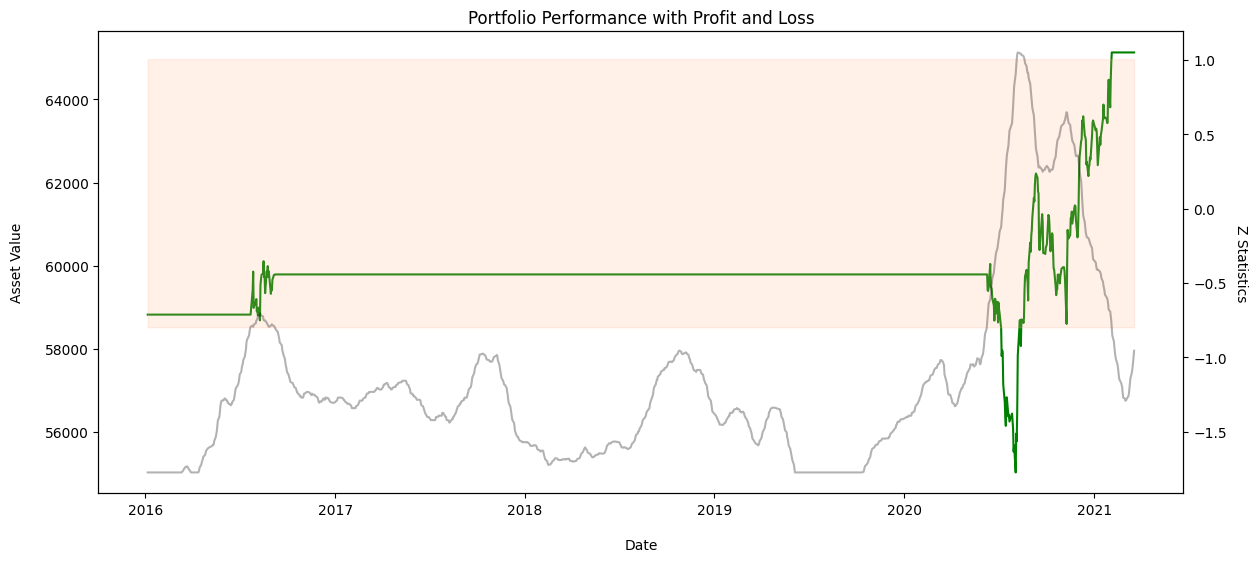

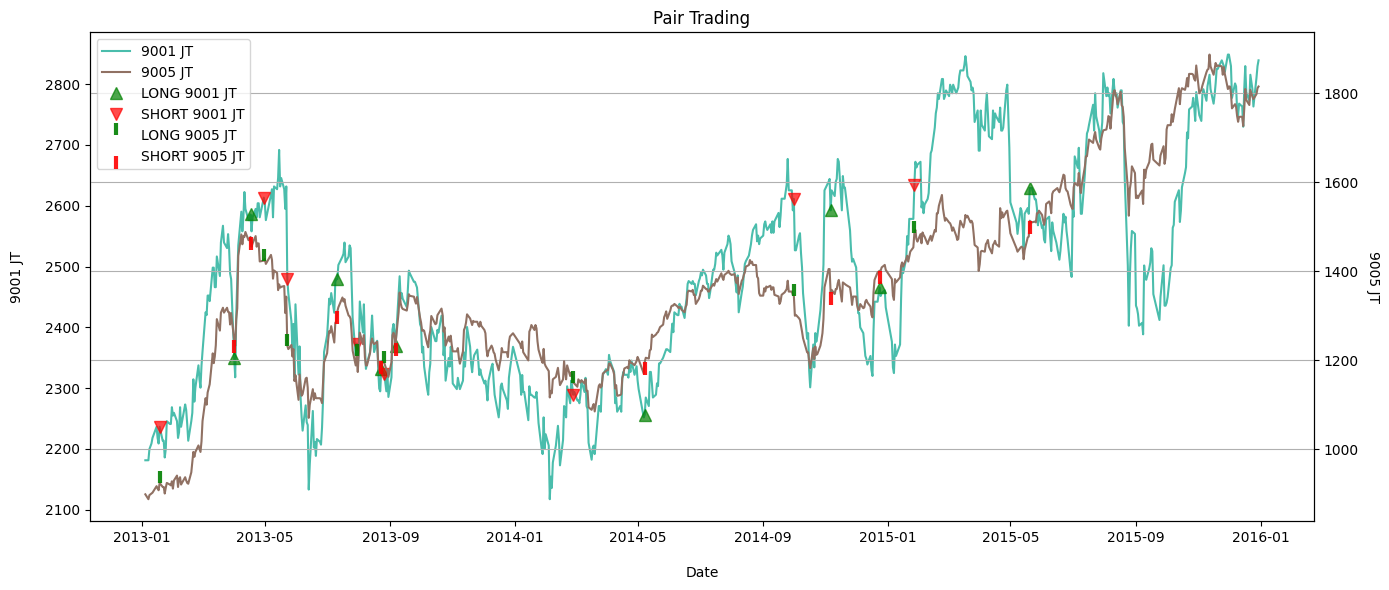

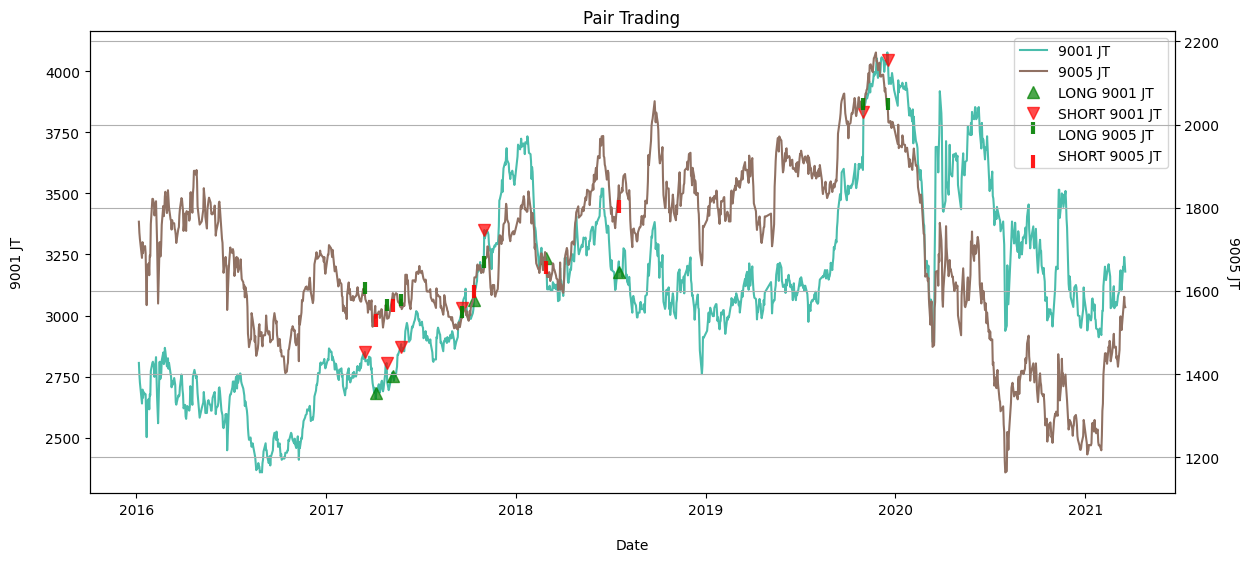

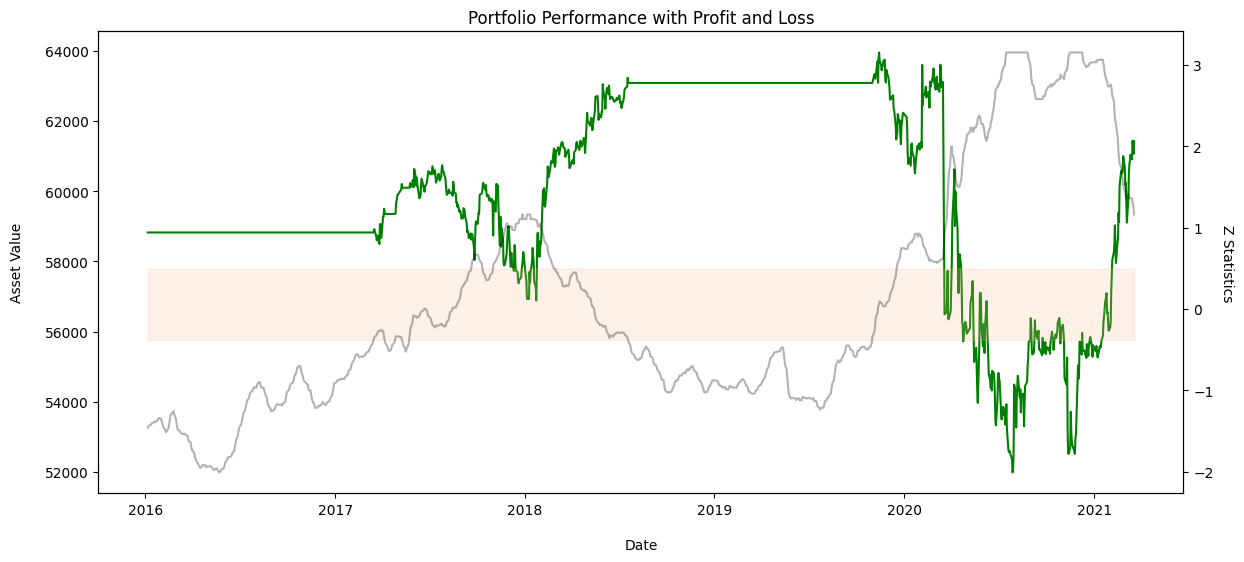

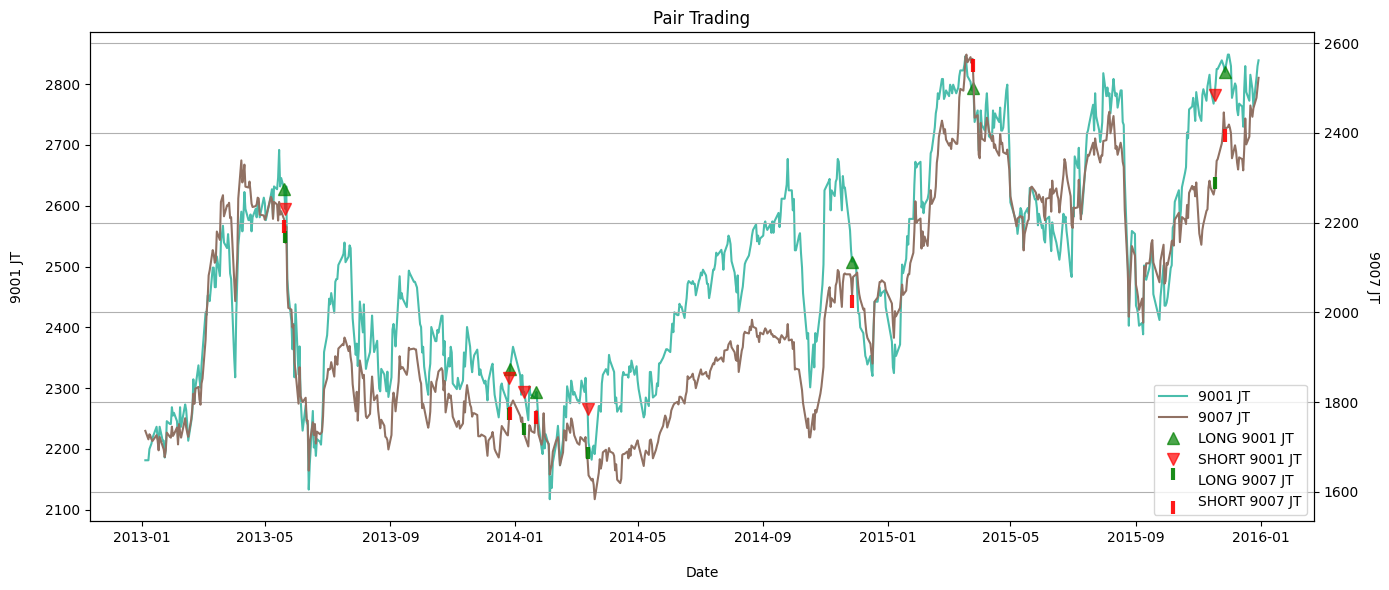

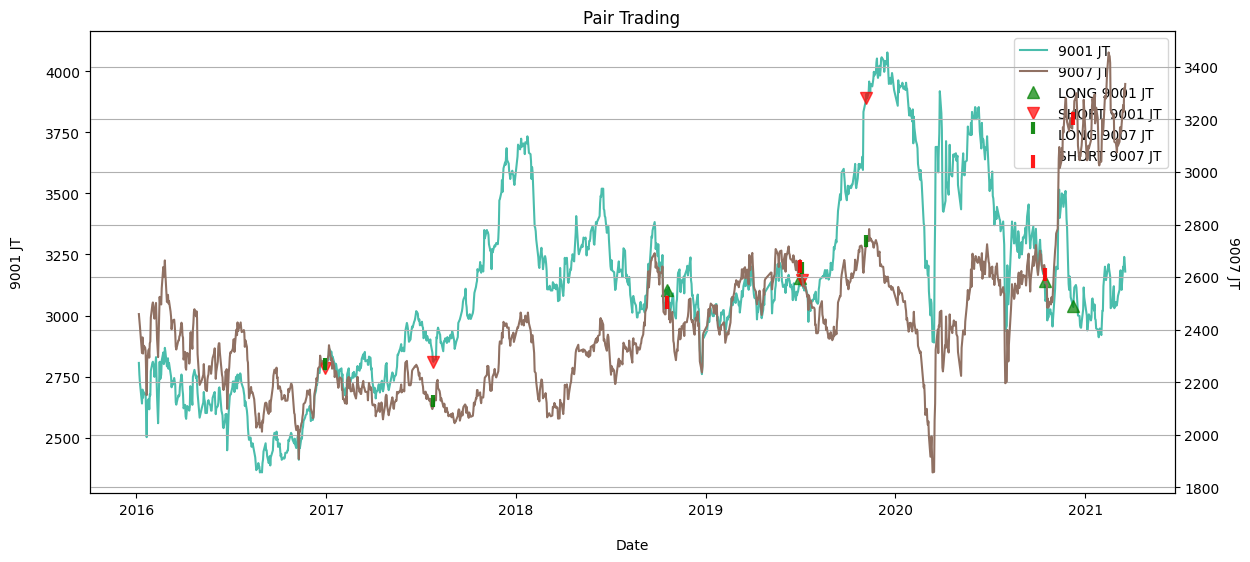

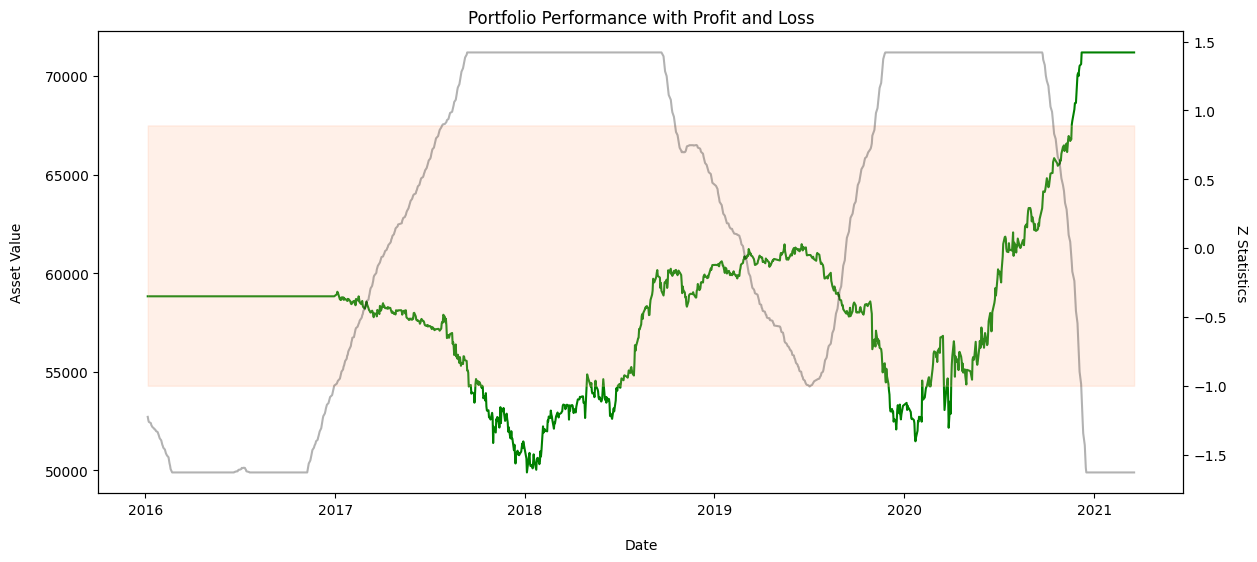

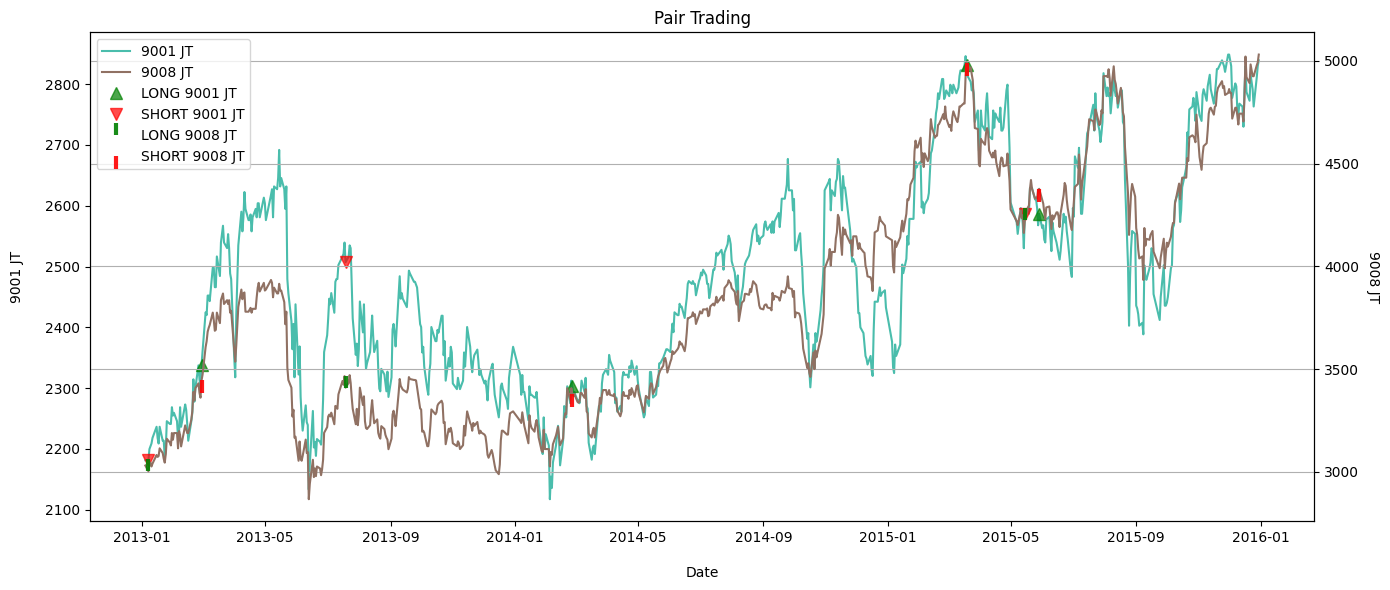

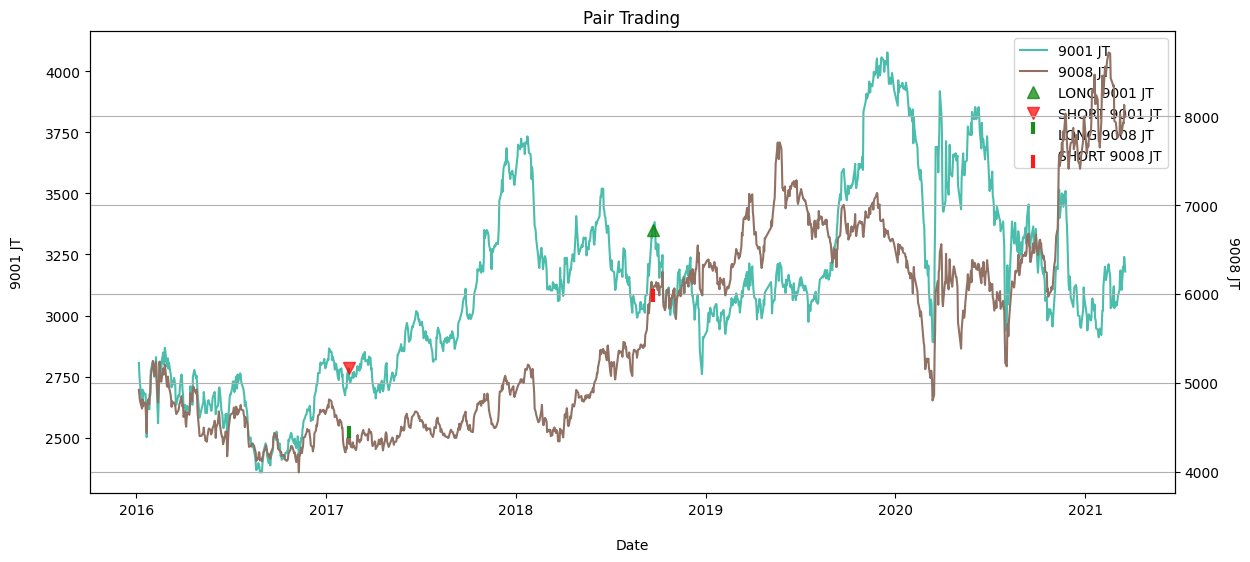

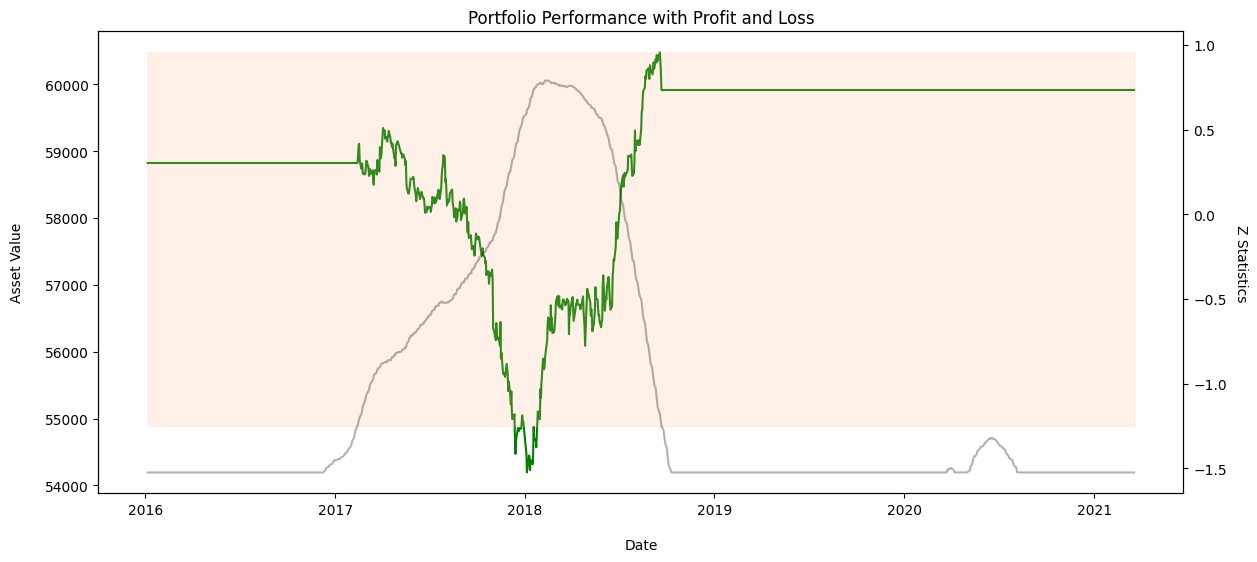

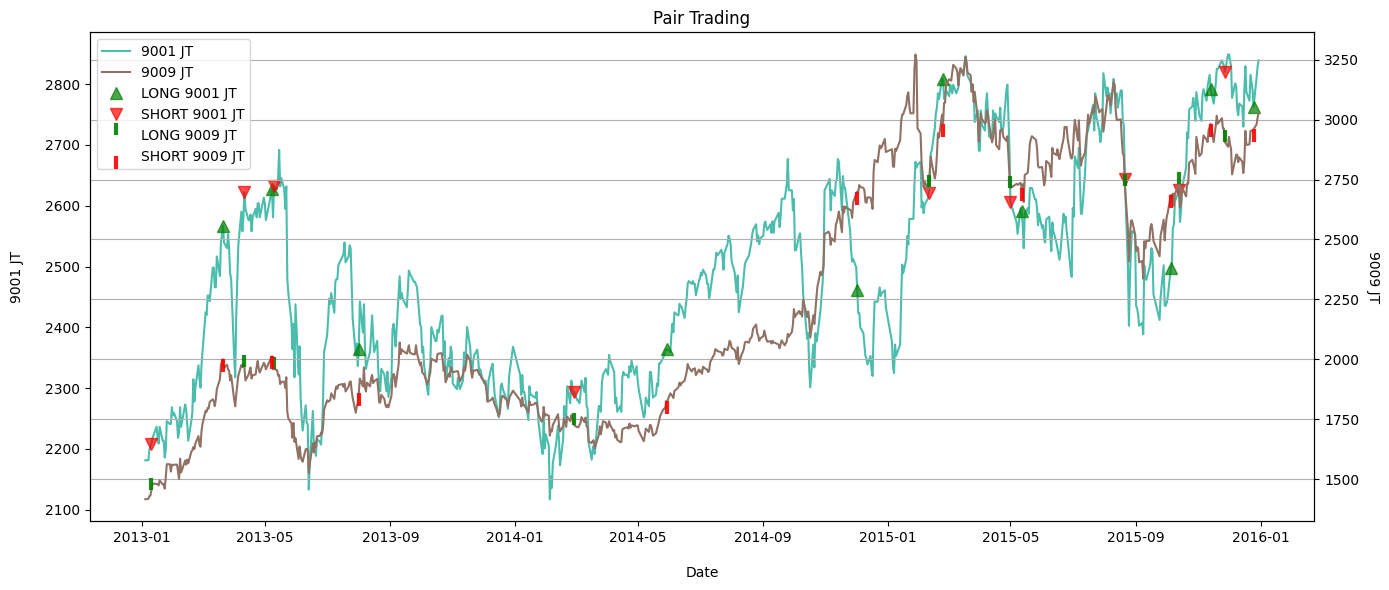

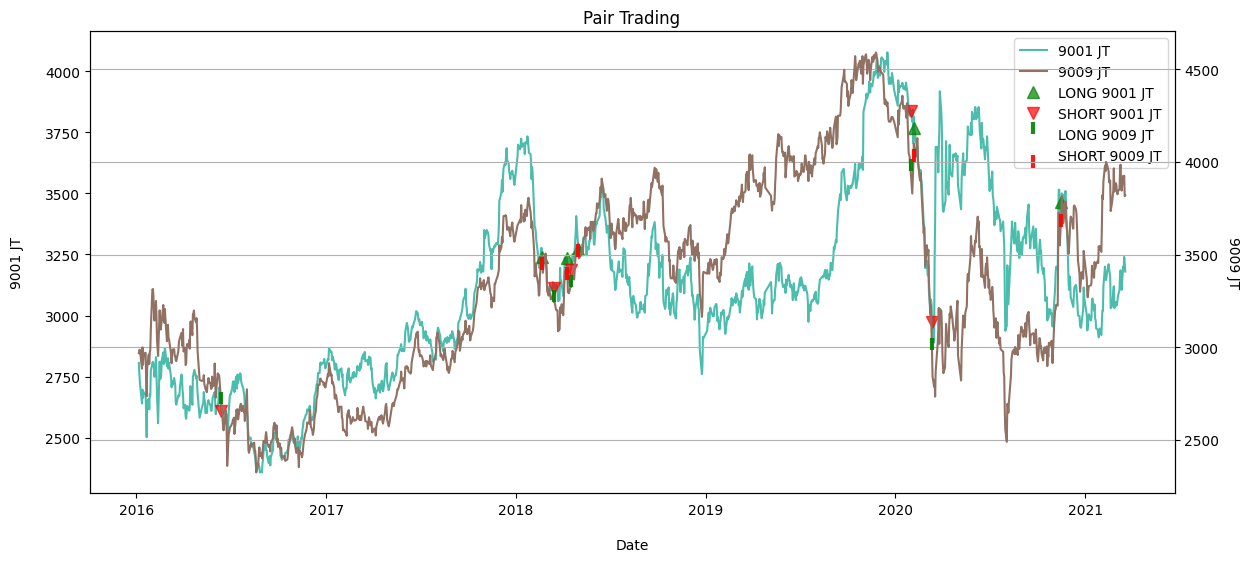

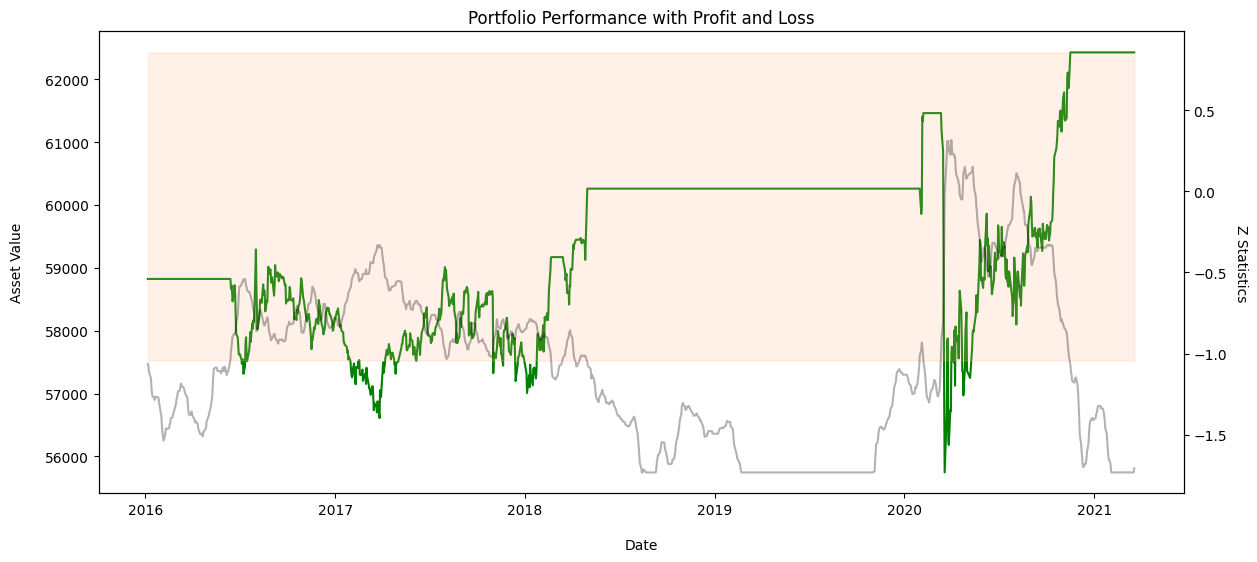

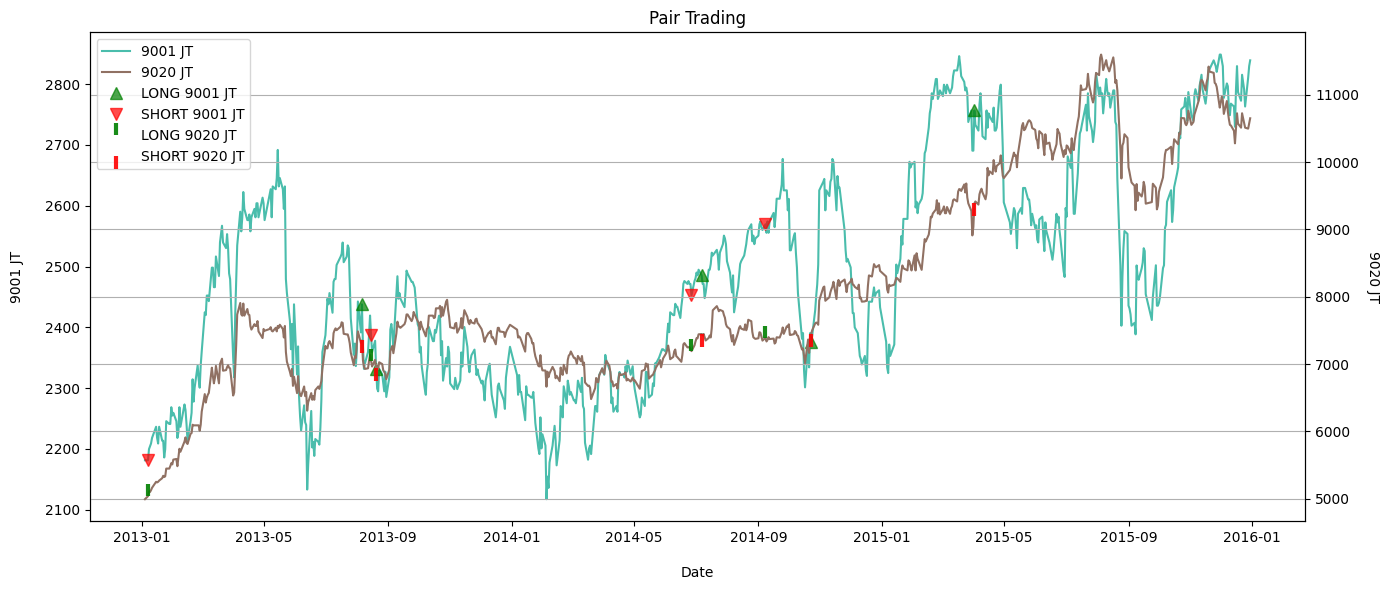

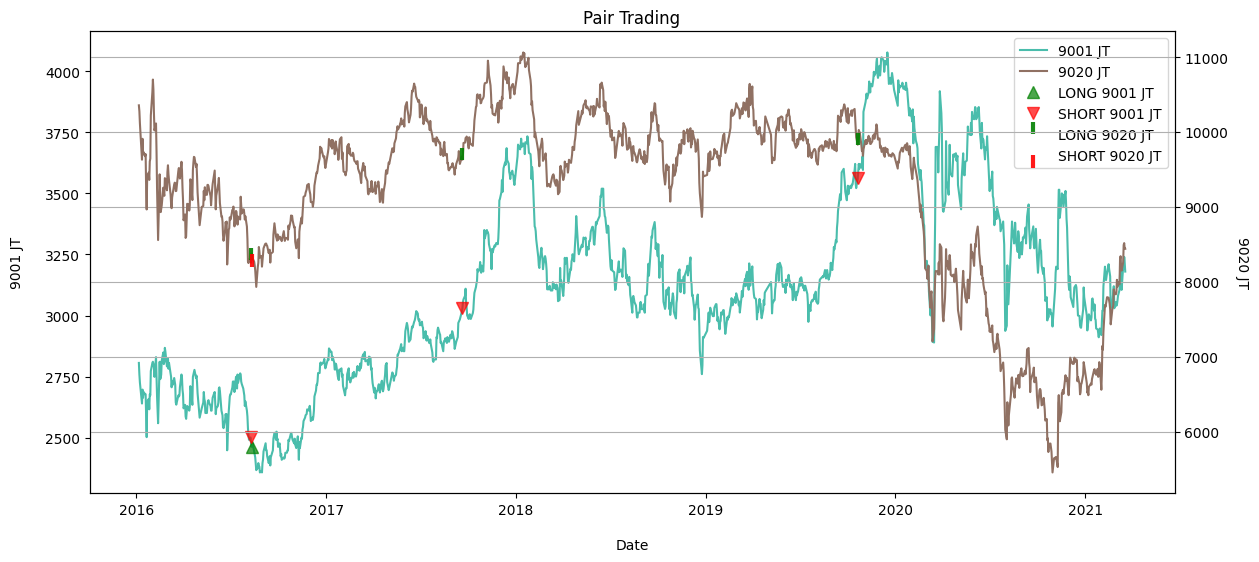

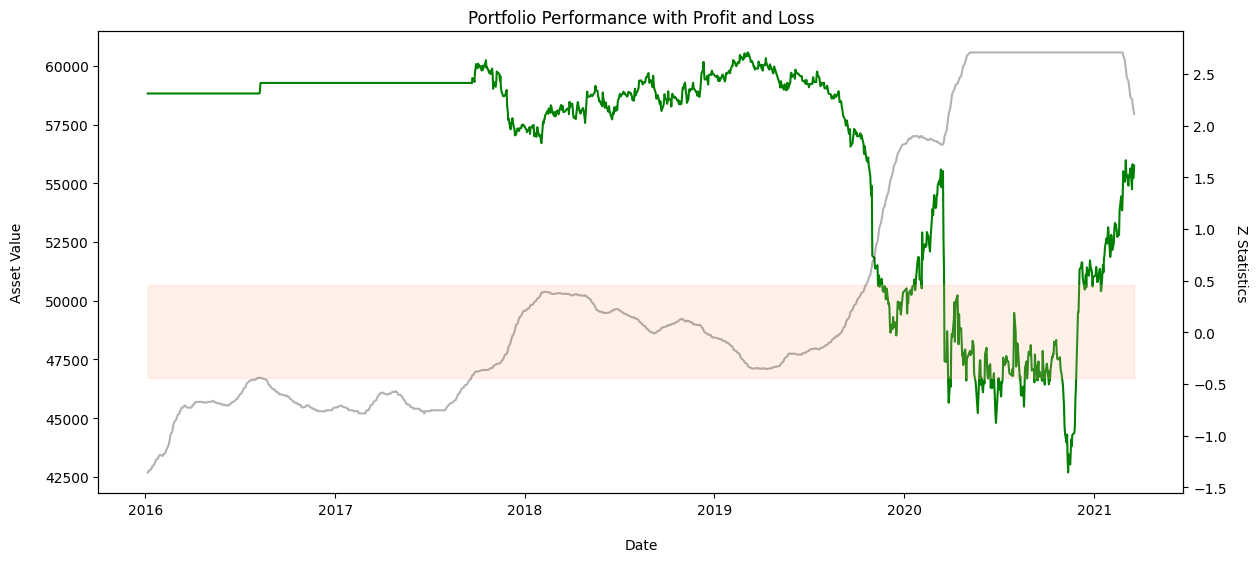

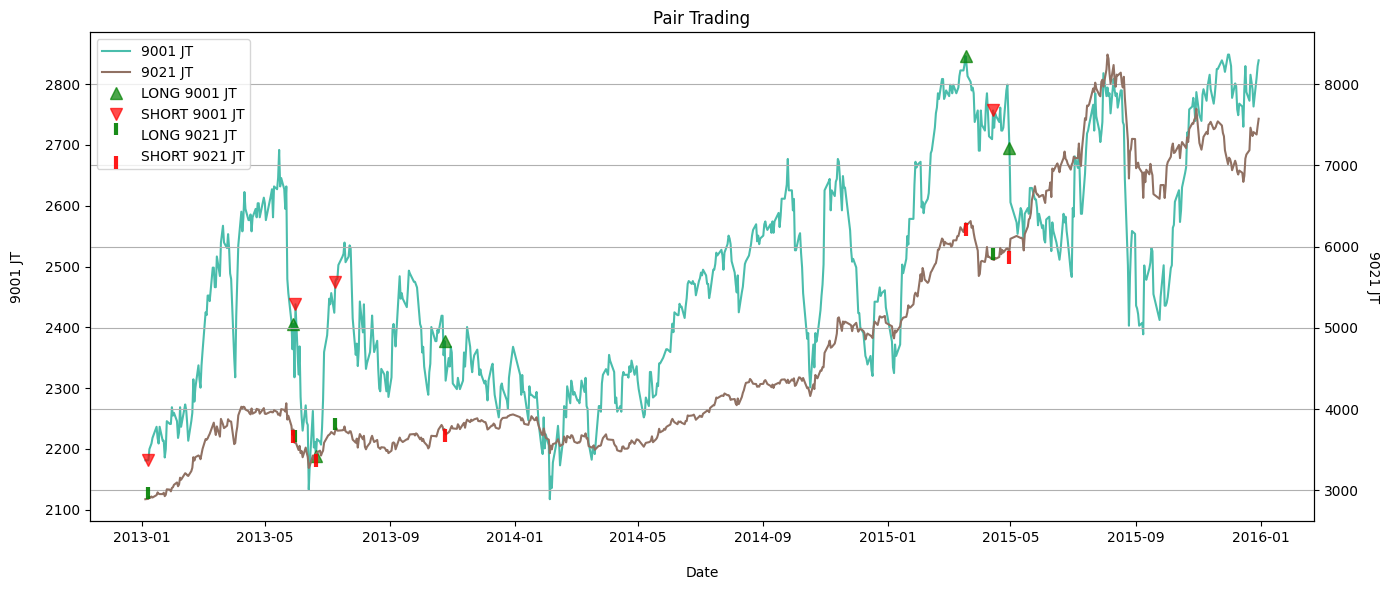

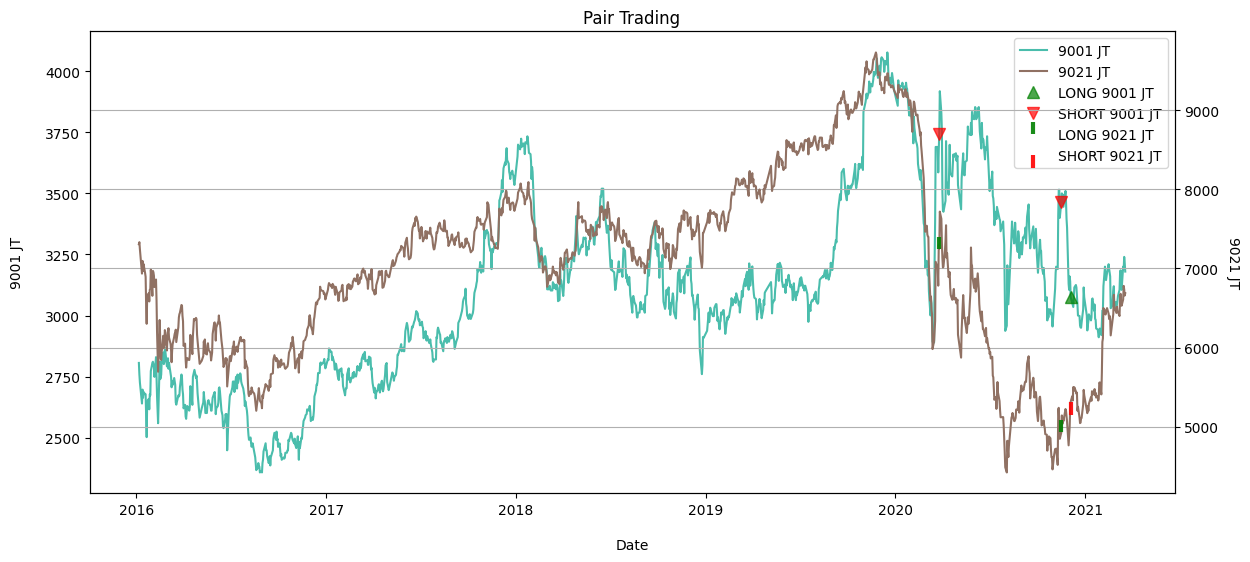

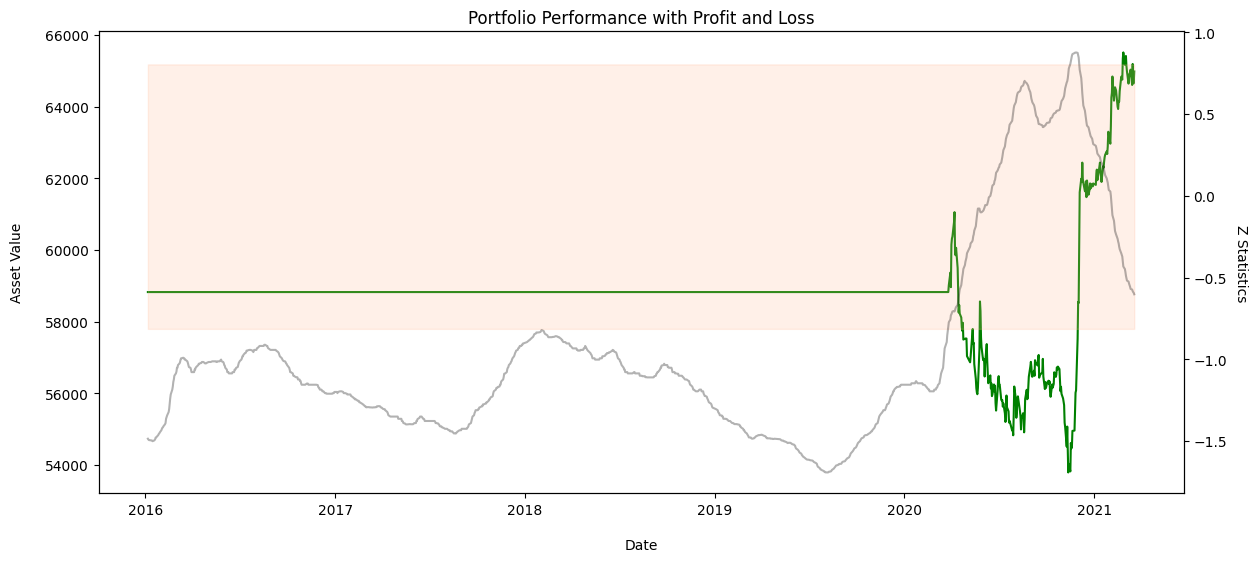

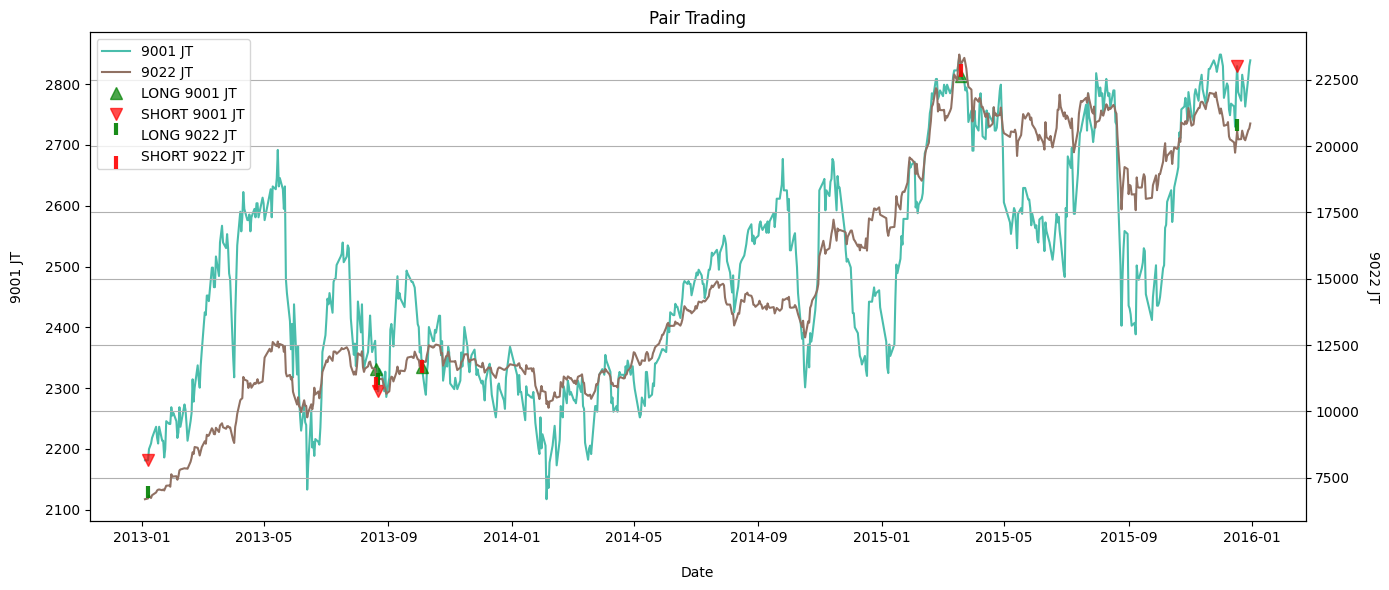

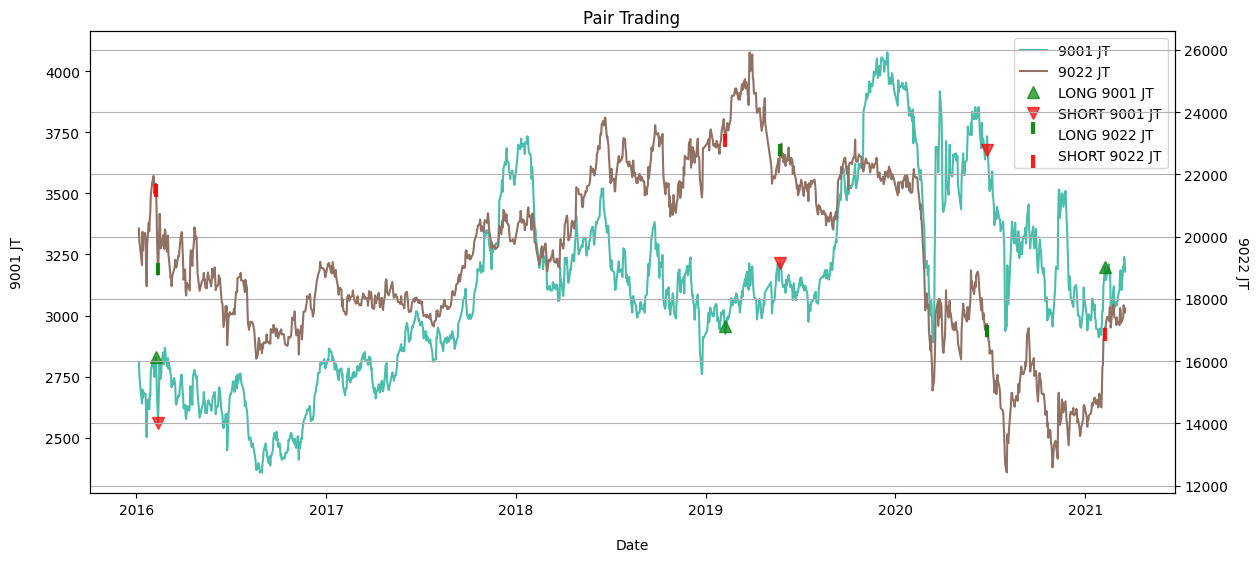

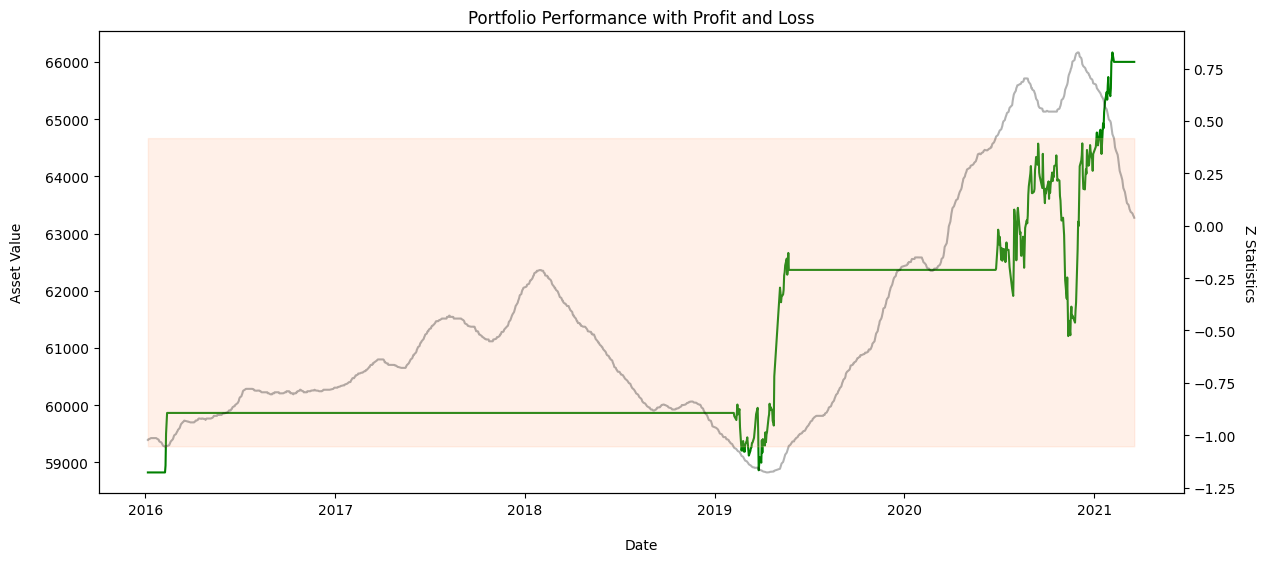

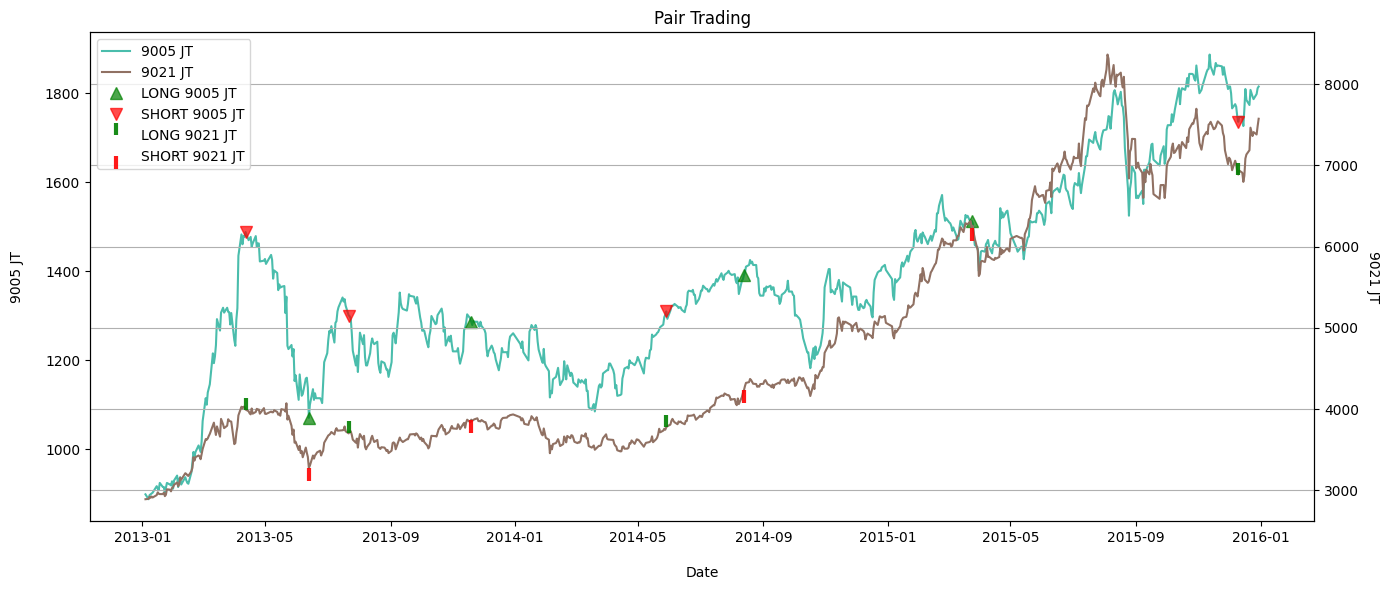

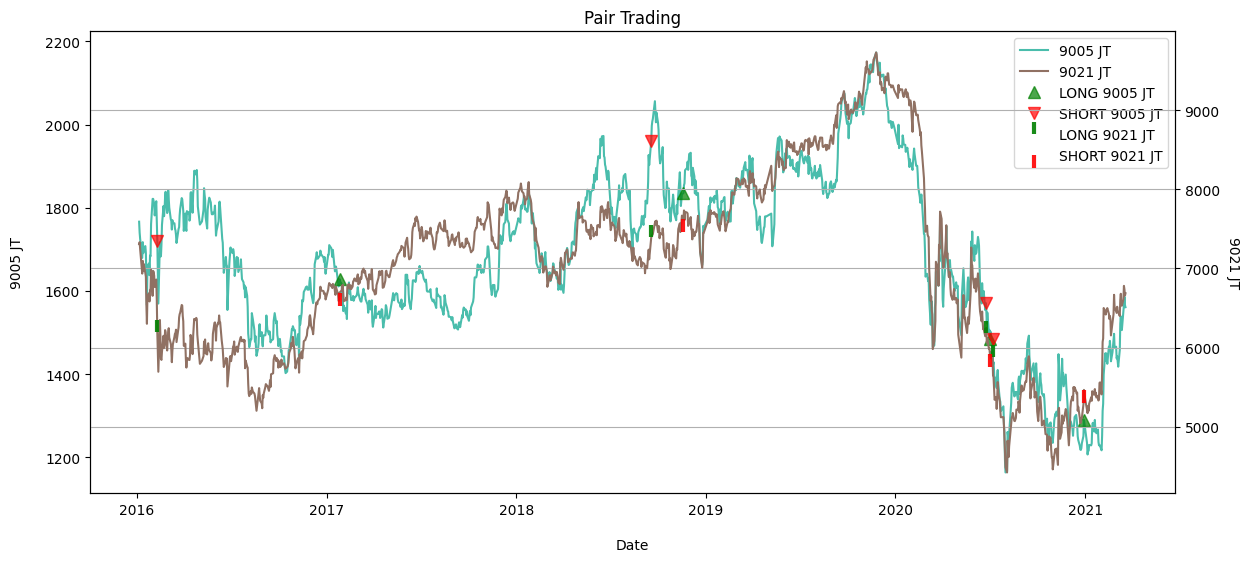

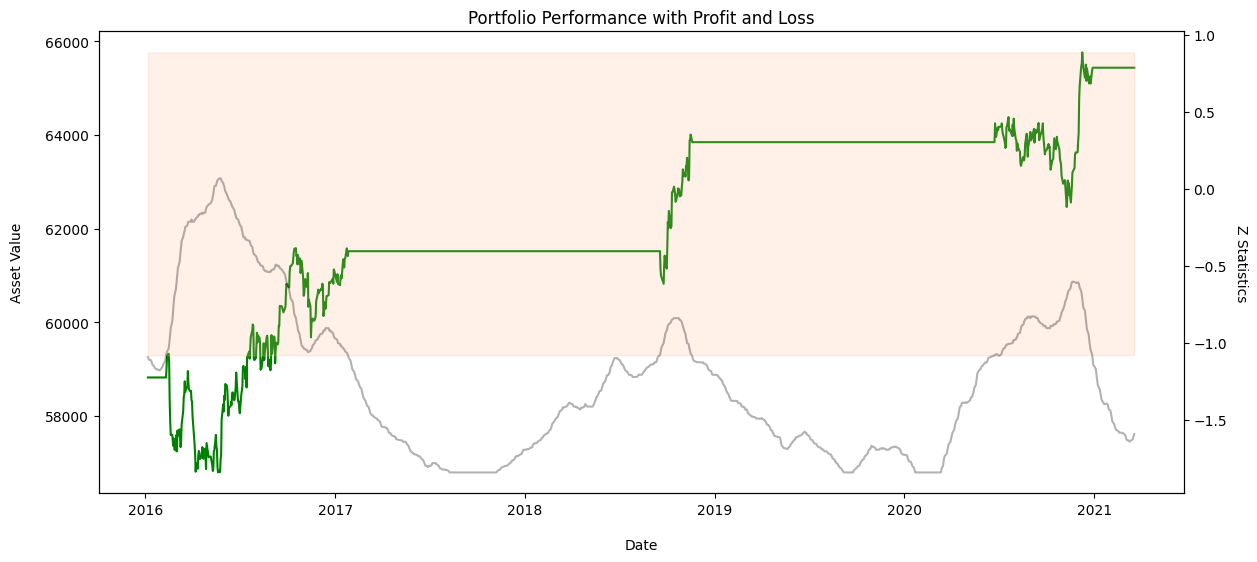

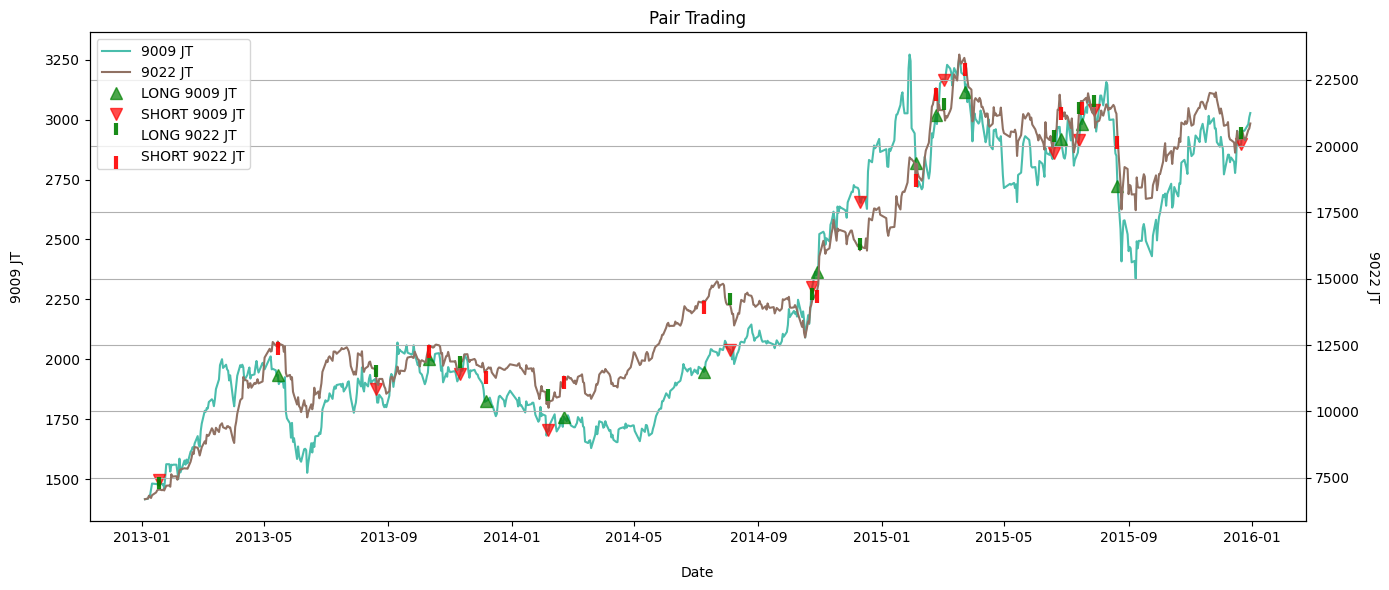

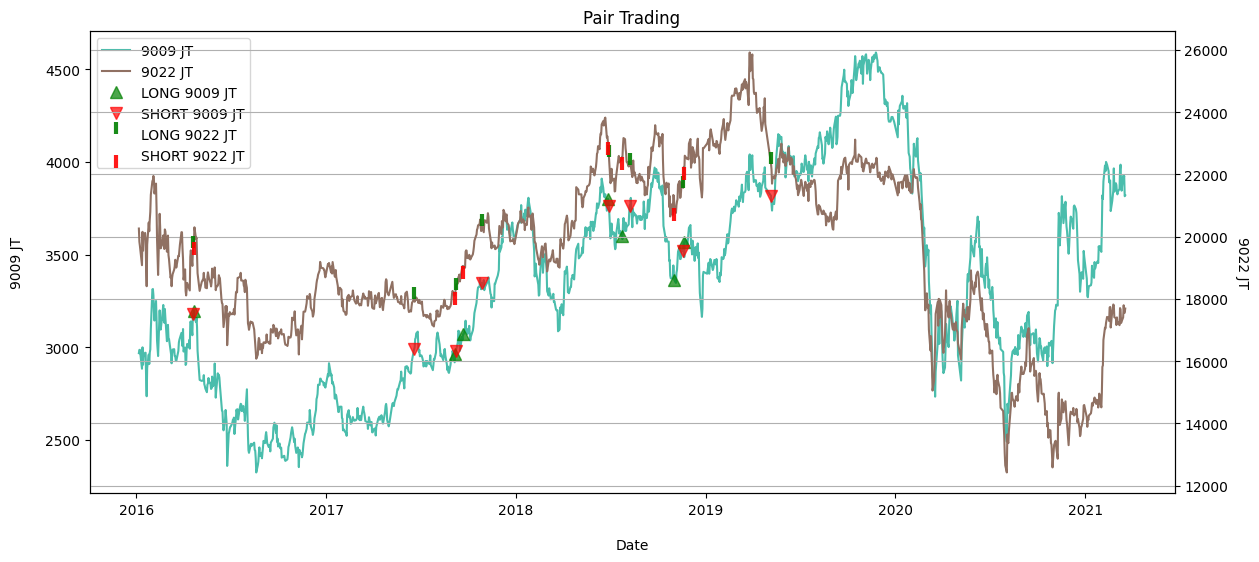

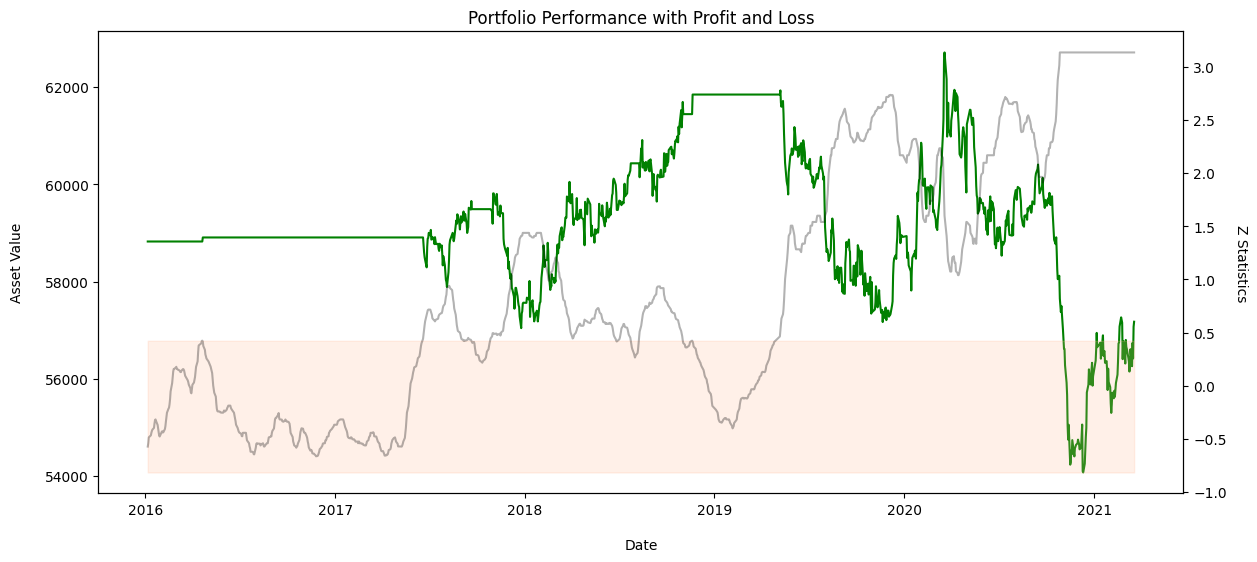

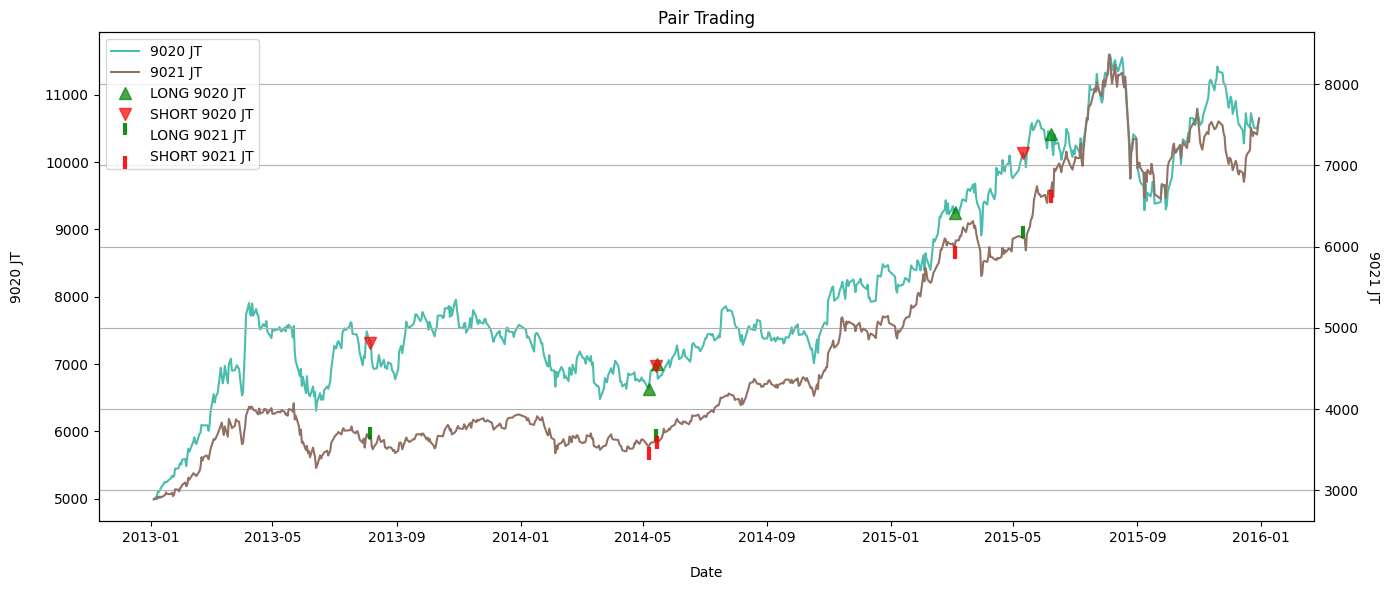

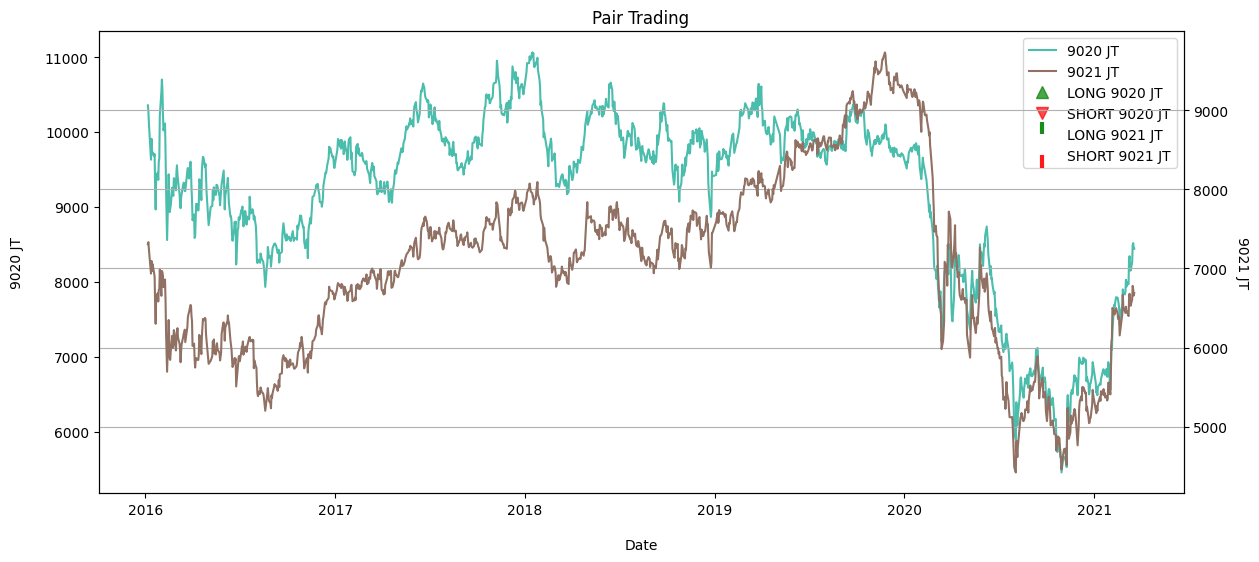

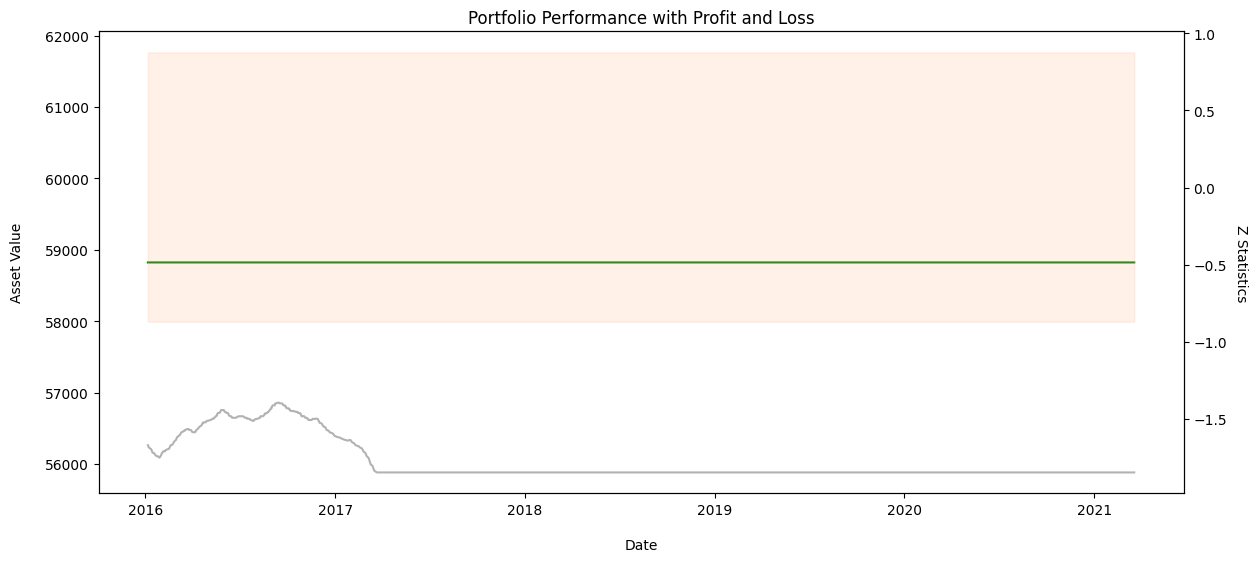

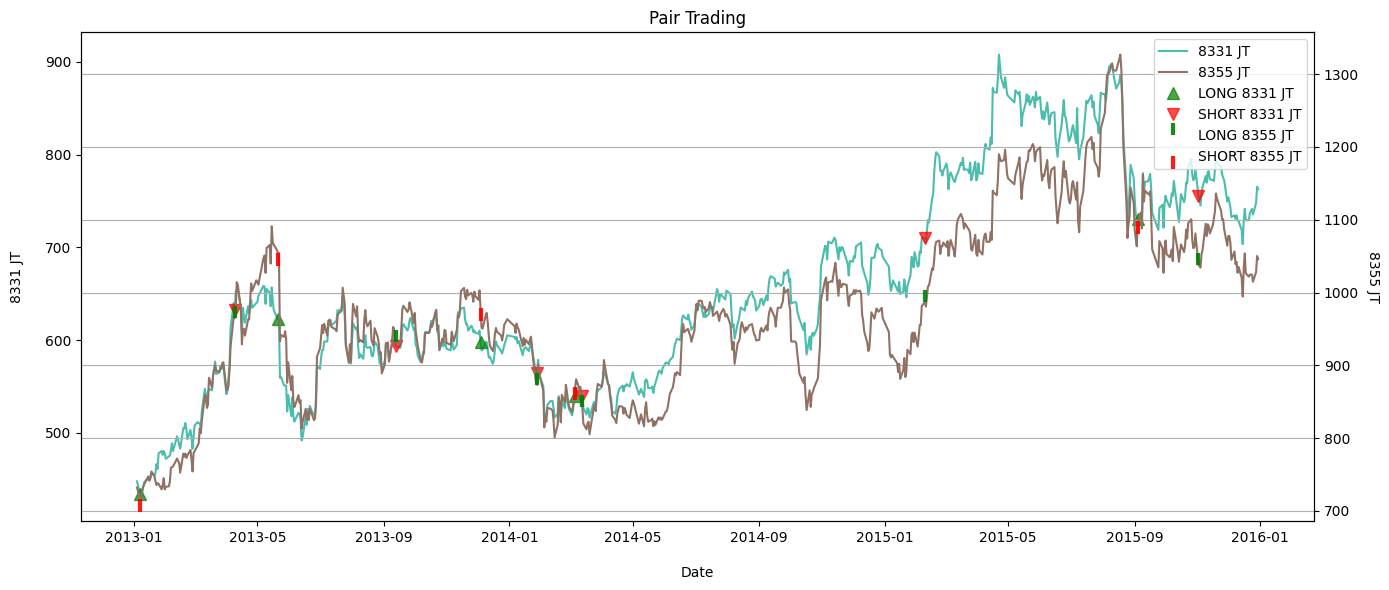

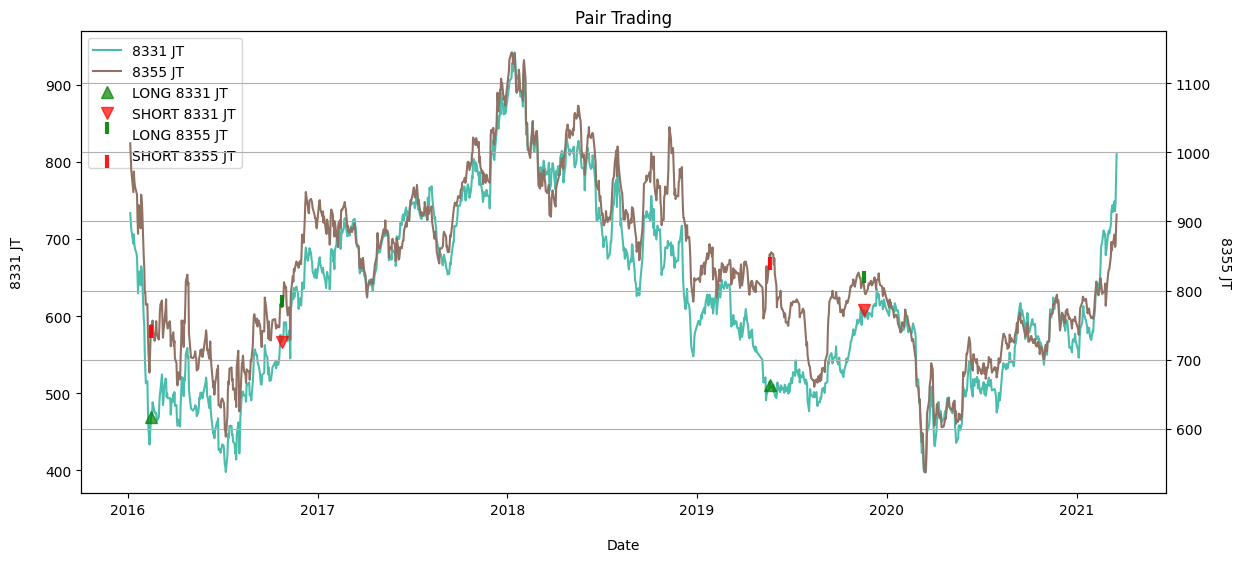

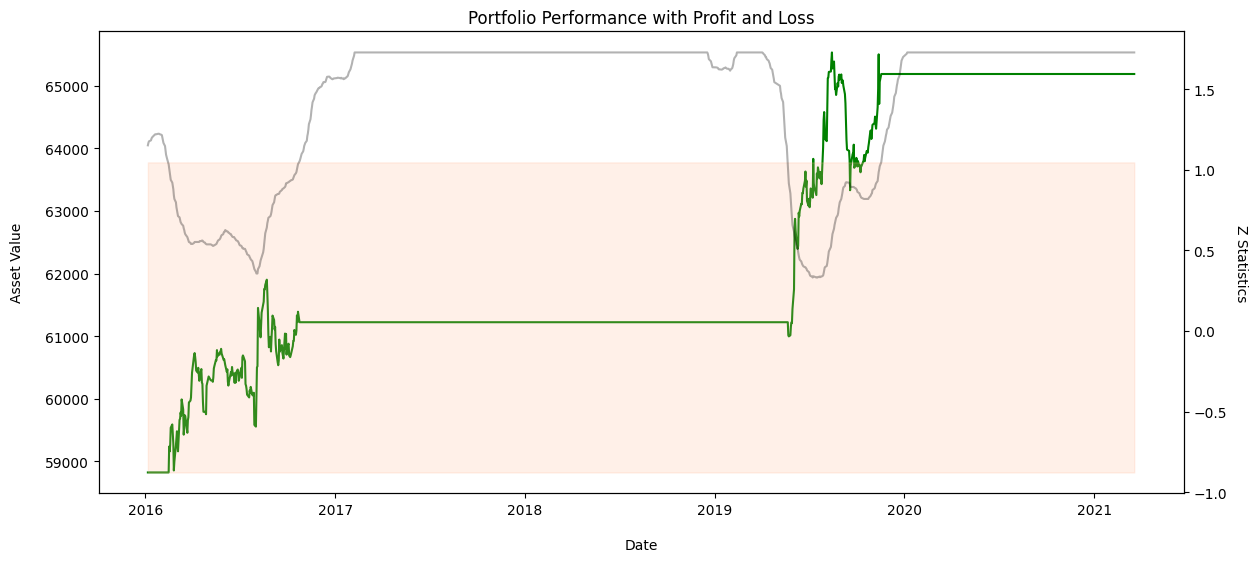

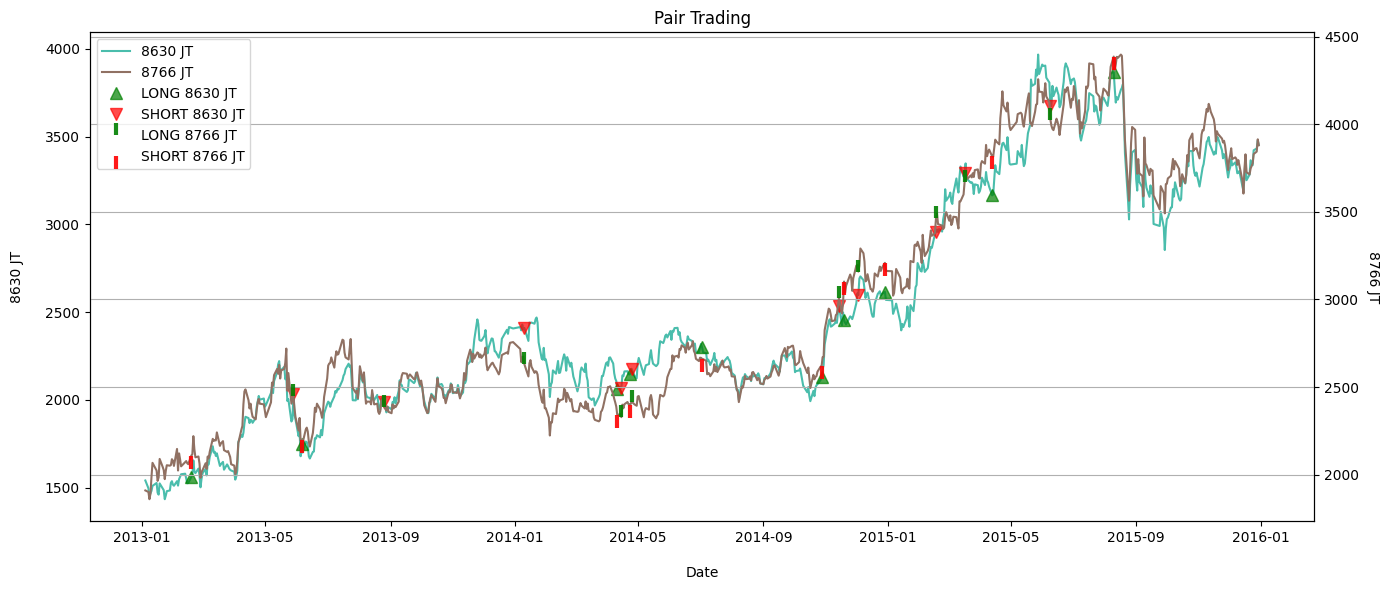

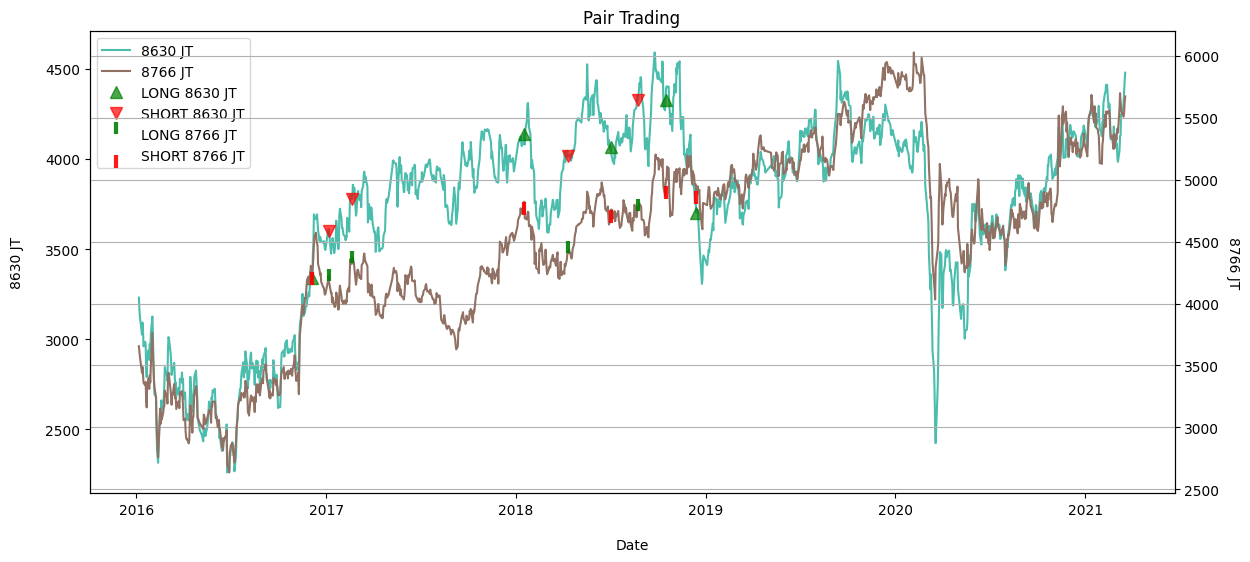

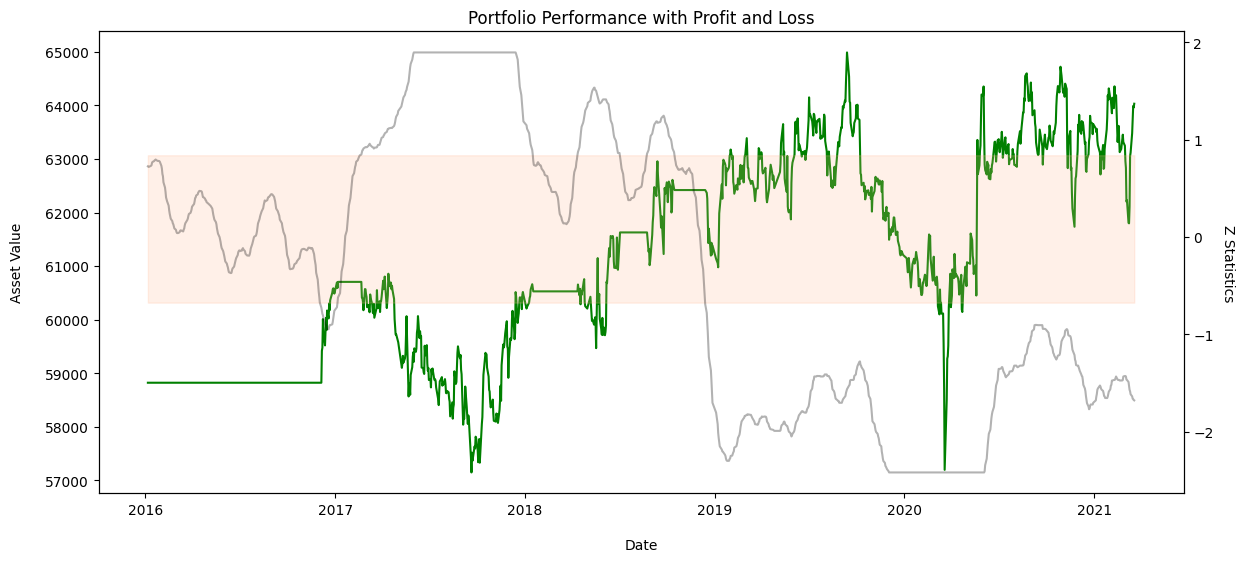

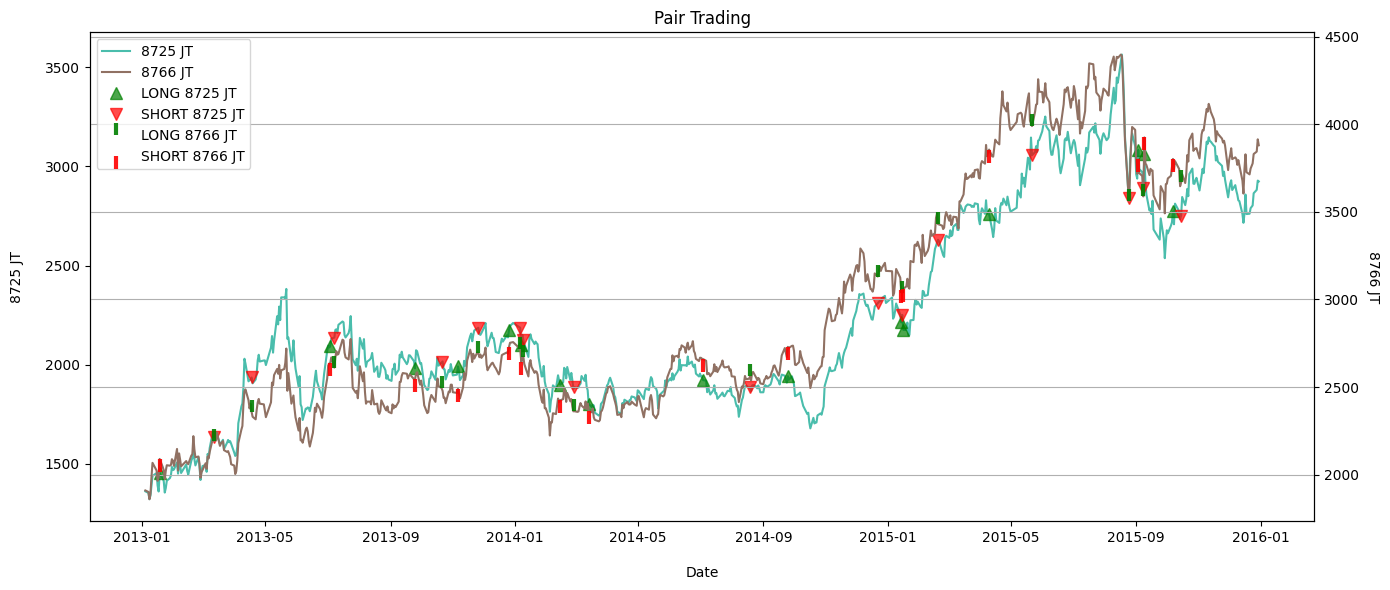

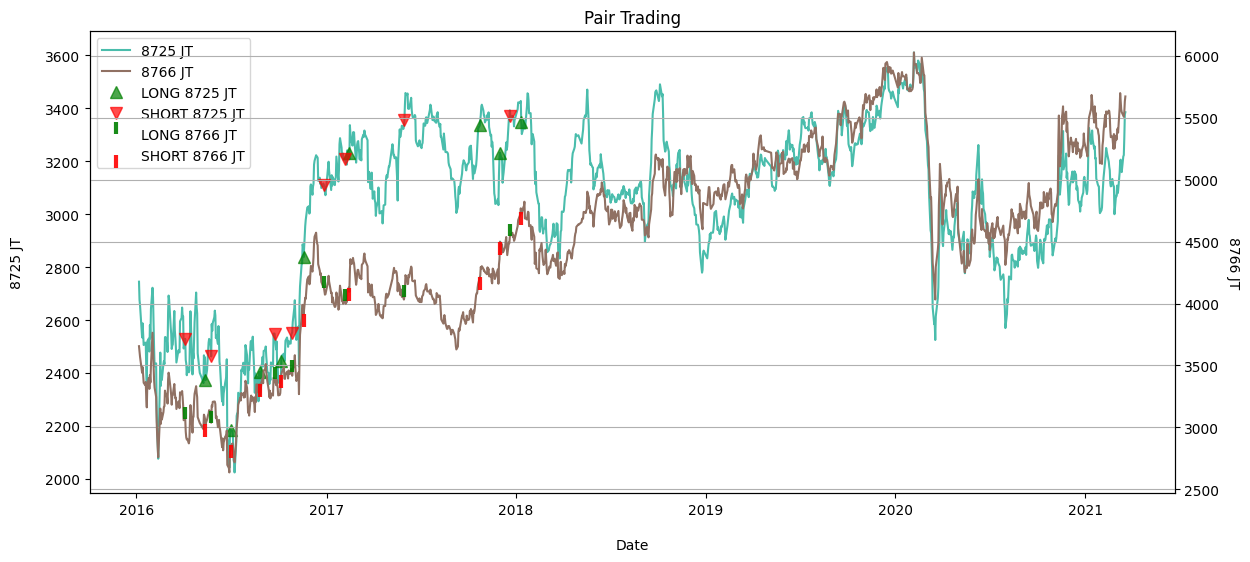

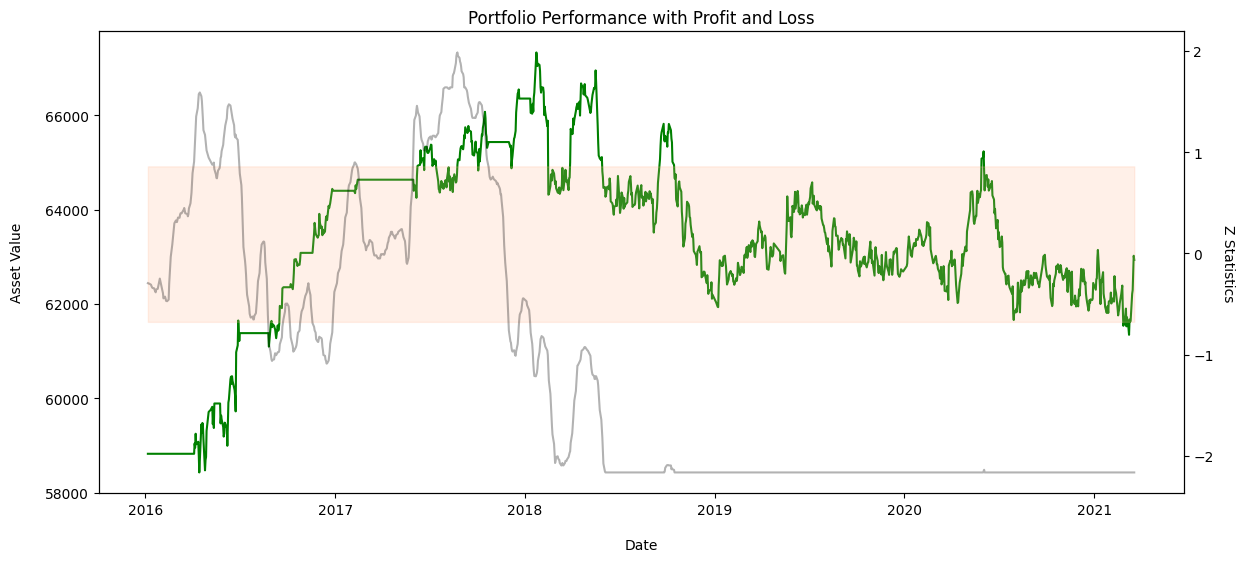

In [389]:
# loop through all_pairs

# use the beta information to compute portfolio weights

Total_capital = 1000000

for idx, pair in enumerate(all_pairs):
    stock1 = pair[0]
    stock2 = pair[1] 

    pair_capital = Total_capital / len(all_pairs) # equal distribution of capital among pairs
    filtered_closing_data = {'train_data' : train_collated_price_df, 'test_data' : test_collated_price_df}

    model = Backtesting(filtered_closing_data, stock1, stock2,allocation = pair_capital,signal_effectiveness_metric='risk_reward',use_percentile=True)
    model.generate_trading_signal()
    model.evaluate_signals()
    model.plot_signals()
    model.backtest()
    model.plot_portfolio_performance()
    model.obtain_performance()


    # collate total portfolio value
    if idx == 0: # first iteration
        total_portfolio = model.portfolio['total asset']
    else:
        total_portfolio += model.portfolio['total asset']


# compute overall porfolio performance and give metrics

final_portfolio = total_portfolio.iloc[-1]

total_returns = total_portfolio.pct_change()
total_assets_value = final_portfolio

mdd = max_drawdown(total_returns) # I will need to convert to percentage myself
shp_rat = sharpe_ratio(total_returns, annualization = 245) # 245 for this data
ann_vol = annual_volatility(total_returns)
sortino = sortino_ratio(total_returns)
cagr_estimate = cagr(total_returns)


print("======================  Overall Performance Metrics  ========================")
print('Final portfolio value: {0:.2f}'.format(total_assets_value))
print('Compound Annual Growth Rate: {0: .4%}'.format(cagr_estimate))
print('Maximum Drawdown: {0: .4%}'.format(mdd))
print('Annual Volatility: {0: .4%}'.format(ann_vol))
print('Sharpe Ratio: ', shp_rat)
print('Sortino Ratio: ', sortino)
print('\n')
print('\n')


In [391]:
print("======================  Overall Performance Metrics  ========================")
print('Final portfolio value: {0:.2f}'.format(total_assets_value))
print('Compound Annual Growth Rate: {0: .4%}'.format(cagr_estimate))
print('Maximum Drawdown: {0: .4%}'.format(mdd))
print('Annual Volatility: {0: .4%}'.format(ann_vol))
print('Sharpe Ratio: ', shp_rat)
print('Sortino Ratio: ', sortino)
print('\n')
print('\n')

======================  Overall Performance Metrics  ========================
Final portfolio value: 1097596.52
Compound Annual Growth Rate:  1.8127%
Maximum Drawdown: -4.3362%
Annual Volatility:  2.6030%
Sharpe Ratio:  0.7037255498602681
Sortino Ratio:  1.0234233836419095




